In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, re, subprocess, sys, json, glob
#from molmod import *
#from molmod.io import FCHKFile
#from molmod.io.xyz import XYZReader, XYZFile
import requests
#import wts
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [32]:
plots = "/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/"

In [33]:
#plots = "plots/"

In [34]:
plotab = f'{plots}tables/'

In [35]:
plotab

'/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/tables/'

In [36]:
HH = "*_HIS/HIS"
CHM = "C_His/Met"
BHIS = "B_-/HIS"

In [37]:
ud = ["ud ","uu ","du ", "dd "]

In [38]:
Propionate = "conformation of Propionate side chains"


In [39]:
redox = "$E_{red}^{lit}$ [mV]" #  "$E_{Red} [mV]$"
dihedruf = "dihedral angle ruffling"
dihedsad = "dihedral angle saddling"
dihedruf = "dihedral angle ruffling [°]"
dihedsad = "dihedral angle saddling [°]"
edif = "Difference $E_{Ox}$ $E_{Red}$"


Colorbar ={HH:"magenta",BHIS:"cyan",CHM:"orange","other":"grey"}
Colorbar ={HH:"red",BHIS:"blue",CHM:"orange","other":(0,0,0)}

Energie = " [eV]"

sighnbar ={HH:"^",BHIS:"o",CHM:"--","other":"o"}
redox

'$E_{red}^{lit}$ [mV]'

In [40]:
cmap1 = "inferno"

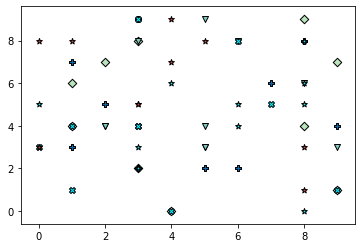

In [41]:
#plt.plot(np.random.randint(0,10,10), marker = "o",c = "#f0f9e8")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "D",facecolor = "#bae4bc",edgecolor = "black")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "v",facecolor = "#7bccc4",edgecolor = "black")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "P",facecolor = "#0868ac",edgecolor = "black")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "X",facecolor = "#08e8fc",edgecolor = "black")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "*",facecolor = "#08e8fc",edgecolor = "black")
plt.scatter(np.random.randint(0,10,10),np.random.randint(0,10,10), marker = "*",facecolor = "#e34234",edgecolor = "black")




In [42]:
plots

'/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/'

In [43]:
if 'df_work2' in globals():
    df_work2[[i for i in df_work2.columns if "homo" in i or "lumo" in i ]+["Em_lit"]].to_csv("tables/homo_lumo_lit.csv")
    

In [44]:
df = pd.DataFrame()
df[2]=[2,2,5]
df[3] =[3,5,3]
df["liste"]=[[2,4],[4,5],[2,66]]
df[[2 in i for i in df["liste"]]]["liste"]
df["liste"] = [i+[2] if j==2 and k==3 else i for i,j,k in zip(df["liste"], df[2],df[3]) ]
df

2  3      liste
0  2  3  [2, 4, 2]
1  2  5     [4, 5]
2  5  3    [2, 66]

# Helpers

In [45]:
def objecthash(df, col1, col2):
    dfb = pd.DataFrame({col2:df[col2].value_counts().index})
    for c1 in df[col1].value_counts().index:
        ls = []
        for c2 in df[col2].value_counts().index:
            try:
               # print(c1,c2,df.groupby([col1,col2]).size().loc[c1].loc[c2])
                ls.append(df.groupby([col1,col2]).size().loc[c1].loc[c2])
            except:
                #print(c1,c2,0)
                ls.append(0)
        dfb[c1] = ls
    
    dfb = dfb.set_index(col2)
    return dfb
            

In [46]:
def hashmap(dflg,col1,col2):
    #sns.set (rc = {'figure.figsize':(8, 5)})
    ax = sns.heatmap(objecthash(dflg,col1,col2),linewidths=0.5,annot= True)#,yticklabels=1)
    #ax = sns.heatmap(objecthash(dflg,col1,col2),annot= True)#,yticklabels=1)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    #sns.set(font_scale=200)
    ax.set_xlabel(col1)
    
    return ax

In [47]:
def blindserie(columns,spin,met,pdb):
    ser={}
 #   spin= 5
  #  met = "nbo"
   # pdb = "1CCC"
    for c in columns:
        if c ==  "spin":
            ser[c] = [spin]
        elif c ==  "Ox":
            ser[c] = {1:[0],2:[1],5:[0],6:[1]}[spin]
        elif c == "method":
            ser[c] = [met]
        else:
            ser[c] = [None]
    return pd.DataFrame(ser,index=[pdb])

In [48]:
def dfkat(df,kat,**kwargs):
    defcolname="Kategorie"
    colname = kwargs.pop('column', defcolname)
    defboolean = True
    boolean = kwargs.pop("inlist", defboolean)
    if boolean:
        return df[[kat in i for i in df[colname]]]
    else:
        return df[[not kat in i for i in df[colname]]]

In [49]:
#c : "red", "marker" :  "D", "facecolor" :"none", "edgecolor" : "black" ,"s" : 2


scatterdict = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":10},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":9},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":9},
           "other":{"c":(0,0,0),"marker":"D","s":20}}

sio = 20
sil = 10
scatterdict = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":sil},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"D","s":sio}}

sio = 30
sil = 30
scatterdict2 = {HH:{"c" : "magenta", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "D", "zorder":3, "s":sil},
           CHM:{"c":"orange", "marker" :  "D", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"D","s":sio}}


scatterdict = {HH:{"c" : "#e34234", "marker" :  "d", "zorder":3, "s":sil},
           BHIS:{"c":"cyan", "marker" :  "+", "zorder":3, "s":sil},
           CHM:{"c":"yellow", "marker" :  "v", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"o","s":sio}}
scatterdict = {HH:{"facecolor" : "#e34234","edgecolor":"black", "marker" :  "D", "zorder":3, "s":sil},
           BHIS:{"facecolor":"cyan","edgecolor":"black", "marker" :  "d", "zorder":3, "s":sil},
           CHM:{"facecolor":"yellow","edgecolor":"black", "marker" :  "v", "zorder":3, "s":sil},
           "other":{"c":(0,0,0),"marker":"o","s":sio}}

Colorbarheme = ("black","red","green")
Colorbar = {} 
for k in scatterdict.keys():
    try:
        Colorbar[k] = scatterdict[k]["c"]
    except:
        Colorbar[k] = scatterdict[k]["facecolor"]
    
    
def scatterkat(dfg,x,y, katlist, dictionary = scatterdict):
    df = dfg
    f  = plt.scatter(df[x],df[y], **dictionary["other"],label="all")
    for kat in katlist:
        df = dfg[dfg["Kategorie2"] ==kat]
        plt.scatter(df[x],df[y], **dictionary[kat],label=kat)
    df = dfg
    
    return f

    
def scatterkat(dfg,x,y, katlist, dictionary = scatterdict):
    df = dfg
    #f  = plt.scatter(df[x],df[y], **dictionary["other"],label="all")
    abc = [i for i in df["Kategorie2"].value_counts().index if i not in katlist]
    df["Kategorie3"]  = ["other" if i in abc else i for i in df["Kategorie2"]]
    
    for kat in katlist+["other"]:
        df = dfg[dfg["Kategorie3"] ==kat]
        plt.scatter(df[x],df[y], **dictionary[kat],label=kat)
    df = dfg
    
    return f
fig = plt.figure(dpi = 150)#,figsize=(10,3))

if 'df_work2' in globals():
    scatterkat(df_work2,"diff_2_nbo","Em_lit",Kategorie)
    plt.legend()
    plt.ylabel(redox)
    fig.legend()


<Figure size 900x600 with 0 Axes>

In [50]:
HH

'*_HIS/HIS'

In [51]:
def string1(str1):
    str1 =str1.replace(HH,"HisHis")
    str1 =str1.replace(CHM,"CHM")
    str1 = str1.replace(BHIS,"B-HIS")
    str1 =str1.replace("chem_pot","chempot")
    str1 =str1.replace("Em_lit","Em")

    str1 =str1.replace("_nbo","}")
    
    str1 = str1.replace("_","_{")
    str1 =str1.replace("chempot","chem pot")    
    return f"${str1}$"

In [52]:
def pca_show(df_work2, **kwargs):
    """num_comp = number of components default 6"""    
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components) 
    if num_of_componentes>df_work2.shape[1]:
        num_of_componentes=df_work2.shape[1]
        
    
    
    best_n=3
    best_par = kwargs.pop('best_par', default_value_n_components)     
    if best_par> num_of_componentes:
        best_par== num_of_componentes
        
    default_value_whiten = False
    whiten_ = kwargs.pop('whiten', default_value_whiten)
    
    df_work2 = df_work2[[n for n in df_work2.columns if not n in [i for i in df_work2.dtypes[df_work2.dtypes==object].index]]]

    X = df_work2.values
    s = StandardScaler()
    X = s.fit_transform(X)
    p = PCA(n_components = num_of_componentes, whiten = whiten_)
    p.fit(X)
    X_transformed = p.transform(X)
    X_transformed_filtered = X_transformed
    
    print("noise variance: ",p.noise_variance_)
    print( "number of componentes: ", num_of_componentes) 
    print((p.explained_variance_ratio_[:]))
    
    cols = list(df_work2.columns)
    df =  pd.DataFrame(p.components_,columns = cols)
    df["variance_ratio"] = p.explained_variance_ratio_[:]
    return df 

In [53]:
def best_components(df, **kwargs):
        
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components) 
    
    default_value_min_Em_lit = 0.1
    min_Em_lit = kwargs.pop('min_Em_lit', default_value_min_Em_lit)

    default_value_min_PC = 0.15
    min_PC = kwargs.pop('min_PC', default_value_min_PC)
    
    
    
    df  =pca_show(df,num_comp=num_of_componentes, whiten = True) #,num_comp=32)
    df_abs = df.abs()

    bo = df[df_abs["Em_lit"]> min_Em_lit ].index

    list_of_df = []

    for b in bo:

        numname = [(np.round(v,4),i) for i,v in zip(df.loc[b].index,df.loc[b]) if abs(v)>min_PC]
        names = [i[1] for i in numname] 
        nums = [i[0] for i in numname] 
        list_of_df.append(pd.DataFrame({df.loc[b]["Em_lit"]:nums}, index= names))

    if len(list_of_df)>1:
        a = []
        for i in list_of_df:
            a = a+ list( i.index)
        a = list(set(a))


        list_of_best = [i for i in a if all([i in j.index for j in list_of_df]) ]
        Matrix = [[ld.loc[[lb]].iloc[0,0] for ld in list_of_df] for lb in list_of_best]
        #print(Matrix, list_of_df)
        df_bo = pd.DataFrame(Matrix, index = list_of_best, columns = [(df.loc[b]["Em_lit"]) for b in bo])
        df_bo["mean"] = df_bo.mean(axis = 1)
        list_of_df.append( df_bo)
        return list_of_df

In [54]:
def pca_col(df,col, **kwargs):
    """ num_comp = 6"""
    default_value_n_components=6
    num_of_componentes = kwargs.pop('num_comp', default_value_n_components)     
    
    
    df = pca_show(df,num_comp = num_of_componentes)

    "variance_ratio" in df.columns
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
    
    bo = df[col].abs().nlargest(2).index
    
    #df_abs = df.abs()
    #bo = df[df_abs[col]> col_min ].index
    
    dff= {}

    for i,b in enumerate(bo):
        dff[i]={col:np.round(df.loc[b][col],4)}
        
        
        serie = df.loc[b][[i for i in df.columns if i != col]].abs().nlargest(2)
        vals = list(serie)
        ind = serie.index
        dff[i]["df"]=pd.DataFrame({i:vals},index=ind)
        dff[i]["variance_ratio"] = variance_ratio.loc[b]
        dff[i]["HK"]=b
    return dff




In [55]:
if 'dfpca1' in globals():

    di = pca_col(dfpca1,"Em_lit")
    di[1]["df"]

In [56]:
if 'dfpca1' in globals():
    import pprint
    d = pca_col(dfpca1,"ruffling")
    pprint.pprint(d)

In [57]:
try:
    fig = plt.figure(dpi = 150)
    plt.scatter(dfpca1["diff_1_nbo"],dfpca1["elekphil_1_nbo"],c= dfpca1["ruffling"],vmax= 20)
    plt.colorbar()
except:
    2

<Figure size 900x600 with 0 Axes>

# Tabellen

In [29]:
dfex_1 =pd.read_csv("tables/mono.csv")
dfex_1  =dfex_1.set_index("pdb")
dfex_1 = dfex_1[[ "Elektrode","Ligand","EMv"]]
dfex_3 = pd.read_csv("tables/duplicated_moded.csv")
dfex_4 = dfex_3.drop_duplicates("PDB", keep=False)
dfex_4= dfex_4.set_index("pdb")#.rename({"PDB":"pdb"})
dfex_4 = dfex_4[[ "Elektrode","EMv"]]
#dfex_4 = dfex_4[[ "Elektrode","Ligand","EMv"]]

dfex_lit = dfex_1.append(dfex_4)
dfex_lit.index = dfex_lit.index.str.upper()
dfex_lit =dfex_lit.rename(columns = {"EMv":"Em_lit"})
df_axlig = pd.read_csv("tables/axligand.csv")
df_axlig = df_axlig.rename(columns={"# PDB": "pdb","ligand" : "ligand_pydish"}).set_index("pdb")
df_axlig = df_axlig[["ligand_pydish","saddling","ruffling"]]

df_calc = pd.read_csv("tables/calculated.csv")
df_calc = df_calc.drop("Unnamed: 0", axis=1).set_index("pdb")
_dihedral = pd.read_csv("tables/Dihedral.csv")
_dihedral = _dihedral.rename(columns={"Unnamed: 0":"PDB"})
_dihedral = _dihedral.set_index("PDB")

df_ruffling = pd.read_csv("tables/Ruffling.csv").rename(columns = {"Unnamed: 0":"PDB"}).set_index("PDB")
df_saddling = pd.read_csv("tables/Saddling.csv").rename(columns = {"Unnamed: 0":"PDB"}).set_index("PDB")
df_ruffling_all = df_ruffling.copy()
df_saddling_all = df_saddling.copy()
modelist1 = [i for i in df_ruffling_all.index if i in dfex_lit.index]
modelist2 = [i for i in df_saddling_all.index if i in dfex_lit.index]
if (modelist2 == modelist1):
    print("ruffling + saddling")
else:
    raise Error
df_ruffling_all = df_ruffling_all.loc[modelist1]
df_saddling_all = df_saddling_all.loc[modelist1]
    
    
    
    
    
    
    
    
#dfHemetype = pd.read_csv("tables/Hemetypes.csv")
#dfHemetype = dfHemetype.set_index("pdb")


pdb_calc  = list(set(df_calc.index))
pdb_lit  = list(set(dfex_lit.index))
#print(    ([i for i in pdb_calc  if not i in pdb_lit])   )

pdbavaible = [i for i in pdb_calc if i in pdb_lit]
pdbavaiblepdb_calc  = list(set(df_calc.index))
pdb_lit  = list(set(dfex_lit.index))
print(    ([i for i in pdb_calc  if not i in pdb_lit])   )

pdbavaible = [i for i in pdb_calc if i in pdb_lit]
#pdbavaible

df_ruffling = df_ruffling.loc[pdbavaible]
df_saddling = df_saddling.loc[pdbavaible]

FileNotFoundError: [Errno 2] File b'tables/mono.csv' does not exist: b'tables/mono.csv'

In [ ]:
dflg = pd.read_csv("tables/Literature.csv")
dflg["pdb"].str.upper()
dflg = dflg.set_index("pdb")
dflg["ligup"] = [str(i).upper() for i in dflg["ligup"]]
dflg["ligdown"] = [str(i).upper() for i in dflg["ligdown"]]
dflg["ax_qn"] = [u+"-"+d for u,d in zip(dflg["ligup"],dflg["ligdown"] )]
dflg["ax_ql"] = [sorted([u,d])[0]+"-"+sorted([u,d])[1] for u,d in zip(dflg["ligup"],dflg["ligdown"] )]
dflg["Em_lit"] = dfex_lit.loc[[i for i in dflg.index]]["Em_lit"]
dflg["Elektrode"] = dfex_lit.loc[[i for i in dflg.index]]["Elektrode"]

dflg["ax_qn_r"] = [q if dflg["ax_qn"].value_counts()[q]>4 else "other" for q in dflg["ax_qn"]]
dflg["ax_ql_r"] = [q if dflg["ax_ql"].value_counts()[q]>4 else "other" for q in dflg["ax_ql"]]
dflg["ligup_r"] = [q if dflg["ligup"].value_counts()[q]>4 else "other" for q in dflg["ligup"]]
dflg["ligdown_r"] = [q if dflg["ligdown"].value_counts()[q]>4 else "other" for q in dflg["ligdown"]]

#dflg["His"] = [1 if "HIS" in i else 0 for i in dflg["ax_ql"] ]
#dflg["Met"] = [1 if "MET" in i else 0 for i in dflg["ax_ql"] ]


#[i+[2] if j==2 and k==3 else i for i,j,k in zip(df["liste"], df[2],df[3]) ]
dflg["Kategorie"]=[[] for i in dflg.index]

dflg["Kategorie"] = [i+[CHM] if H =="C" and A=="HIS-MET" else i for i,H,A in zip(dflg["Kategorie"], dflg["Hemetyp"],dflg["ax_ql_r"]) ]
#dflg["Kategorie"] = [i+["HM"] if A=="HIS-MET" else i for i,A in zip(dflg["Kategorie"],dflg["ax_ql_r"]) ]
dflg["HM"]=[True  if "HM" in i else False for i in dflg["Kategorie"]]




dflg["Kategorie"] = [i+[HH] if A=="HIS-HIS" else i for i,A in zip(dflg["Kategorie"],dflg["ax_ql_r"]) ]
dflg["Kategorie"] = [i+[BHIS] if H =="B" and A=="--HIS" else i for i,H,A in zip(dflg["Kategorie"], dflg["Hemetyp"],dflg["ax_ql_r"]) ]


dflg[HH]=[True  if HH in i else False for i in dflg["Kategorie"]]
dflg[BHIS]=[True  if BHIS in i else False for i in dflg["Kategorie"]]
dflg[CHM]=[True  if CHM in i else False for i in dflg["Kategorie"]]

dflg[HH]=[1  if HH in i else 0 for i in dflg["Kategorie"]]
dflg[BHIS]=[1  if BHIS in i else 0 for i in dflg["Kategorie"]]
dflg[CHM]=[1  if CHM in i else 0 for i in dflg["Kategorie"]]

dflg["Kategorie2"]= [i[0] if len(i)==1 else "other" for i in dflg["Kategorie"]]


#Kategorie = [item for sublist in dflg["Kategorie"] for item in sublist]
#Kategorie = list(set(Kategorie))
Kategorie = list(dflg["Kategorie2"].value_counts().index)

Kategorie.remove("other")
allkat = ["other"]+Kategorie

df_liganden = dflg.loc[pdbavaible].copy()

#dflit = dflg.copy()
dflg["ruffling"] = df_ruffling_all.loc[[i for i in dflg.index]].max(axis = 1)
dflg["saddling"] = df_saddling_all.loc[[i for i in dflg.index]].max(axis = 1)

#dflg = dflg.loc[pdbavaible]

In [ ]:
dflg = pd.read_csv("tables/Literature.csv")
dflg["pdb"].str.upper()
dflg = dflg.set_index("pdb")
dflg["ligup"] = [str(i).upper() for i in dflg["ligup"]]
dflg["ligdown"] = [str(i).upper() for i in dflg["ligdown"]]
dflg["ax_qn"] = [u+"/"+d for u,d in zip(dflg["ligup"],dflg["ligdown"] )]
dflg["ax_ql"] = [sorted([u,d])[0]+"/"+sorted([u,d])[1] for u,d in zip(dflg["ligup"],dflg["ligdown"] )]
dflg["Em_lit"] = dfex_lit.loc[[i for i in dflg.index]]["Em_lit"]
dflg["Elektrode"] = dfex_lit.loc[[i for i in dflg.index]]["Elektrode"]

dflg["ax_qn_r"] = [q if dflg["ax_qn"].value_counts()[q]>4 else "other" for q in dflg["ax_qn"]]
dflg["ax_ql_r"] = [q if dflg["ax_ql"].value_counts()[q]>4 else "other" for q in dflg["ax_ql"]]
dflg["ligup_r"] = [q if dflg["ligup"].value_counts()[q]>4 else "other" for q in dflg["ligup"]]
dflg["ligdown_r"] = [q if dflg["ligdown"].value_counts()[q]>4 else "other" for q in dflg["ligdown"]]

#dflg["His"] = [1 if "HIS" in i else 0 for i in dflg["ax_ql"] ]
#dflg["Met"] = [1 if "MET" in i else 0 for i in dflg["ax_ql"] ]


#[i+[2] if j==2 and k==3 else i for i,j,k in zip(df["liste"], df[2],df[3]) ]
dflg["Kategorie"]=[[] for i in dflg.index]

dflg["Kategorie"] = [i+[CHM] if H =="C" and A=="HIS/MET" else i for i,H,A in zip(dflg["Kategorie"], dflg["Hemetyp"],dflg["ax_ql_r"]) ]
#dflg["Kategorie"] = [i+["HM"] if A=="HIS-MET" else i for i,A in zip(dflg["Kategorie"],dflg["ax_ql_r"]) ]
dflg["HM"]=[True  if "HM" in i else False for i in dflg["Kategorie"]]




dflg["Kategorie"] = [i+[HH] if A=="HIS/HIS" else i for i,A in zip(dflg["Kategorie"],dflg["ax_ql_r"]) ]
dflg["Kategorie"] = [i+[BHIS] if H =="B" and A=="-/HIS" else i for i,H,A in zip(dflg["Kategorie"], dflg["Hemetyp"],dflg["ax_ql_r"]) ]


dflg[HH]=[True  if HH in i else False for i in dflg["Kategorie"]]
dflg[BHIS]=[True  if BHIS in i else False for i in dflg["Kategorie"]]
dflg[CHM]=[True  if CHM in i else False for i in dflg["Kategorie"]]

dflg[HH]=[1  if HH in i else 0 for i in dflg["Kategorie"]]
dflg[BHIS]=[1  if BHIS in i else 0 for i in dflg["Kategorie"]]
dflg[CHM]=[1  if CHM in i else 0 for i in dflg["Kategorie"]]

dflg["Kategorie2"]= [i[0] if len(i)==1 else "other" for i in dflg["Kategorie"]]


#Kategorie = [item for sublist in dflg["Kategorie"] for item in sublist]
#Kategorie = list(set(Kategorie))
Kategorie = list(dflg["Kategorie2"].value_counts().index)

Kategorie.remove("other")
allkat = ["other"]+Kategorie

for ud in dflg["ud"].value_counts().index:
 #   print(ud)
    dflg[f"{ud} "] = [1 if i==ud else 0 for i in dflg["ud"]]


df_liganden = dflg.loc[pdbavaible].copy()

#dflit = dflg.copy()
dflg["ruffling"] = df_ruffling_all.loc[[i for i in dflg.index]].max(axis = 1)
dflg["saddling"] = df_saddling_all.loc[[i for i in dflg.index]].max(axis = 1)

#dflg = dflg.loc[pdbavaible]


#    print([1 if i==ud else 0 for i in df_work2["ud"]])

In [ ]:
[i for i in pdbavaible if i not in dfex_lit.index]

In [ ]:
# hier wird überpüft ob die Dihedralen winkelb erchnet wurden

if not all(i in df_ruffling.index for i in pdbavaible):
    print(f"ruffling fehlt{[i for i in pdbavaible if i not in df_ruffling.index]}")
    
if not all(i in _dihedral.index for i in pdbavaible):
    print(f"Dihedral fehlt{[i for i in pdbavaible if i not in _dihedral.index]}")

if not all(i in df_saddling.index for i in pdbavaible):
    print(f"saddling fehlt{[i for i in pdbavaible if i not in df_saddling.index]}")    

In [ ]:
ls = {}
for spin in [1,2,5,6]:
    for met in ["nbo","chloro"]:
        df_oxmet = df_calc[df_calc["spin"] == spin]
        df_oxmet = df_oxmet[df_oxmet["method"] == met]
        #print(spin, met, [a1 for a1 in pdbavaible if a1 not in df_oxmet.index])
        for pdb in  [a1 for a1 in pdbavaible if a1 not in df_oxmet.index]:
            df_oxmet = df_oxmet.append(blindserie(df_oxmet.columns,spin,met,pdb))    
        df_oxmet = df_oxmet[[n for n in df_oxmet.columns if n not in ["spin", "method", "Ox"]]]

        #df_oxmet["diff"] = df_oxmet["lumo"] - df_oxmet["homo"]

        for c in df_oxmet.columns:
            df_oxmet = df_oxmet.rename(columns = {c:c+"_"+str(spin)+"_"+met}) 
        df_oxmet = df_oxmet.loc[pdbavaible]                                    
        ls[str(spin)+met] = df_oxmet


In [ ]:
df_calc.head()
df_hl = pd.DataFrame()
for s in [1,2,5,6]:
    df = df_calc[df_calc["method"]=="nbo"]
    #f = df[df["spin"]==s[["homo","lumo"]]
    df_hl[f"homo_{s}"]=df[df["spin"]==s]["homo"]
    df_hl[f"lumo_{s}"]=df[df["spin"]==s]["lumo"]
df_hl.to_csv("tables/homo_lumo.csv")

In [ ]:
dfex_lit.loc[pdbavaible]
df_work = dfex_lit.loc[pdbavaible].copy()
for k in ls.keys():
    df_work = pd.concat([df_work, ls[k] ],axis=1)


In [ ]:
df_work["ruffling"] = df_ruffling.max(axis = 1)
df_work["saddling"] = df_saddling.max(axis = 1)
for c in df_liganden.columns:
    df_work[c] = df_liganden[c]

In [ ]:
df_work2 = df_work[[c for c in df_work.columns if True not in df_work[c].isna().value_counts().index]]
for c in df_liganden.columns:
    df_work2[c] = df_liganden[c]
    
    
df_work2 = df_work2.drop(["2OYY","1CTJ"])    

In [ ]:
[i for i in df_liganden.columns if "_nbo" not in i]

In [ ]:
[f"e-{str(red)}-{str(ox)}" for ox in [2,6] for red in [1,5]]

In [ ]:
[f"e_{str(red)}_nbo e_{str(ox)}_nbo" for ox in [2,6] for red in [1,5]]

In [ ]:
for ox in [2,6]:
    for red in [1,5]:
        df_work2[f"edif-{str(ox)}-{str(red)}"] = df_work2[f"e_{str(ox)}_nbo"] - df_work2[f"e_{str(red)}_nbo"]

In [ ]:
df_work2.head()

In [ ]:
print(list(df_work[df_work.isna()["homo_6_nbo"]].index))
df_work6 = df_work.drop(list(df_work[df_work.isna()["homo_6_nbo"]].index))
df_work6 = df_work6[[c for c in df_work6.columns if True not in df_work6[c].isna().value_counts().index]]
for c in df_liganden.columns:
    df_work6[c] = df_liganden[c]

In [ ]:
df_work2["ligup"].value_counts()

# literaturwerte allein ohne QM

In [46]:
dflg["Kategorie"].value_counts()

[C_His/Met]    29
[]             23
[B_-/HIS]      12
[*_HIS/HIS]     9
Name: Kategorie, dtype: int64

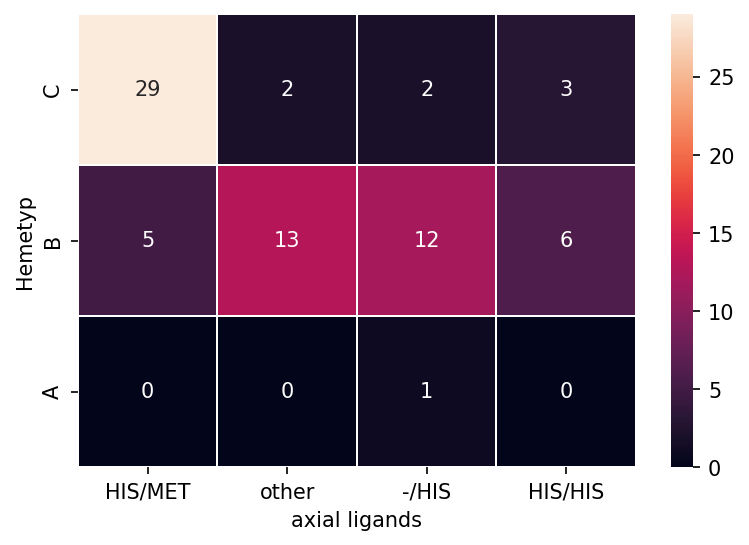

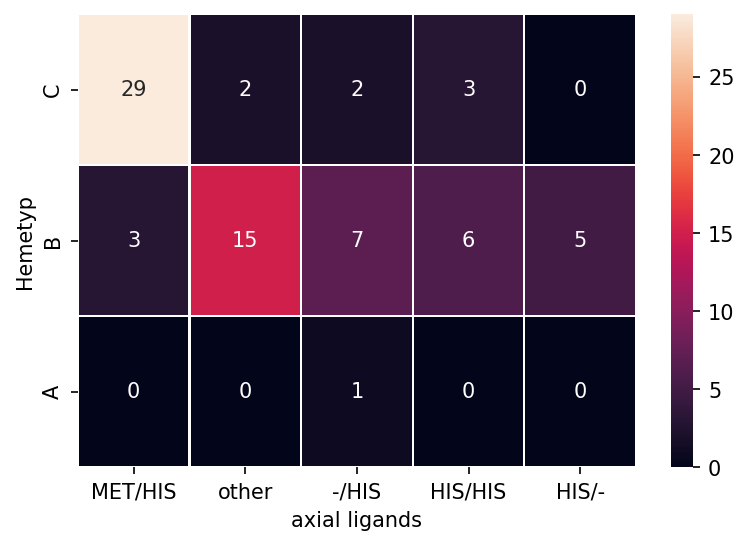

In [47]:
df =dflg.copy()

fig = plt.figure(dpi=150)
#f = hashmap(dflg, "ax_ql_r","Hemetyp")
df["axial ligands"] = df["ax_ql_r"]

f = hashmap(df, "axial ligands","Hemetyp")

type(f)
fig.savefig(f"{plots}Heme_ax_ql.png")

fig = plt.figure(dpi=150)
df["axial ligands"] = df["ax_qn_r"]
f = hashmap(df, "axial ligands","Hemetyp")
type(f)
fig.savefig(f"{plots}Heme_ax_qn.png")

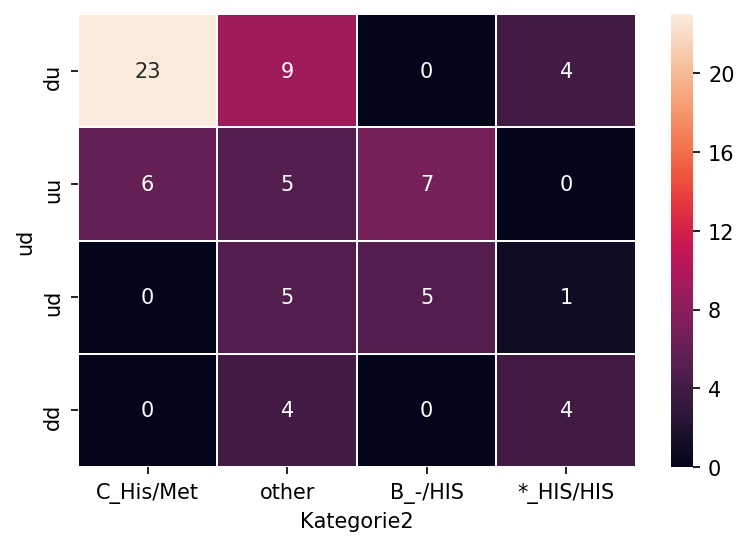

In [48]:
fig = plt.figure(dpi=150)
f = hashmap(dflg, "Kategorie2","ud")

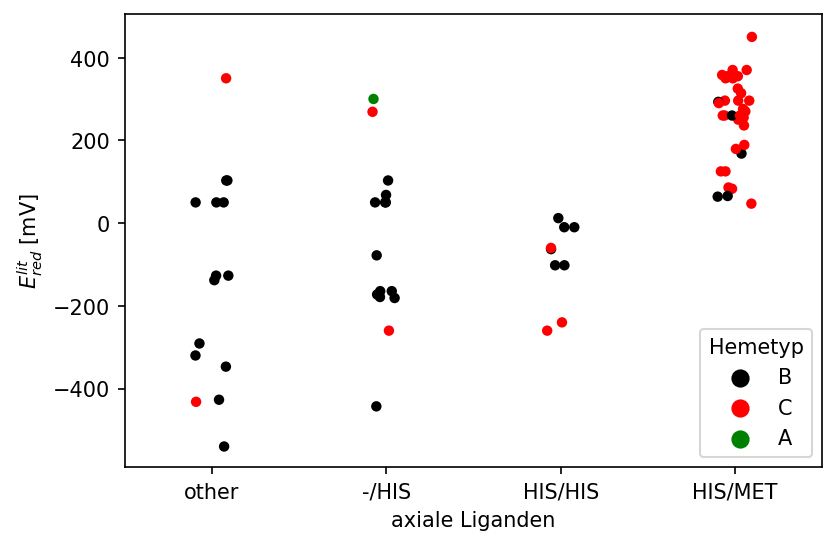

In [49]:
#Colorbarheme = ("black","red","green")
plt.figure(dpi=150)
df = dflg
df["axiale Liganden"] =df["ax_ql_r"]
df[redox]  =df["Em_lit"]
#fig = sns.stripplot(data =dflg, x = "ax_ql_r",hue = "Hemetyp", y = "Em_lit",palette=Colorbarheme)
fig = sns.stripplot(data =df, x = "axiale Liganden",hue = "Hemetyp", y = redox,palette=Colorbarheme)
fig.figure.savefig(f"{plots}Liganden1.png")

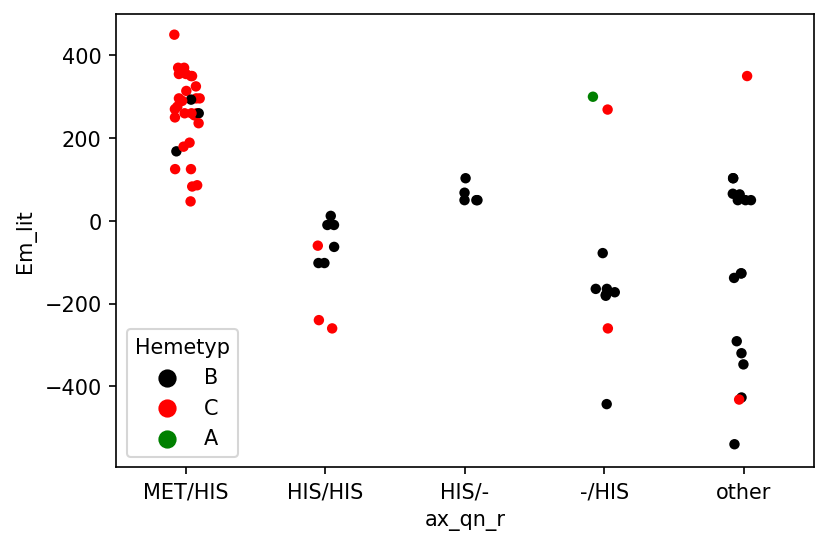

In [50]:
#Colorbarheme = ("black","red","green")
plt.figure(dpi=150)
order=  ["MET/HIS", "HIS/HIS","HIS/-", "-/HIS","other"]
fig = sns.stripplot(data =dflg, x = "ax_qn_r",hue = "Hemetyp", y = "Em_lit",palette=Colorbarheme, order = order)


#fig.figure.savefig(f"{plots}Liganden1.png")

In [51]:
df  = dflg.copy()
df = df[df["ax_qn_r"]=="-/HIS"]
df = df[df["Em_lit"]<-200]
df["Em_lit"]


pdb
1FHF       -443.0
1IQC_HIS   -260.0
Name: Em_lit, dtype: float64

In [52]:
df  = dflg.copy()
df.loc[[i for i in df.index if "PCB" in i]]["Em_lit"]


pdb
2PCB    260.0
Name: Em_lit, dtype: float64

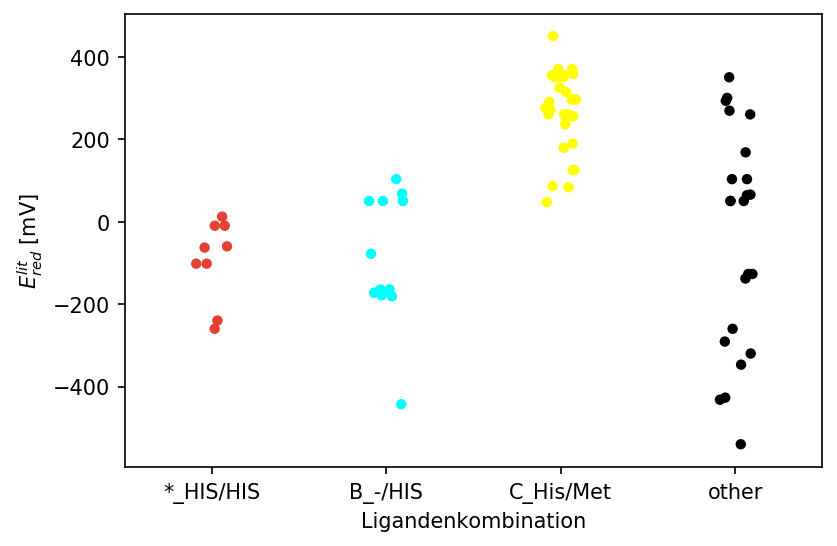

In [53]:
plt.figure(dpi=150)
df = dflg.copy()
df[redox]= df["Em_lit"]
df["Ligandenkombination"] = df["Kategorie2"]
#fig = sns.stripplot(data =dflg, x = "Kategorie2", order = Colorbar.keys(),y = "Em_lit",palette=Colorbar.values())
fig = sns.stripplot(data =df, x = "Ligandenkombination", order = Colorbar.keys(),y = redox,palette=Colorbar.values())
fig.figure.savefig(f"{plots}Liganden2.png")

In [54]:
plots

'/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/'

In [55]:
df = dflg.copy()
df = df[df["ax_qn_r"]=="other"]
dd = df["ax_qn"].value_counts().to_dict()
for k in dd:
    dd[k]=[dd[k]]
dff = pd.DataFrame(dd ,index= ["n"])#.to_csv(f"{plots}tables/others1.csv")    

In [56]:
df = dflg.copy()
#df = df[df["Kategorie2"]=="other"]
df = df[df["ax_qn_r"] == "other"]
dd = df["ax_qn"].value_counts().to_dict()

pd.DataFrame({"n":list(dd.values())}, index = list(dd.keys())).to_csv(f"{plots}tables/others2.csv")  

#dff.to_csv(f"{plots}tables/others2.csv")  

In [57]:
dff

HIS/MET  CYS/-  CSS/HIS  PRO/HIS  HIS/CYS  HIS/NO  TYR/-  ARG/CYS  -/IMD  \
n        2      2        1        1        1       1      1        1      1   

   TYR/HIS  HIS/HSH  HIS/O2  HIS/CN  -/-  HIS/CO  
n        1        1       1       1    1       1

In [58]:
print(f"{plots}tables/others2.csv")  

/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/tables/others2.csv


In [59]:
df = dflg.copy()
#df = df[df["Kategorie2"]=="other"]
df = df[df["ax_qn_r"] == "other"]
df["abc"]= [f"{H}_{ax}" for H,ax in zip(df["Hemetyp"], df["ax_qn"])]
dd = df["abc"].value_counts().to_dict()

#for a,b in df["abc"].value_counts().to_dict()

df2 =df[["Hemetyp","ax_qn","abc"]].set_index("abc")
df2["bc"]=[dd[col] for col in df2.index]

df2 = df2.drop_duplicates()
df3= pd.DataFrame()
df3["Häm"] = df2["Hemetyp"]
df3["ax Lig"] = df2["ax_qn"]
df3["n"] = df2["bc"]
df3 = df3.set_index("Häm")
df3 = df3.sort_index(ascending = False)
df3.to_csv(f"{plots}tables/others2.csv")  
df3
#pd.DataFrame({"n":list(dd.values())},  index = list(dd.keys())).to_csv(f"{plots}tables/others2.csv")  

ax Lig  n
Häm            
C    TYR/HIS  1
C    CSS/HIS  1
B     HIS/CO  1
B     HIS/O2  1
B        -/-  1
B      -/IMD  1
B     HIS/CN  1
B     HIS/NO  1
B    HIS/CYS  1
B    HIS/HSH  1
B    HIS/MET  2
B      TYR/-  1
B      CYS/-  2
B    ARG/CYS  1
B    PRO/HIS  1

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


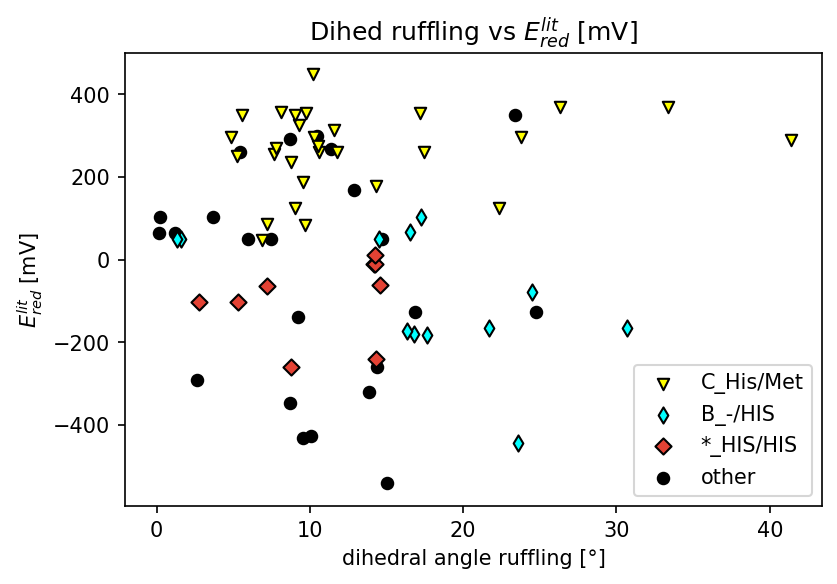

In [60]:
plt.figure(dpi=150)
scatterkat(dflg,"ruffling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedruf)
plt.title(f"Dihed ruffling vs {redox}")
plt.legend()

plt.savefig(f"{plots}ruffling.png")

In [61]:
Kategorie

['C_His/Met', 'B_-/HIS', '*_HIS/HIS']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


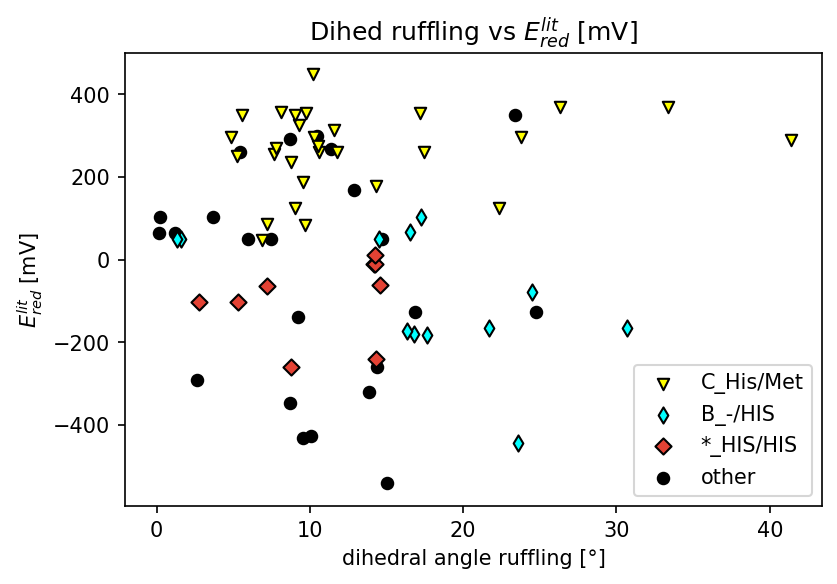

In [62]:
plt.figure(dpi=150)
scatterkat(dflg,"ruffling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedruf)
plt.title(f"Dihed ruffling vs {redox}")
plt.legend()

plt.savefig(f"{plots}ruffling.png")

In [63]:
df = df_work2.copy()
X = df[["ruffling","Em_lit"]]

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


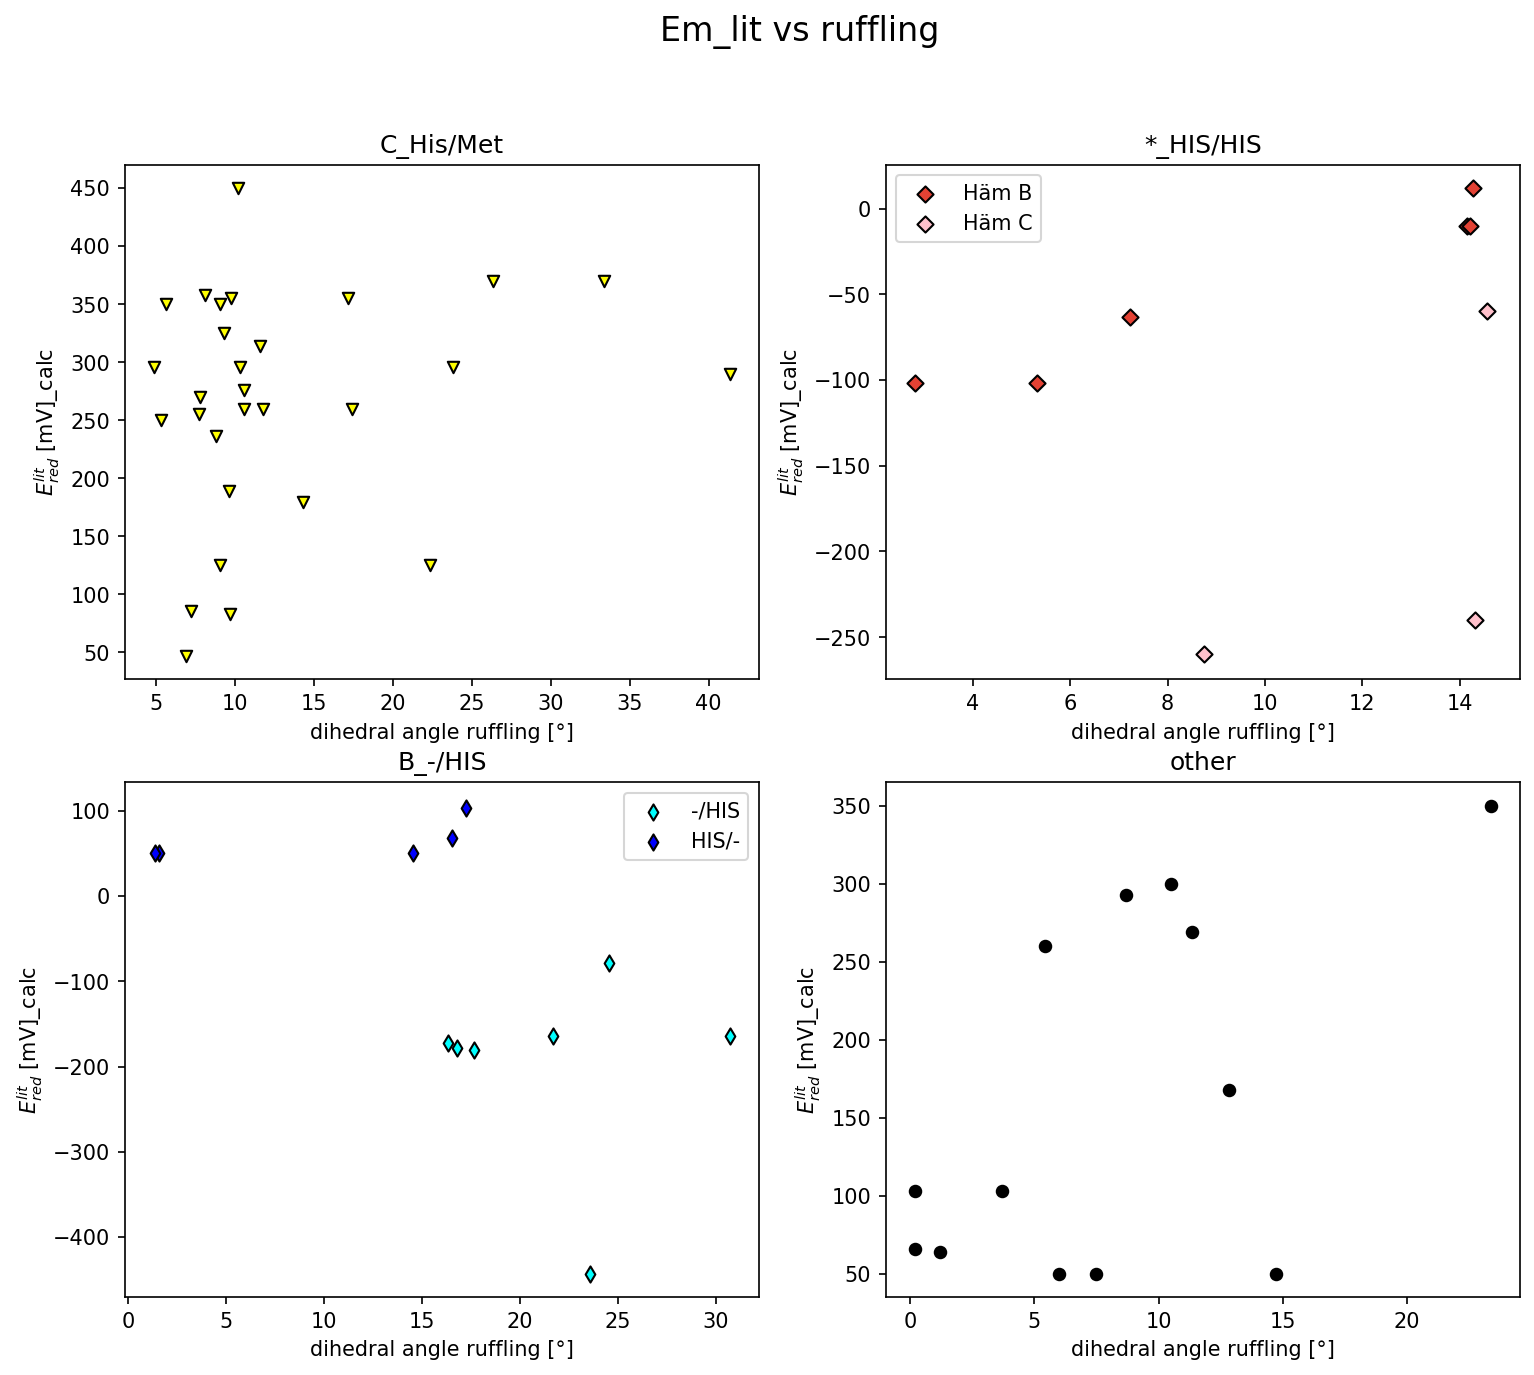

In [64]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]
edif  = "Em_lit"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)



model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = dflg.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )













df = dflg.copy()
df = df[df["Kategorie2"]==kat]


#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
#plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])
plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])#,c =df[edif])

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.legend()
plt.subplot(222)
kat = HH
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["Hemetyp"].value_counts().index):
    df = df2[df2["Hemetyp"]==a]

    #plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat],label=f"Häm {a}",c={"C":"pink","B":scatterdict[kat]["facecolor"]}[a])

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")

plt.legend()
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["ligup"].value_counts().index):
    df = df2[df2["ligup"]==a]
    #df = df[df[edif]>0]
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat],label={"-":"-/HIS","HIS" :"HIS/-"}[a],c={"HIS":"blue","-":scatterdict[kat]["facecolor"]}[a])

   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])
  #  plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"blue"}[a1])

    
    
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
x = np.linspace(14,30)

#plt.plot(x,model.predict(x.reshape(len(x),1)),c= "blue",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )
#plt.legend()


plt.subplot(224)
kat = "other"
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.title(kat)
df = dflg.copy()
df = df[df["Kategorie2"]==kat]

df = df[df[edif]>0]
plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
fig.savefig(f"{plots}ruffling_2.png")

In [65]:
df =dflg.copy()
df = df[df["ruffling"]<25]
df = df[df["ruffling"]>20]
df = df[df["Kategorie2"]==CHM]
df[["Em_lit","ruffling"]]

Em_lit   ruffling
pdb                    
1CRY   296.0  23.777117
5MCS   125.0  22.346135

In [66]:
model = KMeans(n_clusters = 3)
model.fit(X_transformed)

labels = model.labels_

labels
#plt.scatter(df["ruffling"], df["Em_lit"], c = labels)
#plt.show()

array([0, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2,
       2, 1, 1, 0, 0, 0, 0, 0, 0, 2, 1, 1, 0, 0, 1, 1, 2, 0, 0, 2, 2, 2,
       0, 2, 0, 2, 1, 1], dtype=int32)

Text(0.5, 1.0, 'Heme B')

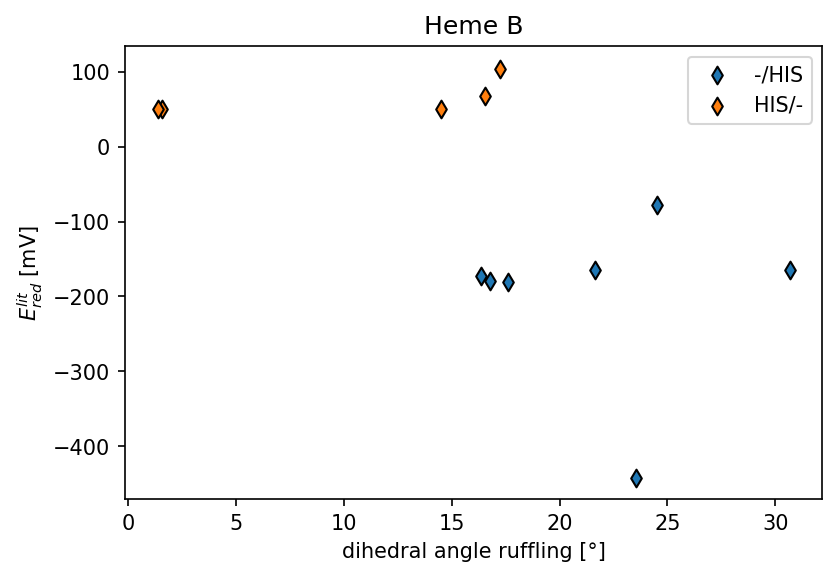

In [67]:
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
plt.figure(dpi=150)
from matplotlib.markers import MarkerStyle


for i,c in enumerate (df["ax_qn"].value_counts().index):

    
    
    df2 = df[df["ax_qn"] ==c]
    plt.scatter(df2["ruffling"], df2["Em_lit"],label =c,edgecolor="black", marker = "d")#,c = scatterdict[BHIS]["facecolor"])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox)
plt.title("Heme B")
#plt.savefig(f"{plots}ruffling_BHIS.png")

Text(0.5, 1.0, '*_HIS/HIS')

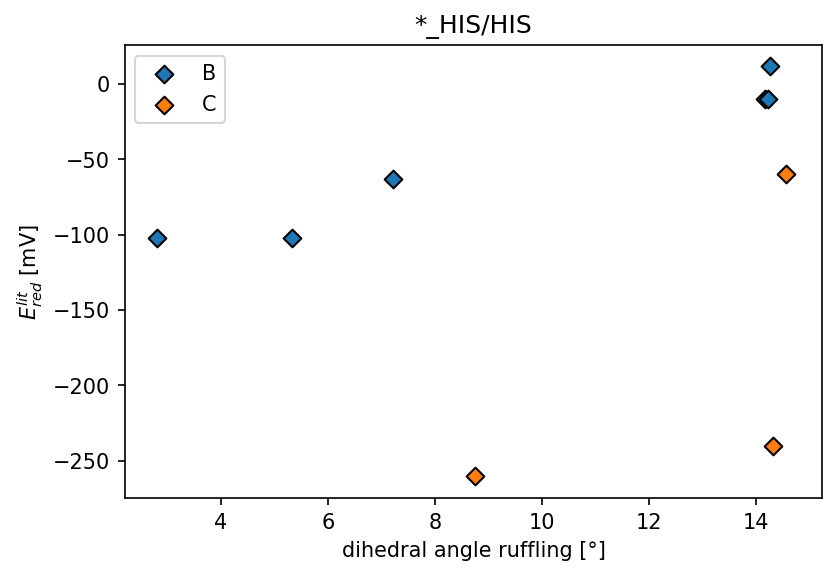

In [68]:
df = dflg.copy()
df = df[df["Kategorie2"]==HH]
plt.figure(dpi=150)
from matplotlib.markers import MarkerStyle


for i,c in enumerate (df["Hemetyp"].value_counts().index):
    m = MarkerStyle("D")
    m._transform.rotate_deg(90*i)
    
    
    df2 = df[df["Hemetyp"] ==c]
    plt.scatter(df2["ruffling"], df2["Em_lit"],label =c,edgecolor="black", marker = m)#,c = scatterdict[BHIS]["facecolor"])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(redox)
plt.title(HH)
#plt.savefig(f"{plots}ruffling_BHIS.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


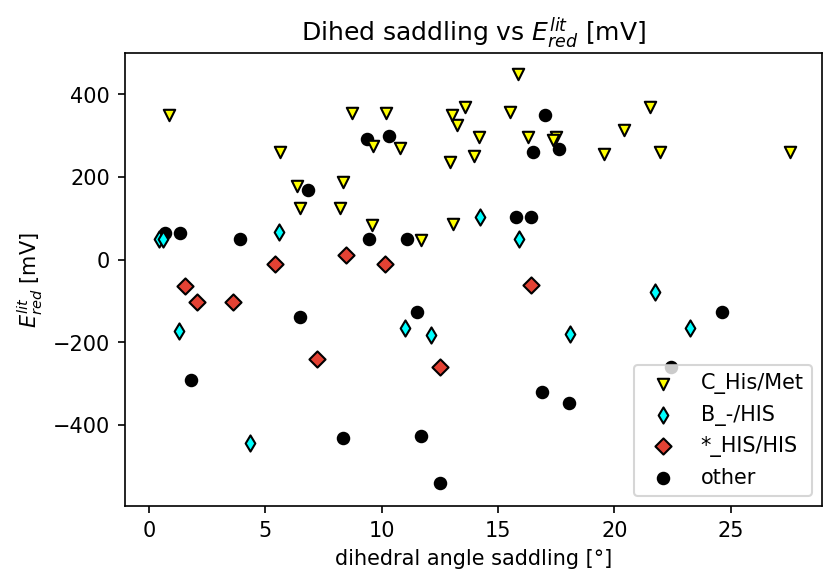

In [69]:

plt.figure(dpi=150)
scatterkat(dflg,"saddling","Em_lit",Kategorie)
plt.ylabel(redox)
plt.xlabel(dihedsad)
plt.title(f"Dihed saddling vs {redox}")
plt.legend()
plt.savefig(f"{plots}saddling.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


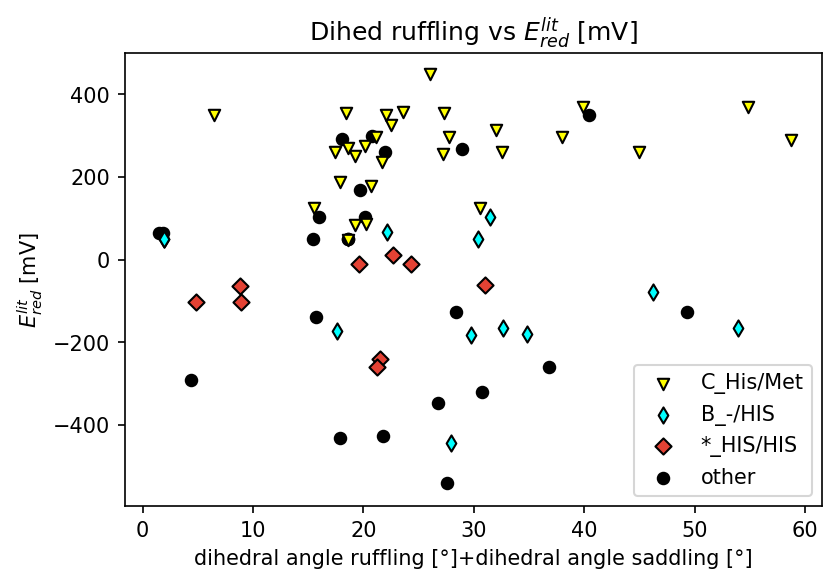

In [70]:
df = dflg.copy()
df["combi"] = df["ruffling"] + df["saddling"]
fig = plt.figure(dpi=150)
scatterkat(df,"combi","Em_lit",Kategorie)
plt.xlabel(f"{dihedruf}+{dihedsad}")
plt.ylabel(redox)
plt.title(f"Dihed ruffling vs {redox}")
plt.legend()
fig.savefig(f"{plots}linearcombi1.png")

/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/saddling_Emlit_CHM.png


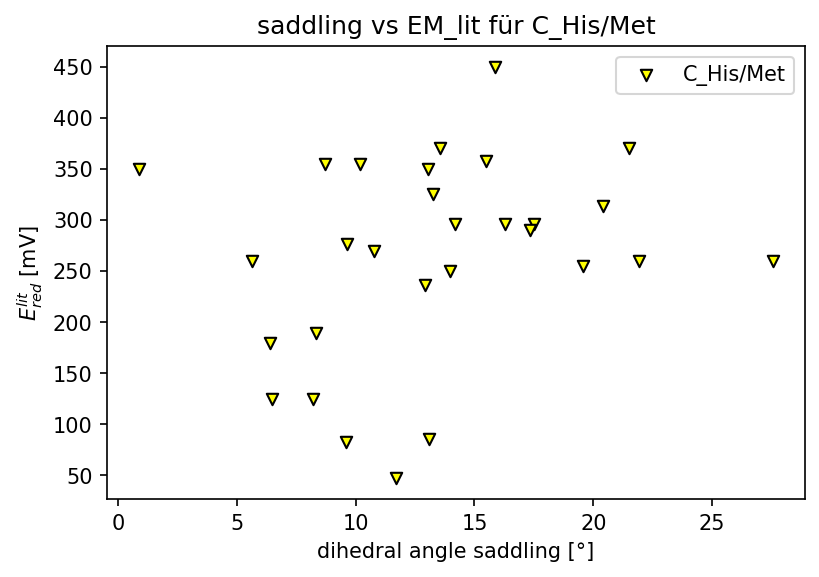

In [71]:
fig = plt.figure(dpi=150)

kombi = CHM
plt.title(f"saddling vs EM_lit für {kombi}")
df = dflg.copy()
df = df[df[kombi] == 1]
plt.scatter(df["saddling"], df["Em_lit"],**scatterdict[kombi],label = kombi)
plt.xlabel(dihedsad)
plt.ylabel(redox)
fig.savefig(f"{plots}saddling_Emlit_CHM.png")
print(f"{plots}saddling_Emlit_CHM.png")
plt.legend()

/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/saddling_Emlit_CHM.png


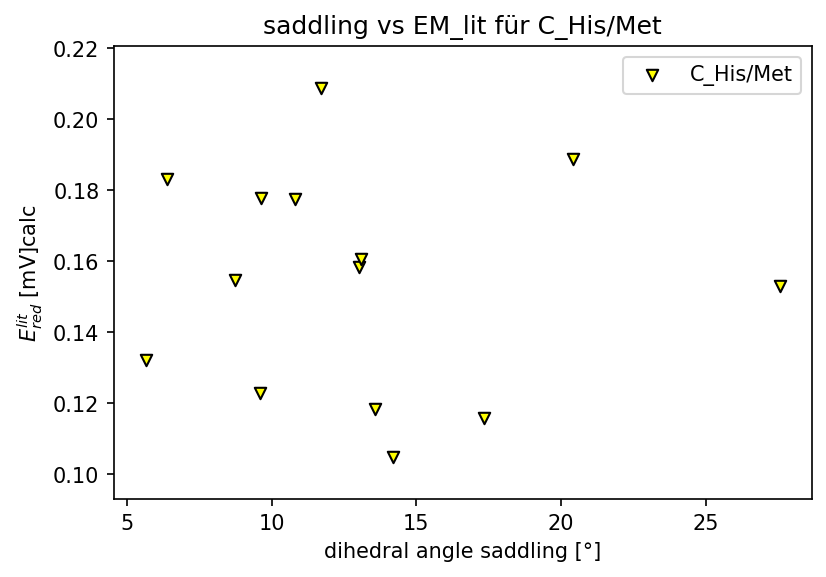

In [72]:
fig = plt.figure(dpi=150)
edif = "edif-2-1"
kombi = CHM
plt.title(f"saddling vs EM_lit für {kombi}")
df = df_work2.copy()
df = df[df[kombi] == 1]
df = df[df[edif]>-0.5]
plt.xlabel(dihedsad)
plt.ylabel(redox+"calc")
plt.scatter(df["saddling"], df[edif],**scatterdict[kombi],label = kombi)

print(f"{plots}saddling_Emlit_CHM.png")
plt.legend()

In [73]:
df_work6["Kategorie2"].value_counts()

other        17
C_His/Met    15
B_-/HIS      11
*_HIS/HIS     9
Name: Kategorie2, dtype: int64

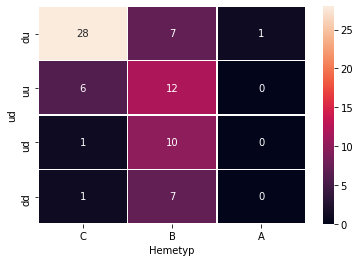

In [74]:
hashmap(dflg, "Hemetyp","ud")

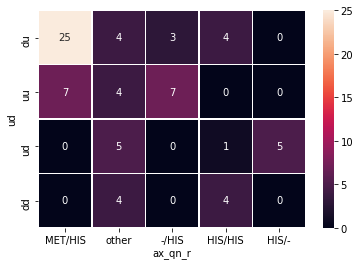

In [75]:
hashmap(dflg, "ax_qn_r","ud")

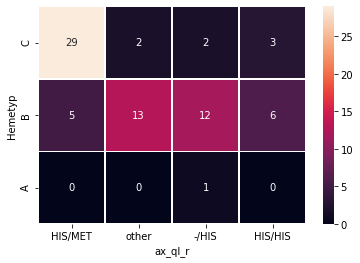

In [76]:
hashmap(dflg, "ax_ql_r","Hemetyp")

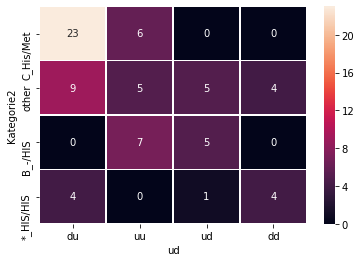

In [77]:
hashmap(dflg,"ud","Kategorie2")

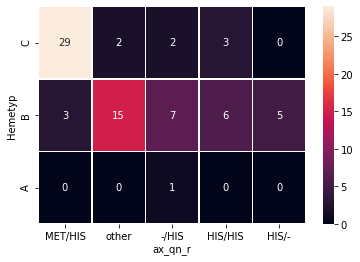

In [78]:
hashmap(dflg, "ax_qn_r","Hemetyp")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'dihedral angle ruffling [°]')

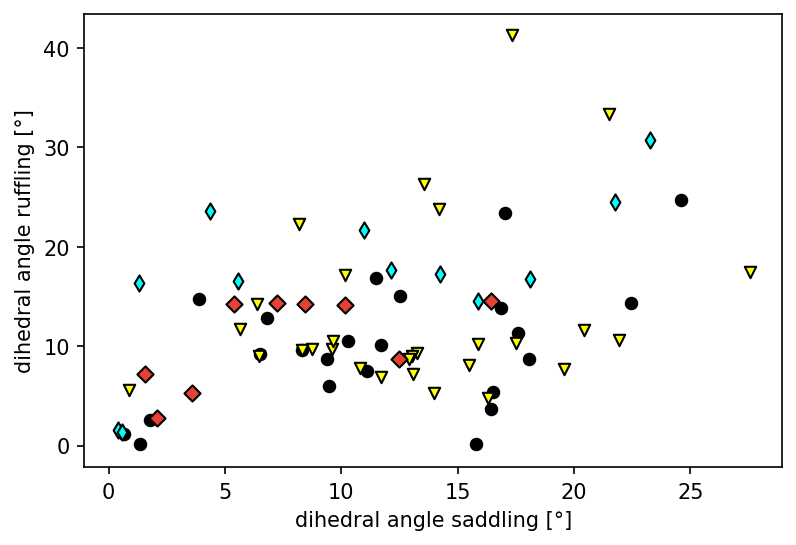

In [79]:
fig = plt.figure(dpi = 150)
scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)

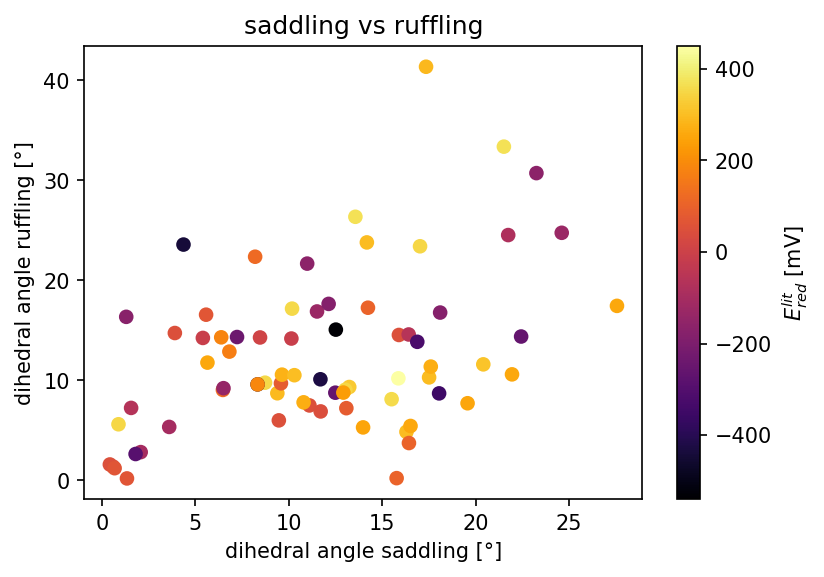

In [80]:
fig = plt.figure(dpi = 150)

plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
plt.title("saddling vs ruffling")
plt.scatter(dflg["saddling"],dflg["ruffling"],c = dflg["Em_lit"],cmap =cmap1)
col = plt.colorbar()
col.set_label(redox)
fig.savefig(f"{plots}ruffling_vs_saddling.png")

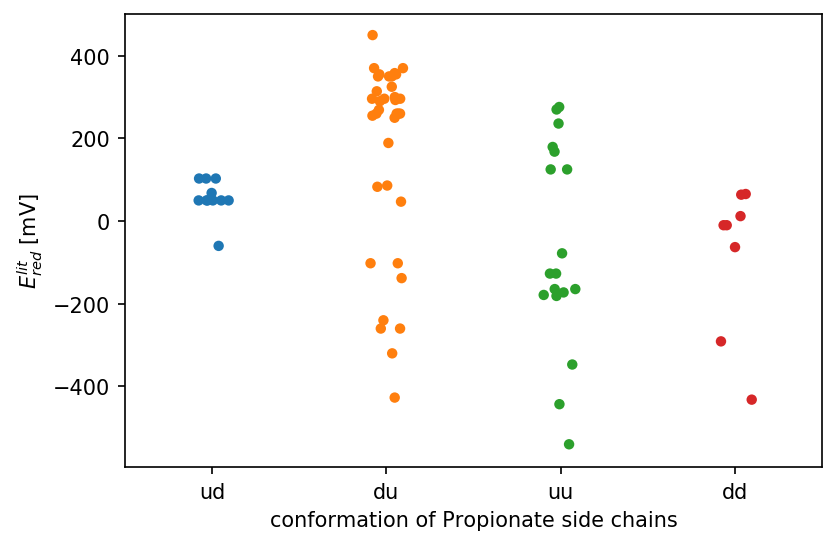

In [81]:
plt.figure(dpi=150)
df = dflg.copy()
df[redox] = df["Em_lit"]
df[Propionate] = df["ud"]
#fig = sns.stripplot(data=dflg, x = "ud", y ="Em_lit")
fig = sns.stripplot(data=df, x = Propionate, y =redox)

fig.figure.savefig(f"{plots}ud.png")

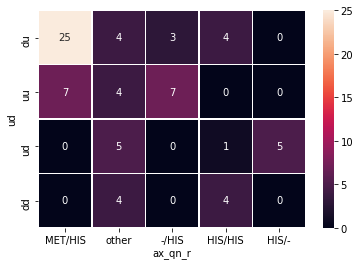

In [82]:
sns.stripplot(data=dflg, x = "ud", y ="Em_lit")

hashmap(dflg,"ax_qn_r","ud")

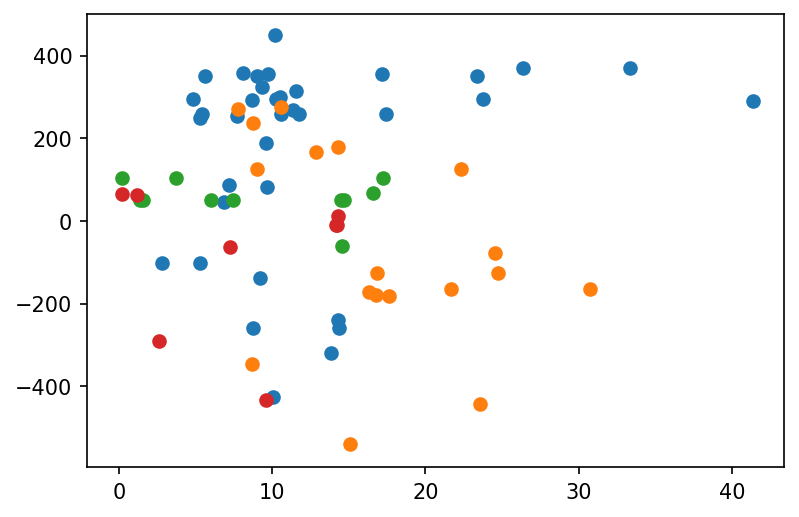

In [83]:
plt.figure(dpi=150)
for u in  dflg["ud"].value_counts().index:
    df =dflg.copy()
    df = df[df["ud"] == u]
    plt.scatter(df["ruffling"],df["Em_lit"])

# Graphiken mit QM   50

matplotlib.axes._subplots.AxesSubplot

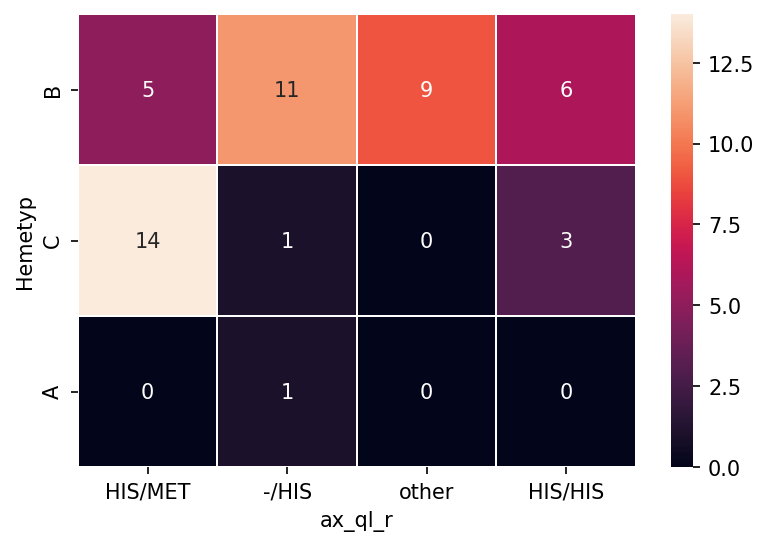

In [84]:
fig = plt.figure(dpi=150)

f = hashmap(df_work2, "ax_ql_r","Hemetyp")

type(f)


In [85]:
df_work2["Kategorie2"].value_counts()

other        16
C_His/Met    14
B_-/HIS      11
*_HIS/HIS     9
Name: Kategorie2, dtype: int64

In [86]:
print(Kategorie)
Kategorieqm = [BHIS,CHM]
Kategorieqm

['C_His/Met', 'B_-/HIS', '*_HIS/HIS']


['B_-/HIS', 'C_His/Met']

In [87]:
df_work2.head()

Em_lit Elektrode      e_1_nbo  edisp_1_nbo  homo_1_nbo  lumo_1_nbo  \
pdb                                                                        
1FJ0   350.0       NHE -3880.527002   -94.688740    -0.13578    -0.11133   
1C75    47.0       SHE -3881.470435   -98.072677    -0.17273    -0.05650   
1GU2   -60.0       NHE -3628.790867   -91.195247    -0.12370    -0.09996   
1JP6    50.0       NHE -3438.493534   -79.663631    -0.15456    -0.09723   
3CCX  -181.1       SHE -3362.232339   -75.521358    -0.18828    -0.08217   

      chem_pot_1_nbo  diff_1_nbo  elekphil_1_nbo  dipole_1_nbo  ...  \
pdb                                                             ...   
1FJ0        -0.12355     0.02445         0.31218        3.1214  ...   
1C75        -0.11461     0.11623         0.05651        6.5556  ...   
1GU2        -0.11183     0.02374         0.26339        5.8865  ...   
1JP6        -0.12590     0.05733         0.13823        3.6011  ...   
3CCX        -0.13523     0.10611         0.08616        5.1473  ...   

      C_His/Met  Kategorie2  du   uu   ud   dd   edif-2-1  edif-2-5  edif-6-1  \
pdb                                                                             
1FJ0          1   C_His/Met    1    0    0    0  0.158383  0.179734  0.145610   
1C75          1   C_His/Met    1    0    0    0  0.208779  0.142012  0.202708   
1GU2          0   *_HIS/HIS    0    0    1    0  0.103716  0.132084  0.119058   
1JP6          0     B_-/HIS    0    0    1    0  0.144321  0.203422  0.143352   
3CCX          0     B_-/HIS    0    1    0    0  0.196607  0.225644  0.213905   

      edif-6-5  
pdb             
1FJ0  0.166961  
1C75  0.135942  
1GU2  0.147426  
1JP6  0.202452  
3CCX  0.242943  

[5 rows x 76 columns]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/edif_Em_lit.png


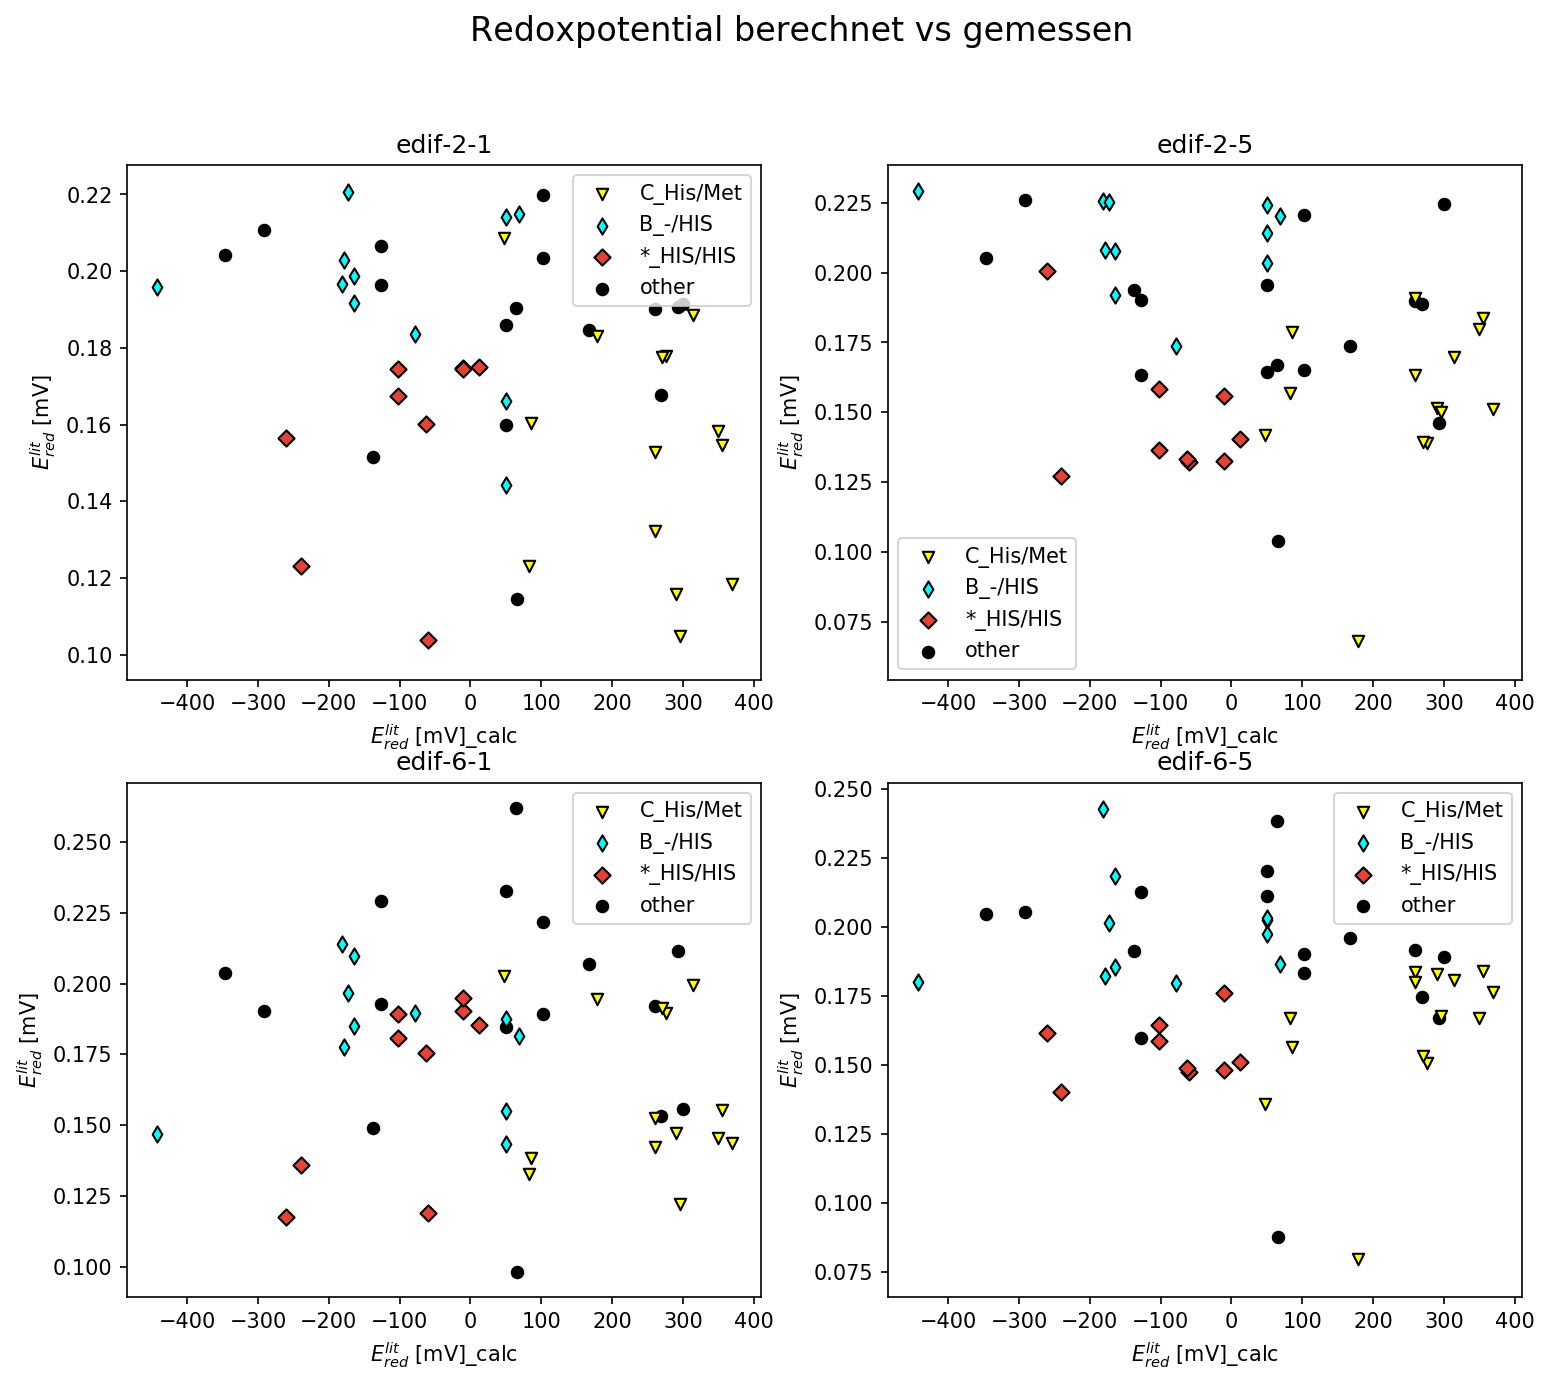

In [88]:
lit = "Em_lit"

if (True):
    fig = plt.figure(dpi=150,figsize=[12,10])
    fig.suptitle("Redoxpotential berechnet vs gemessen",fontsize =16)
    
    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.ylabel(redox)
        plt.xlabel(f"{redox}_calc")
        plt.legend()
else:
    c = "edif-2-1"

    fig = plt.figure(dpi=150)#,figsize=[12,10])
    
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs"+"  $E_{redox}(lit)$" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.ylabel(redox)
    plt.xlabel(f"{redox}_calc")   
    plt.legend()
fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-2-1
edif-2-5


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-6-1
edif-6-5
/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/edif_saddling.png


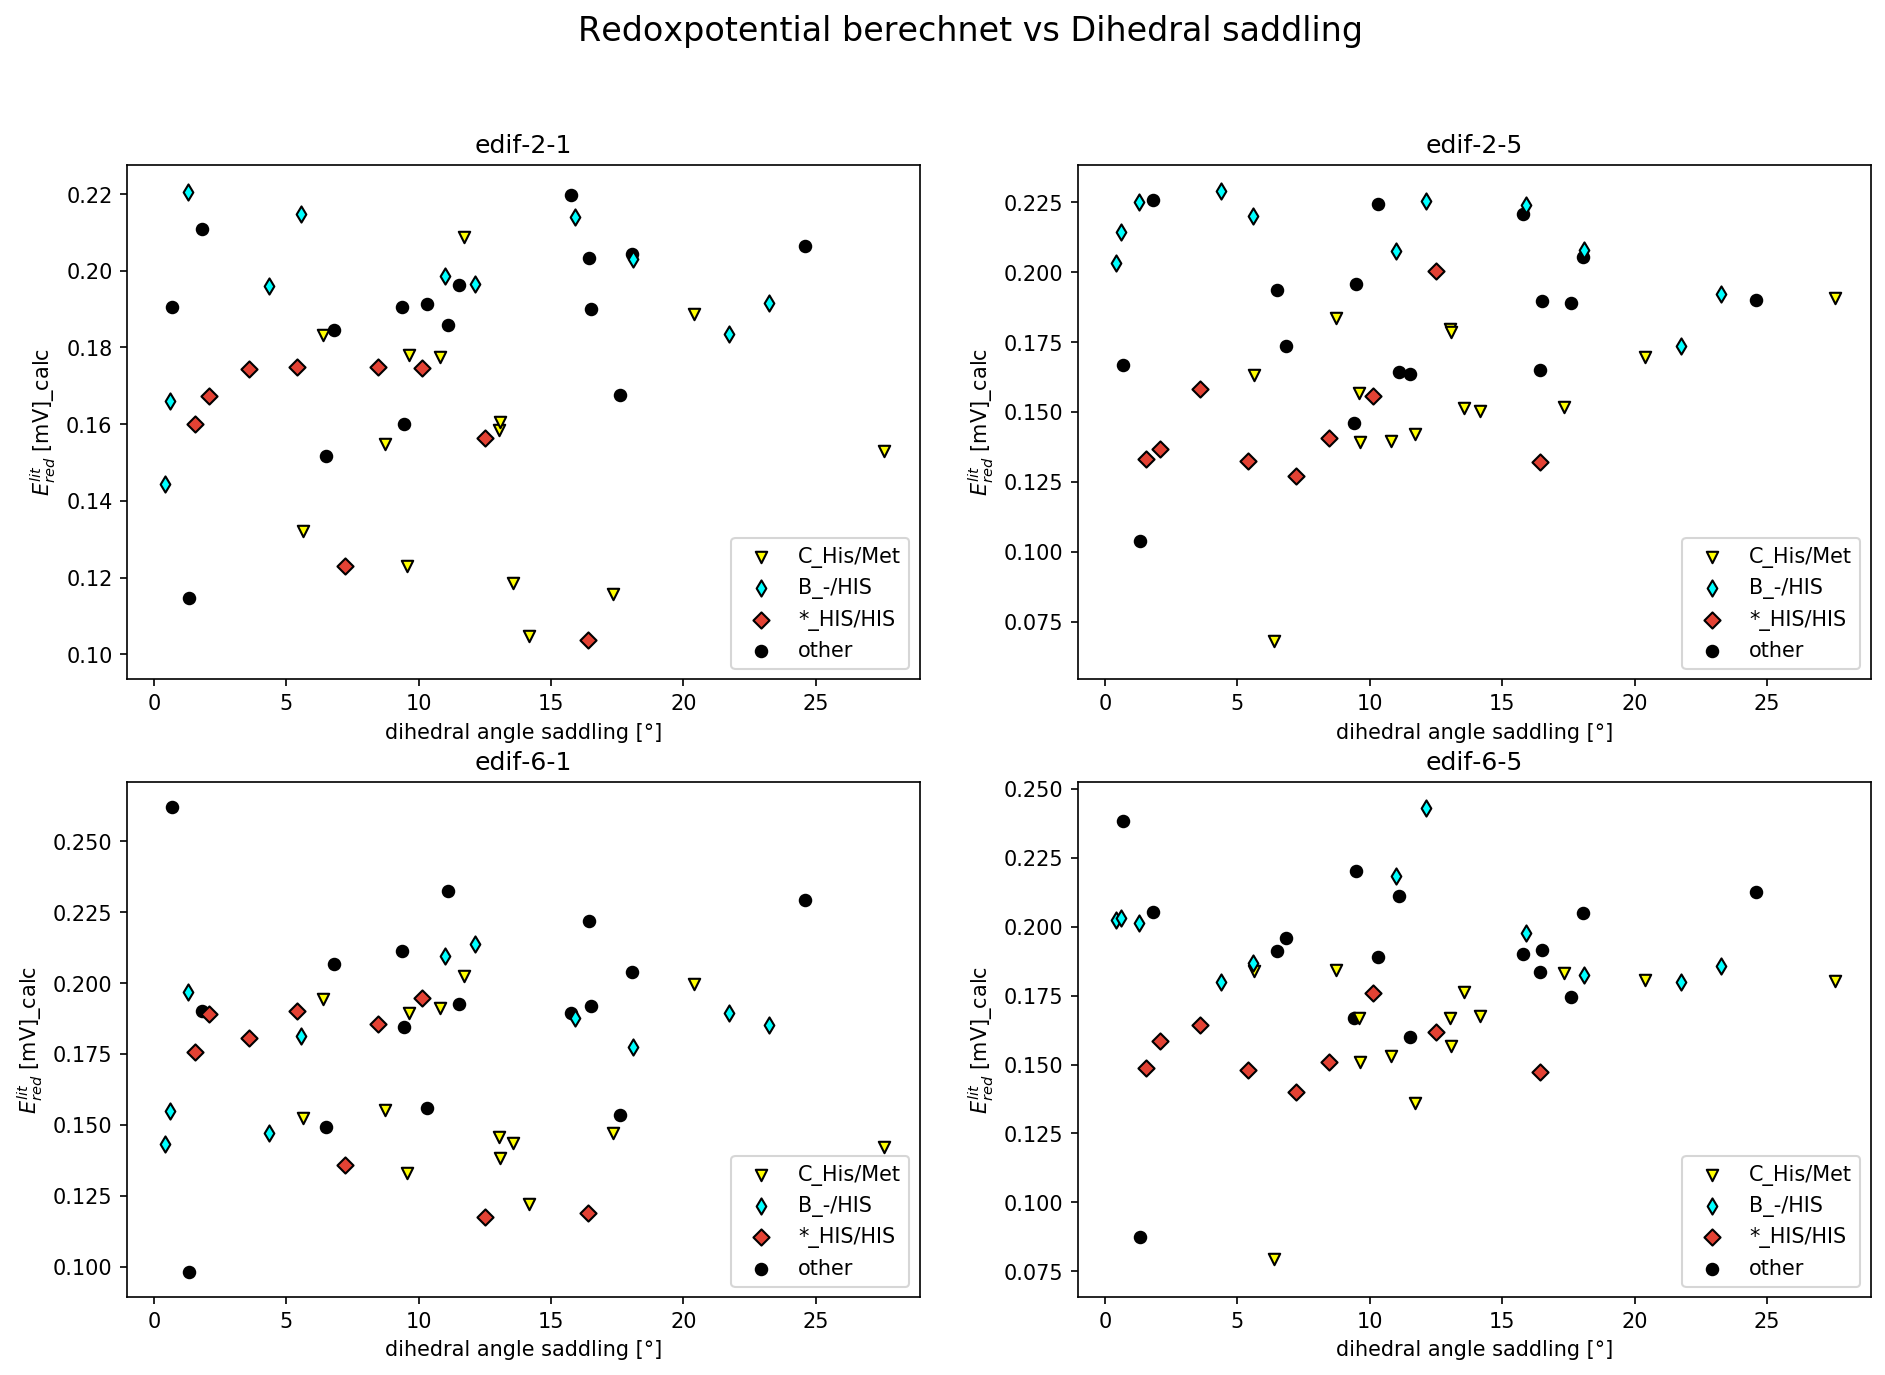

In [89]:
lit = "saddling"



if(True):
    fig = plt.figure(dpi=150, figsize=(15,10))
    fig.suptitle("Redoxpotential berechnet vs Dihedral saddling",fontsize =16)
    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        print(c)
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.xlabel(dihedsad)
        plt.ylabel(f"{redox}_calc")
        plt.legend()
else:        
    c = "edif-2-1"
    print(c)
    fig = plt.figure(dpi=150)
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs  {dihedruf}" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.xlabel(dihedruf)
    plt.ylabel(f"{redox}_calc")  
    plt.legend()

fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-2-1
edif-2-5
edif-6-1


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


edif-6-5
/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/edif_ruffling.png


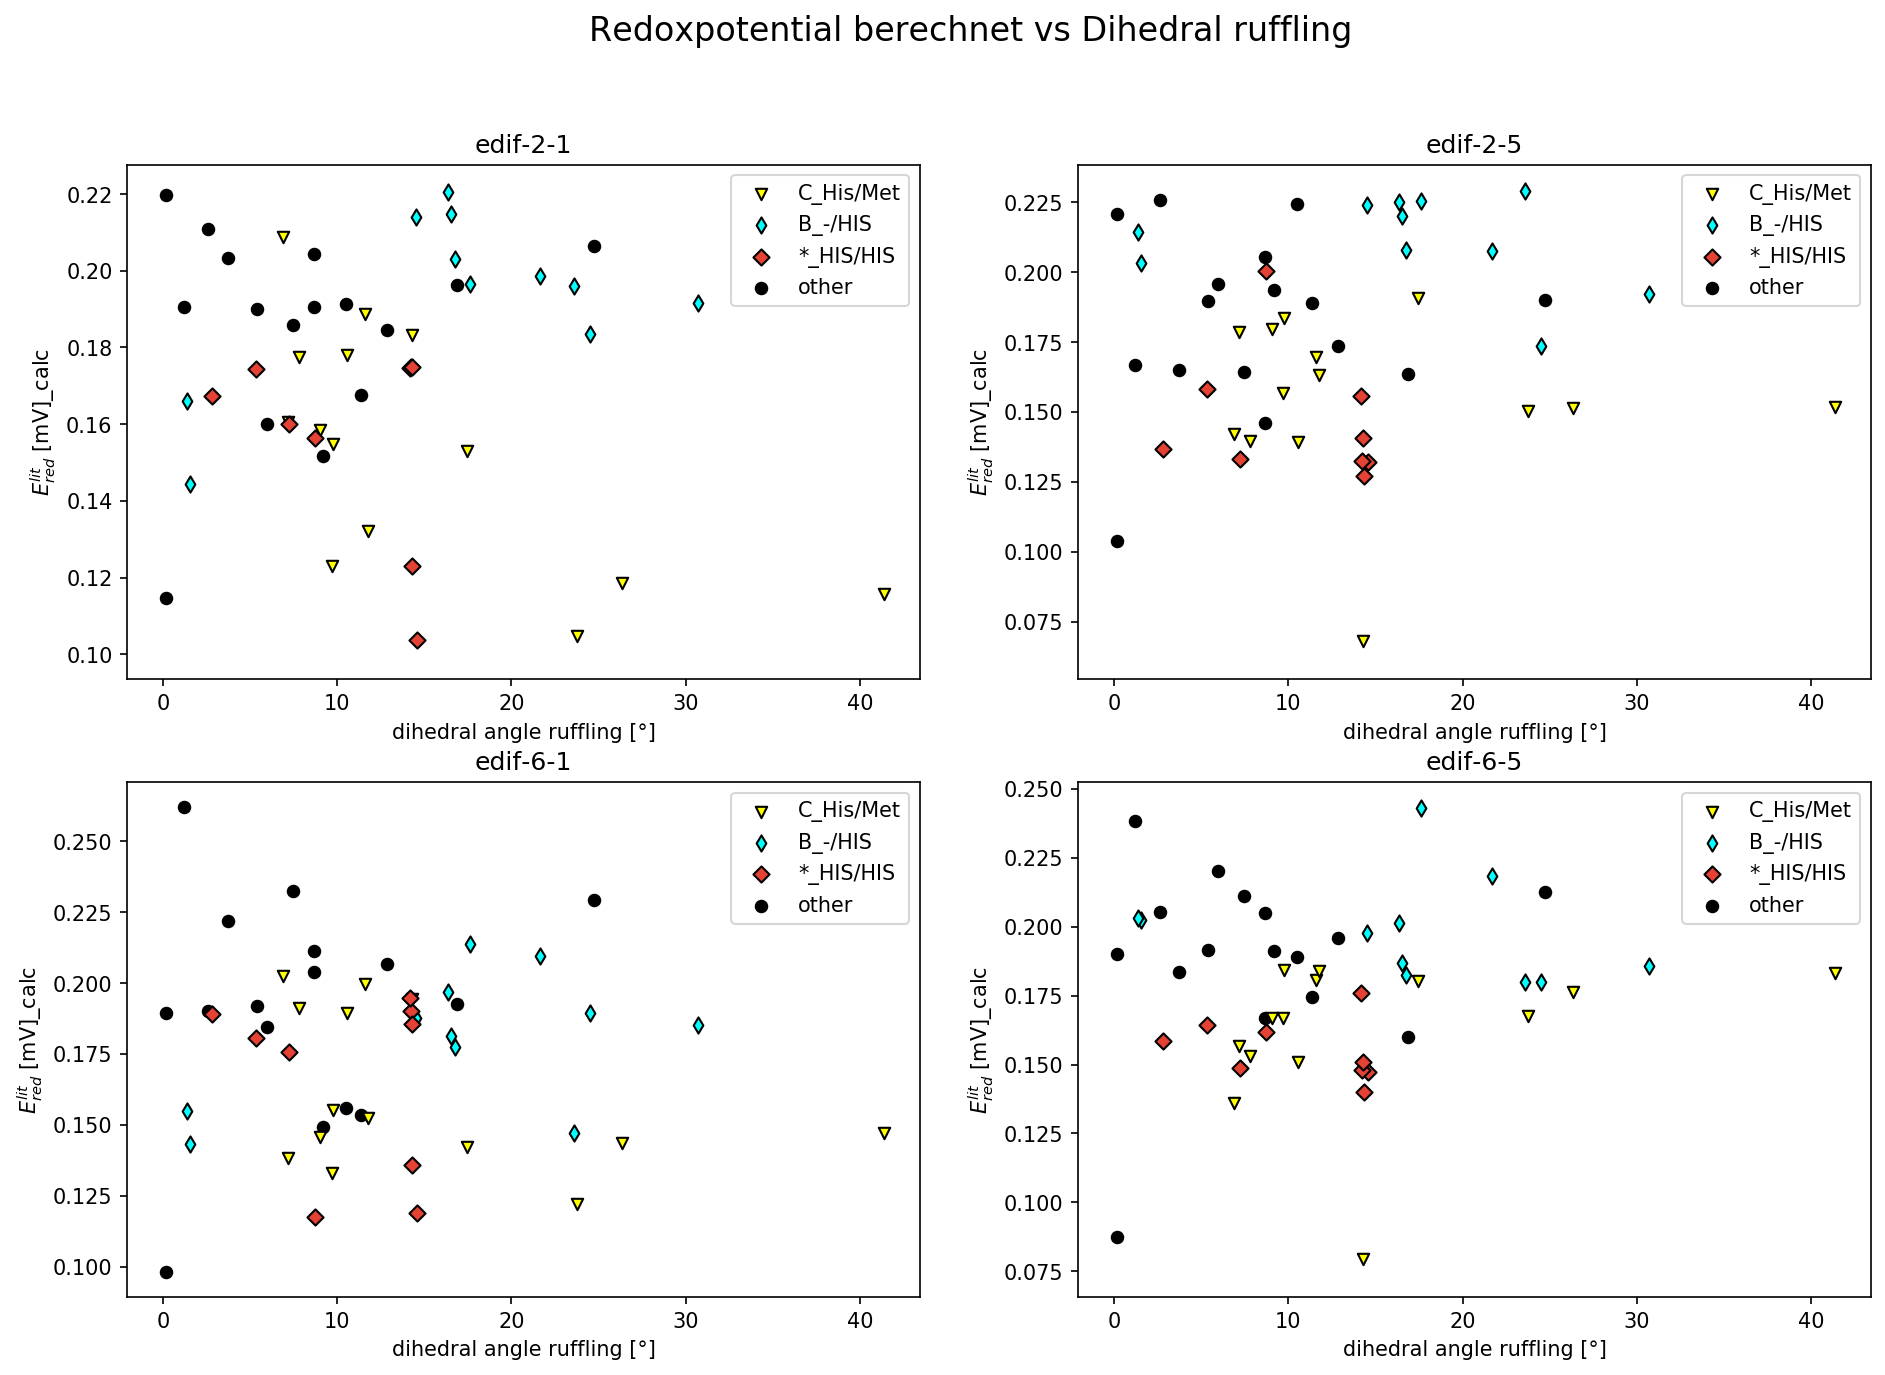

In [90]:
lit = "ruffling"



if(True):
    fig = plt.figure(dpi=150, figsize=(15,10))
    fig.suptitle("Redoxpotential berechnet vs Dihedral ruffling",fontsize =16)

    for i,c in enumerate ([i for i in  df_work2.columns if "edif-" in i]):
        print(c)
        plt.subplot(2,2,i+1)
        df = df_work2[df_work2[c]>0]
        plt.title(c)
        scatterkat(df,lit,c,Kategorie)
        plt.xlabel(dihedruf)
        plt.ylabel(f"{redox}_calc")
        plt.legend()
else:        
    c = "edif-2-1"
    print(c)
    fig = plt.figure(dpi=150)
    df = df_work2[df_work2[c]>0]
    plt.title(f"{edif} vs  {dihedruf}" )#, fontsize=16)
    scatterkat(df,lit,c,Kategorie)
    plt.xlabel(dihedruf)
    plt.ylabel(f"{redox}_calc")  
    plt.legend()

fig.savefig(f"{plots}edif_{lit}.png")
print(f"{plots}edif_{lit}.png")

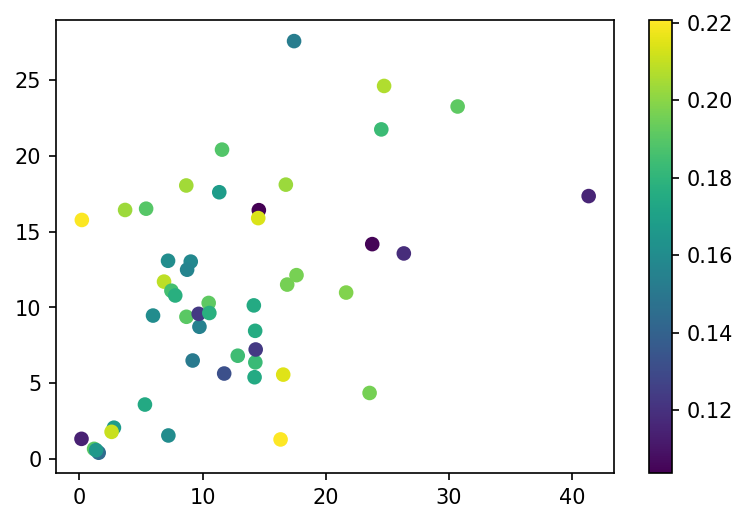

In [91]:
plt.figure(dpi=150)
df = df_work2.copy()
edif  = "edif-2-1"
#edif  = "edif-2-5"
df = df[df[edif]>0]
df2 = df.copy()
plt.scatter(df["ruffling"],df["saddling"],c =df[edif])
plt.colorbar()

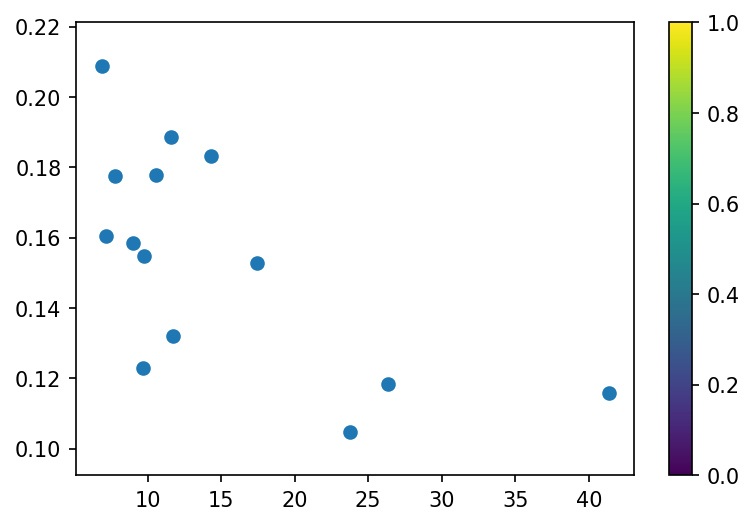

In [92]:
plt.figure(dpi=150)
df = df_work2.copy()
df = df[df["Kategorie2"]==CHM]
edif  = "edif-2-1"
#edif  = "edif-2-5"
df = df[df[edif]>0]
df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    plt.scatter(df["ruffling"],df[edif])#,c =df[edif])
plt.colorbar()

No handles with labels found to put in legend.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


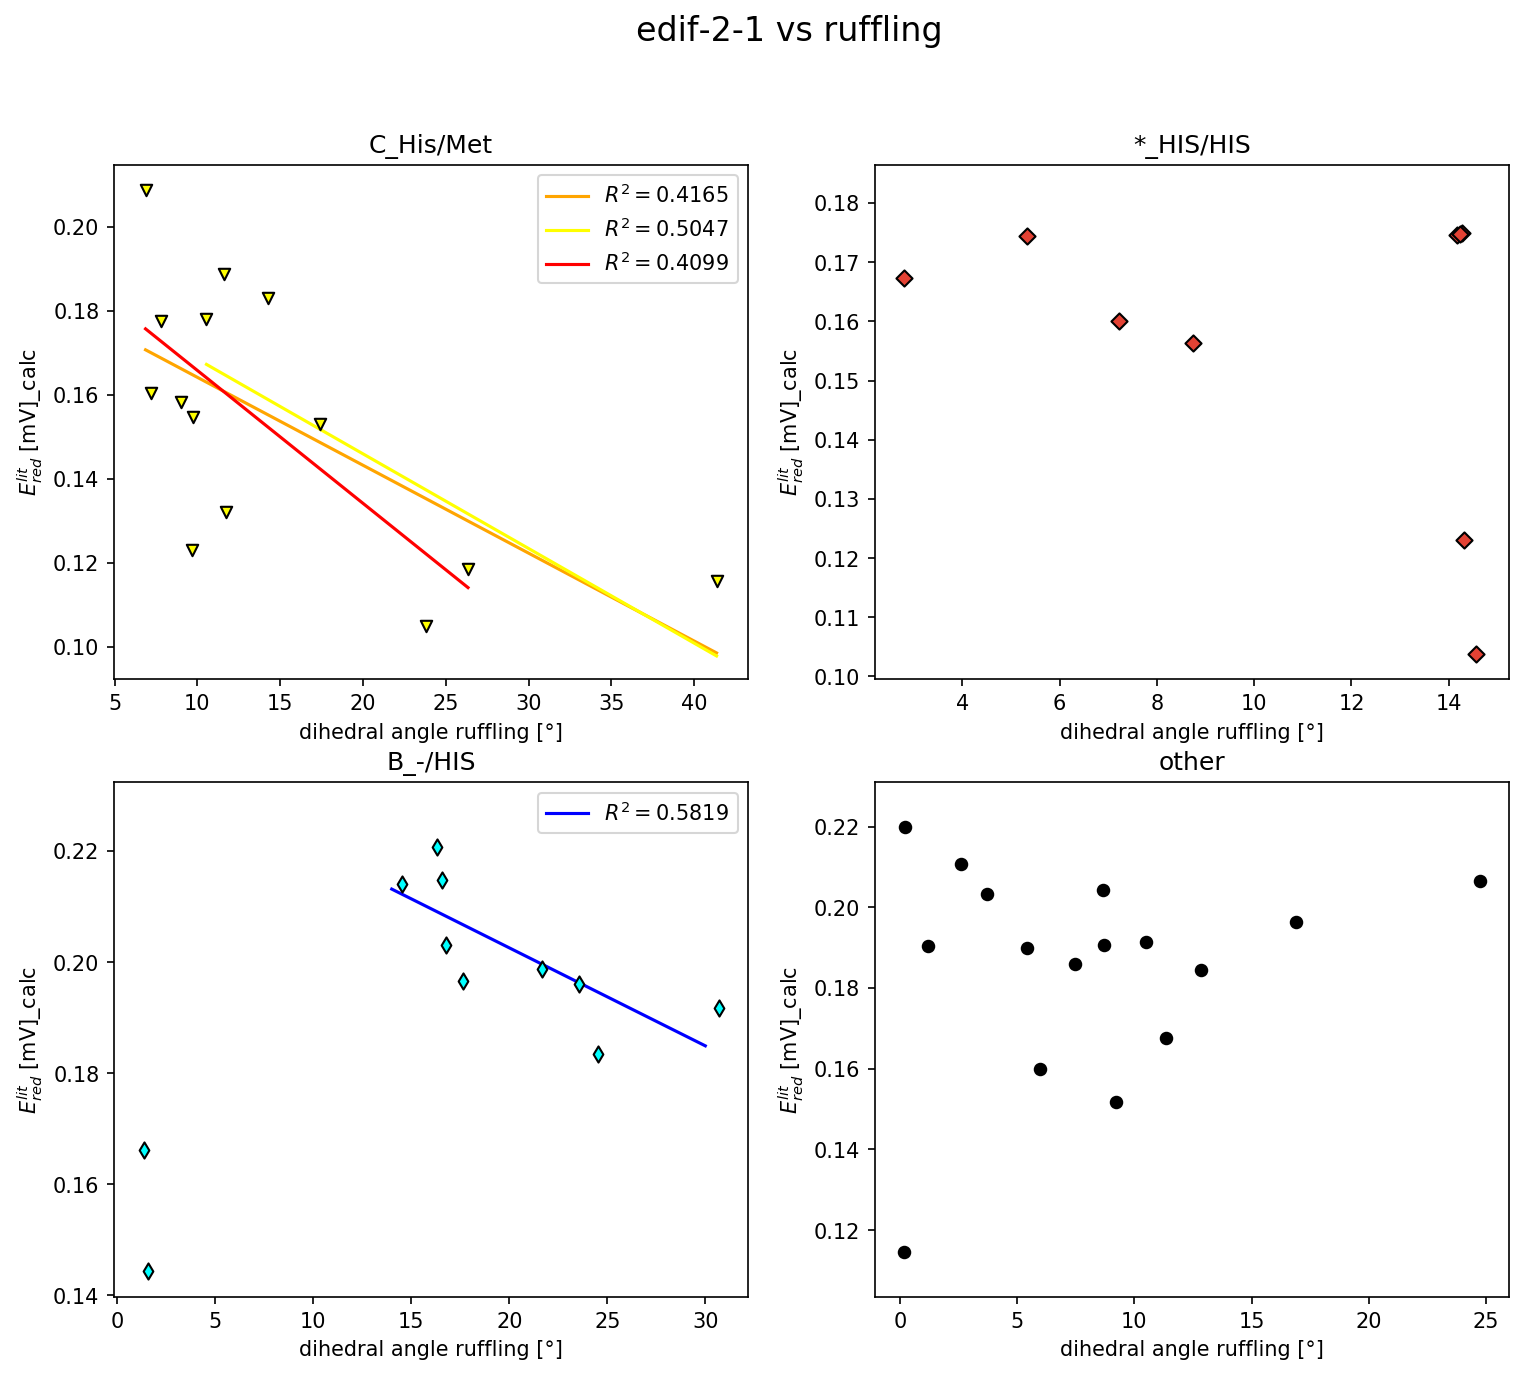

In [93]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)



model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )

df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )













df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df = df[df[edif]>0]

#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
#plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])
plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])#,c =df[edif])

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
plt.legend()
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["Hemetyp"].value_counts().index):
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    #plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
    plt.scatter(df["ruffling"],df[edif],**scatterdict[kat])#,c =df[edif])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"pink"}[a1])

#plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a1,a in enumerate (df2["ax_qn"].value_counts().index):
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

   # plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])
    plt.scatter(df["ruffling"],df[edif], **scatterdict[kat])
    #plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat],c={0:scatterdict[kat]["facecolor"],1:"blue"}[a1])

    
    
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
x = np.linspace(14,30)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "blue",label=f"$R^2 = ${np.round(model.score(X,y),4)}" )
plt.legend()


plt.subplot(224)
kat = "other"
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.scatter(df["ruffling"],df[edif], label = a,**scatterdict[kat])#,c =df[edif])
#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])
#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
fig.savefig(f"{plots}edif21.png")

In [94]:
X.shape

(9, 1)

Text(0, 0.5, '$E_{red}^{lit}$ [mV]_calc')

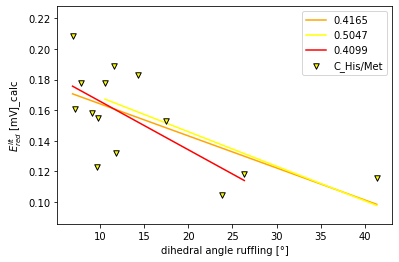

In [95]:
kat = CHM
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
plt.scatter(df["ruffling"],df[edif], label = kat,**scatterdict[kat])#,c =df[edif])

#plt.scatter(df["ruffling"],df[edif],edgecolor = "black")


#df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "orange",label=np.round(model.score(X,y),4))

df = df[df["ruffling"]>10]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "yellow",label=np.round(model.score(X,y),4))

df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
df = df[df["ruffling"]<30]
model = LinearRegression()
X= df[["ruffling"]].values
y = df[[edif]].values
model.fit(X,y)
xmin =df["ruffling"].min()
xmax=df["ruffling"].max()
x = np.linspace(xmin,xmax)
plt.plot(x,model.predict(x.reshape(len(x),1)),c= "red",label=np.round(model.score(X,y),4))


plt.xlabel(dihedruf)
plt.legend()
plt.ylabel(f"{redox}_calc")



#plt.xlim(-4,40)
#plt.ylim([0.1,0.24])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


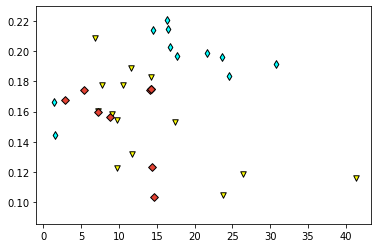

In [96]:
df = df_work2.copy()
df = df[df["Kategorie2"]!="other"]

scatterkat(df,"ruffling",edif,Kategorie)

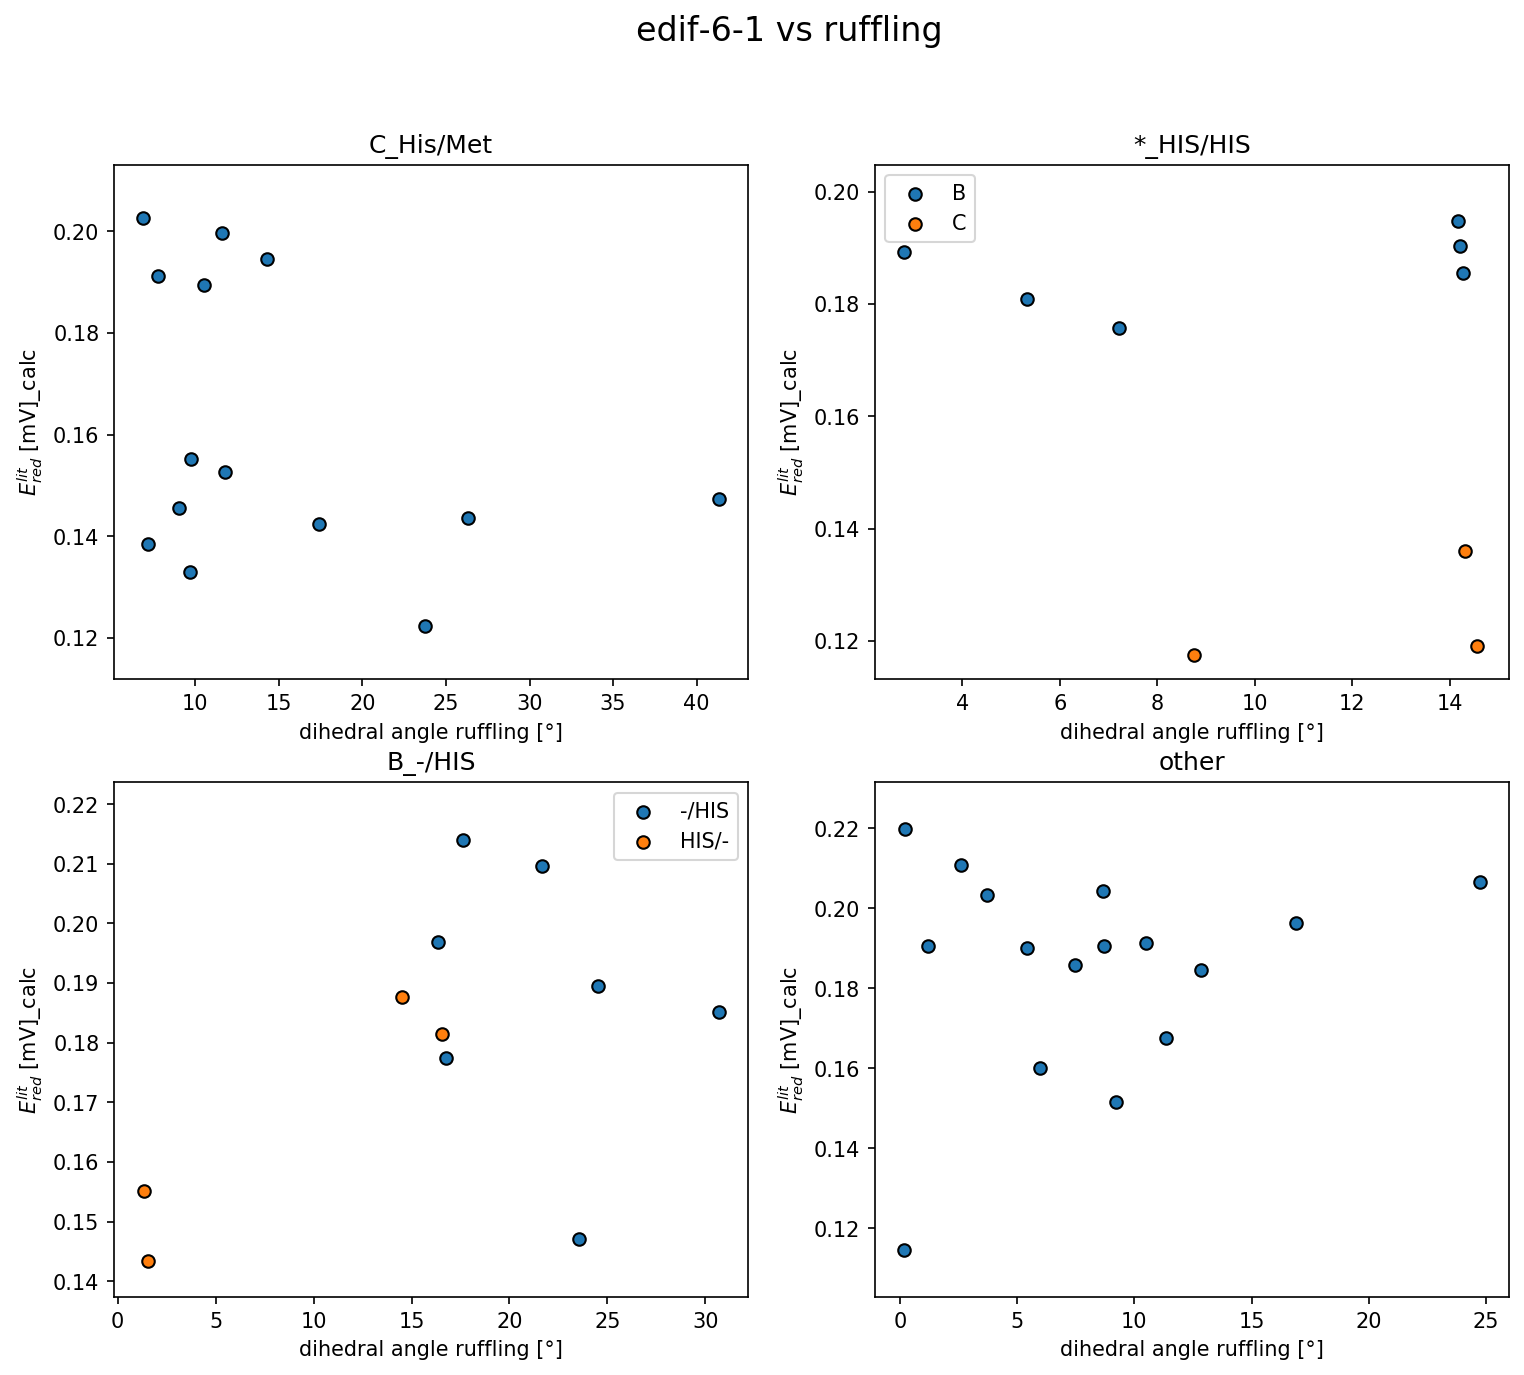

In [97]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

edif  = "edif-6-1"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)

df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")

plt.subplot(224)
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

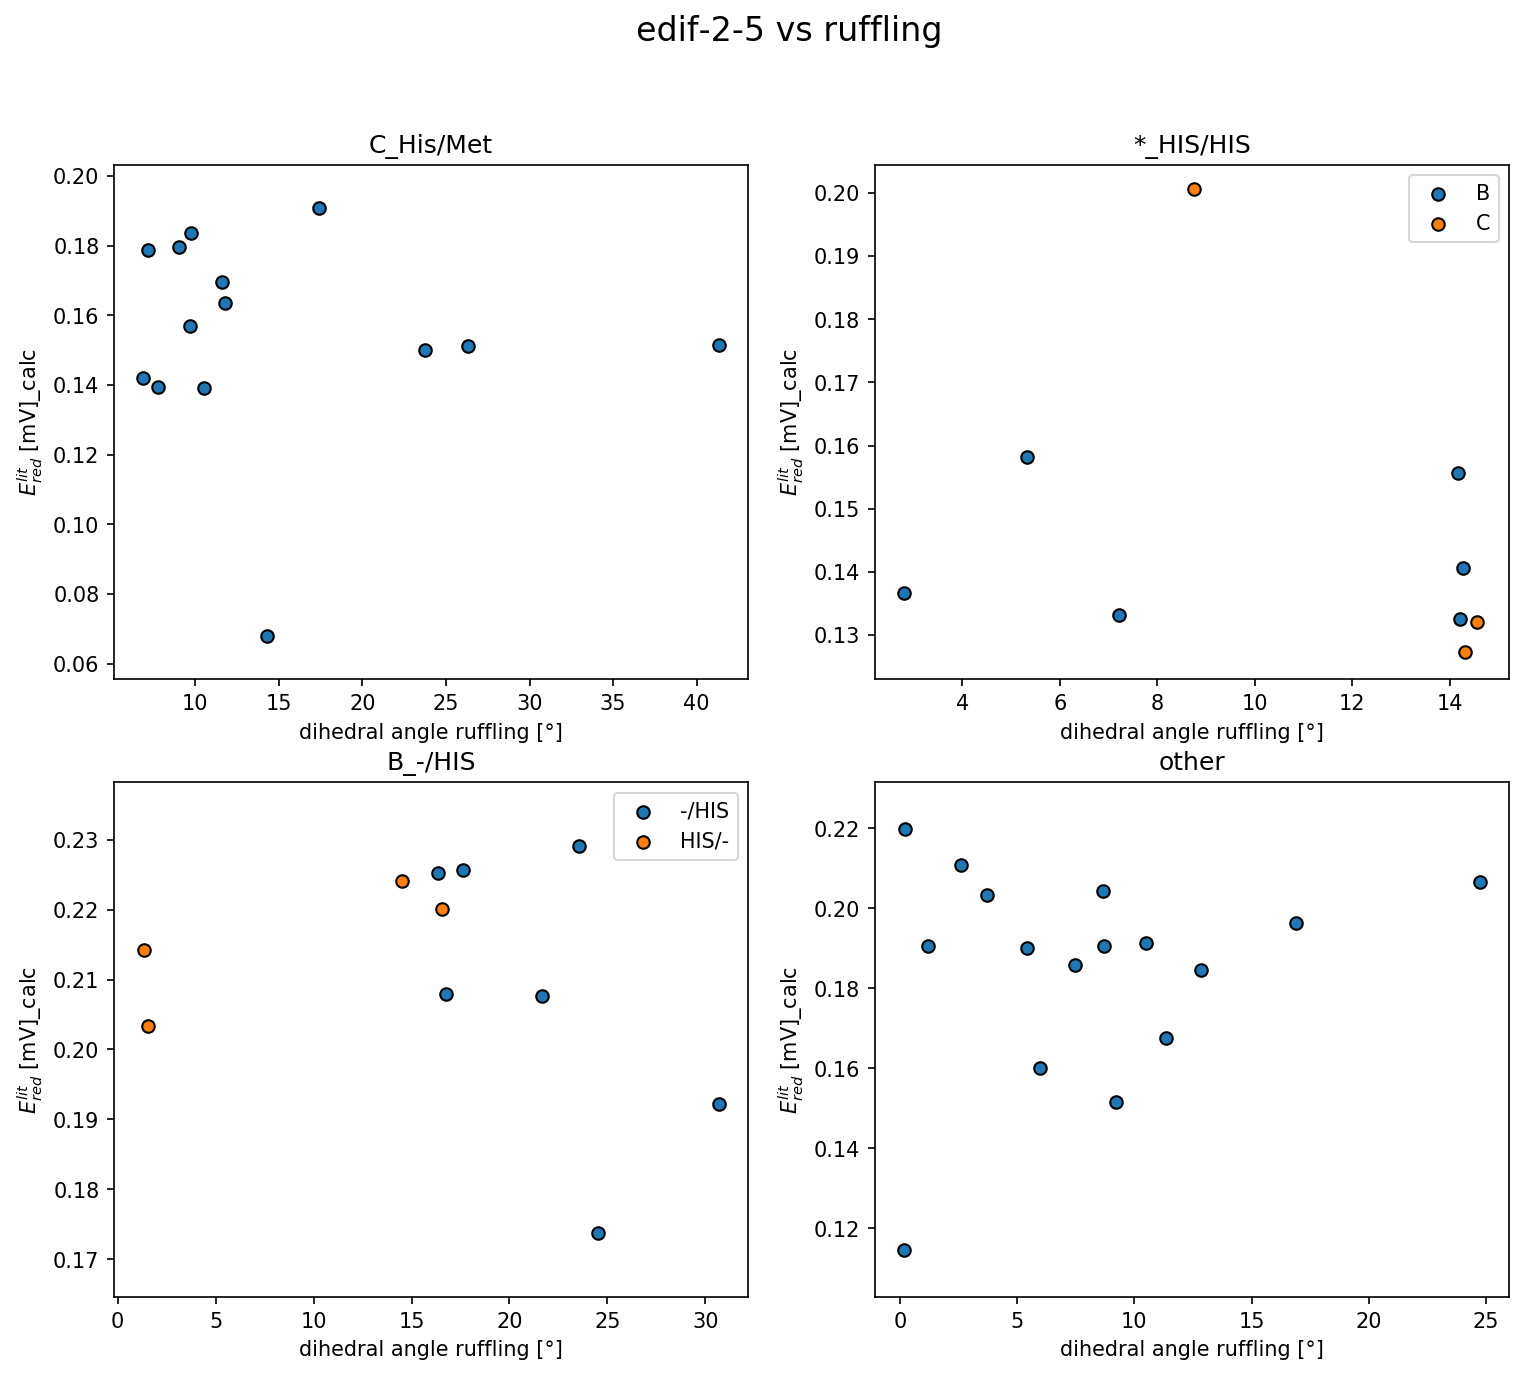

In [98]:
fig = plt.figure(dpi = 150,figsize=[12,10])
plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-5"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)

df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")

plt.subplot(224)
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

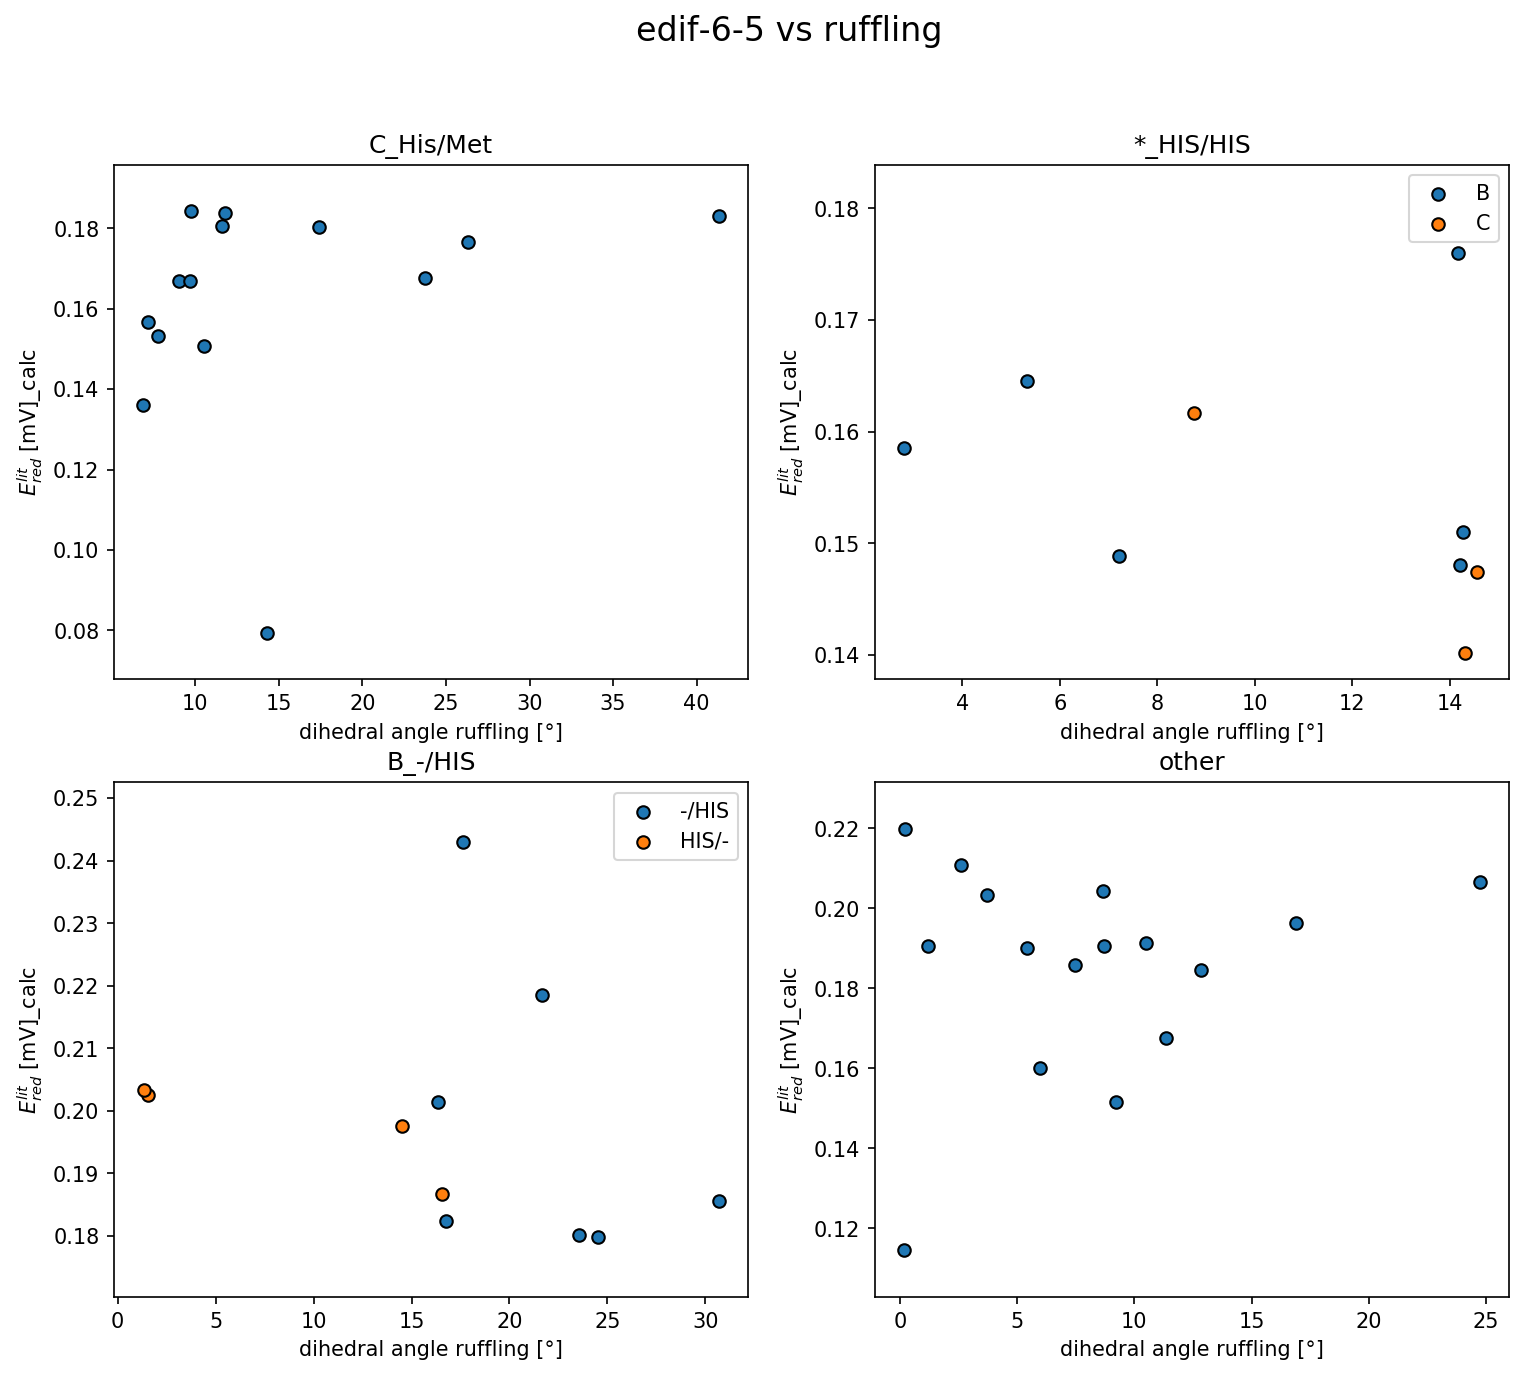

In [99]:
fig = plt.figure(dpi = 150,figsize=[12,10])


plt.subplot(221)
kat = CHM
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-6-5"
fig.suptitle(f"{edif} vs ruffling",fontsize =16)
df = df[df[edif]>0]

plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(222)
kat = HH
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["Hemetyp"].value_counts().index:
    df = df2[df2["Hemetyp"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.subplot(223)
kat = BHIS
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]

df2 = df.copy()
for a in df2["ax_qn"].value_counts().index:
    df = df2[df2["ax_qn"]==a]
    df = df[df[edif]>0]

    plt.scatter(df["ruffling"],df[edif], label = a,edgecolor = "black")#,c =df[edif])
plt.legend()

plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")


plt.subplot(224)
kat = "other"
plt.title(kat)
df = df_work2.copy()
df = df[df["Kategorie2"]==kat]
edif  = "edif-2-1"
df = df[df[edif]>0]
plt.xlabel(dihedruf)
plt.ylabel(f"{redox}_calc")
plt.scatter(df["ruffling"],df[edif],edgecolor = "black")

In [100]:
df = dflg[dflg["ax_qn"] =="HIS/-"]
df[["ruffling","saddling","Em_lit","ud","Hemetyp"]]

ruffling   saddling  Em_lit  ud Hemetyp
pdb                                           
1A6K  14.519887  15.892665    50.0  ud       B
1DRM  16.548711   5.573944    68.0  ud       B
1FLP  17.245902  14.236266   103.0  ud       B
1JP6   1.566411   0.423901    50.0  ud       B
1JP9   1.356857   0.593972    50.0  ud       B

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

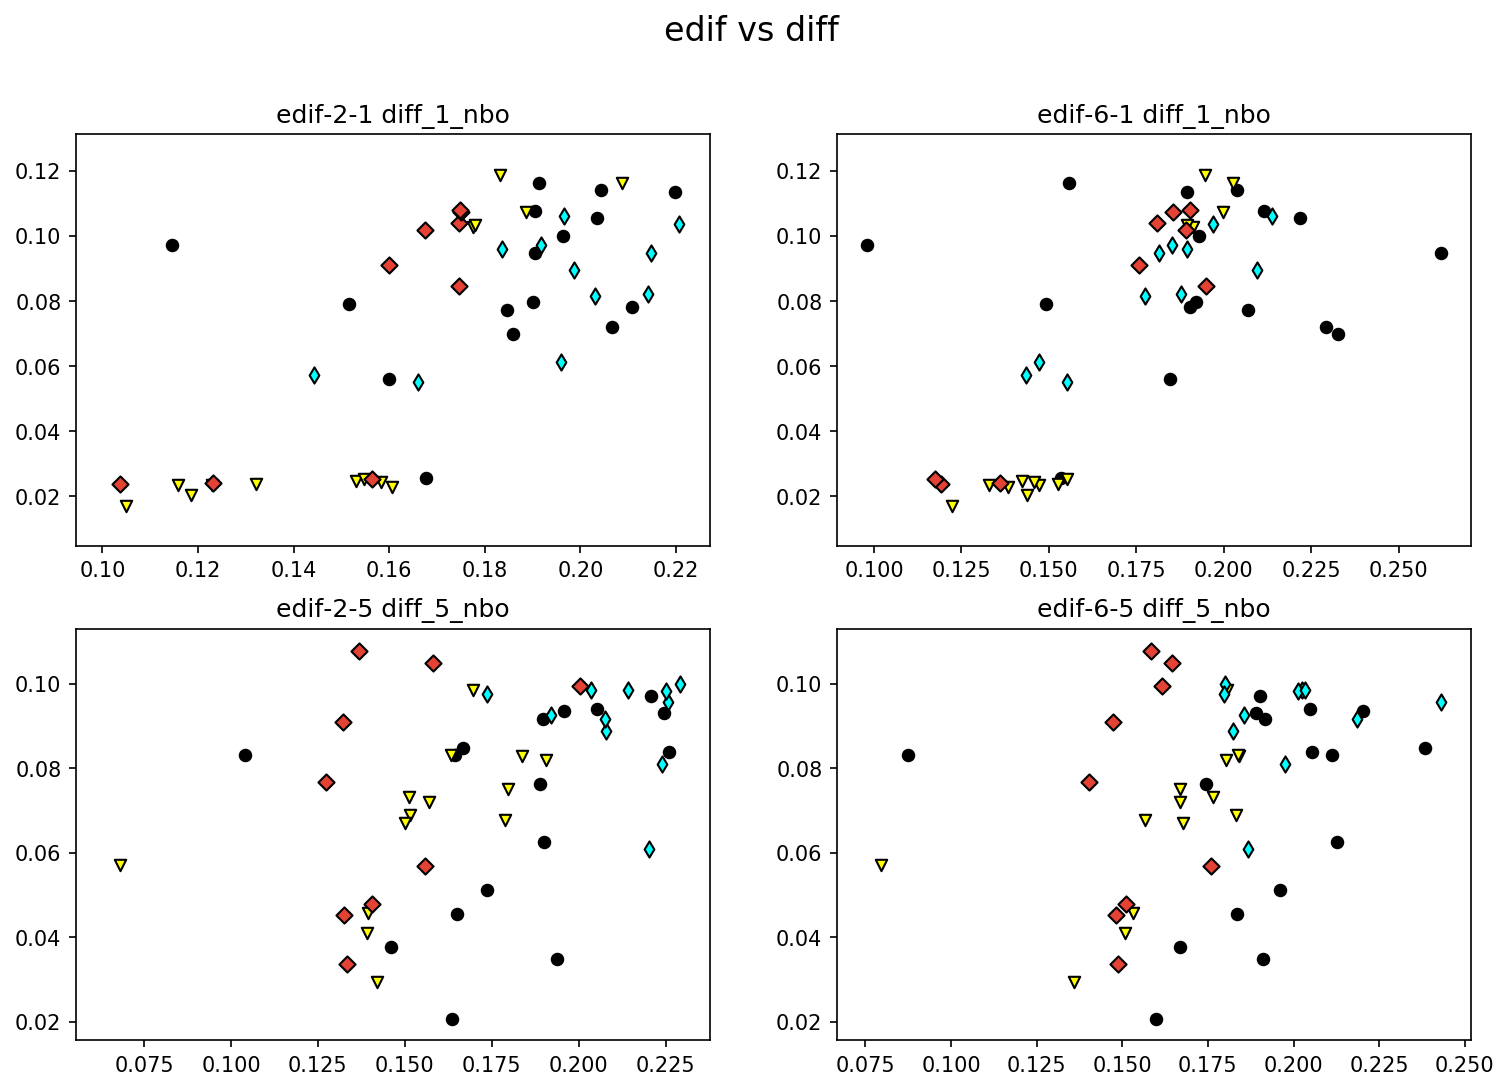

In [101]:
fig = plt.figure(dpi = 150,figsize=[12,8])
fig.suptitle('edif vs diff', fontsize=16)

plt.subplot(221)
edif = "edif-2-1"
diff = "diff_1_nbo"
plt.title(edif +" "+diff)
df = df_work2.copy()
df = df[df[edif]>0]
#plt.scatter(df[edif],df[diff],c= Colorbar["other"])
scatterkat(df,edif,diff,Kategorie)

plt.subplot(222)
edif = "edif-6-1"
diff = "diff_1_nbo"
plt.title(edif +" "+diff)

df = df_work2.copy()
df = df[df[edif]>0]
#plt.scatter(df[edif],df[diff],c= Colorbar["other"])
scatterkat(df,edif,diff,Kategorie)

plt.subplot(223)
edif = "edif-2-5"
diff = "diff_5_nbo"
plt.title(edif +" "+diff)

df = df_work2.copy()
df = df[df[edif]>0]
#plt.scatter(df[edif],df[diff],c= Colorbar["other"])
scatterkat(df,edif,diff,Kategorie)

plt.subplot(224)
edif = "edif-6-5"
diff = "diff_5_nbo"
plt.title(edif +" "+diff)

df = df_work2.copy()
df = df[df[edif]>0]
#plt.scatter(df[edif],df[diff],c= Colorbar["other"])
scatterkat(df,edif,diff,Kategorie)


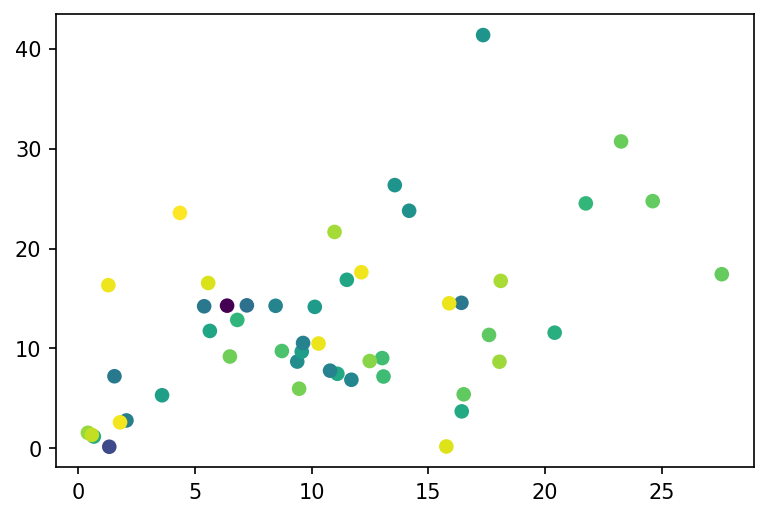

In [102]:
plt.figure(dpi=150)
edif = "edif-2-5"
df = df_work2.copy()
df = df[df[edif]>0]
plt.scatter(df["saddling"],df["ruffling"],c = df[edif])

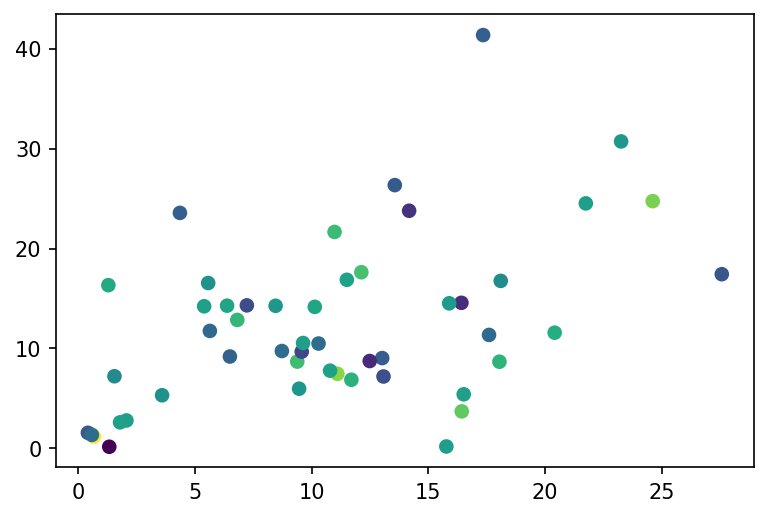

In [103]:
plt.figure(dpi=150)
edif = "edif-6-1"
df = df_work2.copy()
df = df[df[edif]>0]
plt.scatter(df["saddling"],df["ruffling"],c = df[edif])

Text(0, 0.5, 'dihedral angle ruffling [°]')

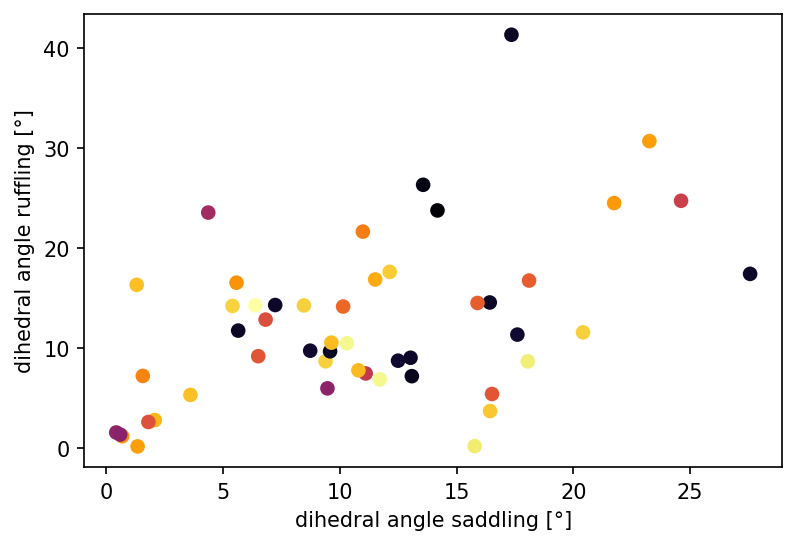

In [104]:
fig = plt.figure(dpi = 150)
#scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.scatter(df_work2["saddling"],df_work2["ruffling"],c = df_work2["diff_1_nbo"],cmap =cmap1)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)

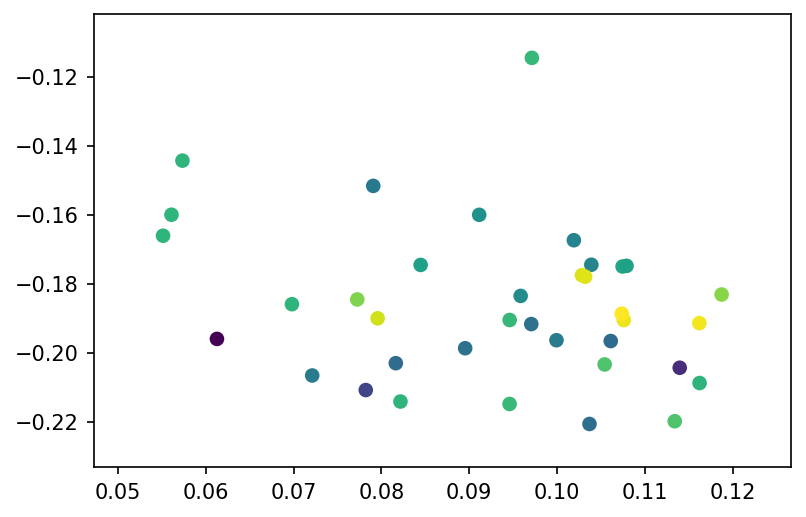

In [105]:
df = df_work2.copy()
df["redpot"] = df["e_1_nbo"] -df["e_2_nbo"]
fig = plt.figure(dpi = 150)

df = df[df["redpot"]<2] #-1]
df = df[df["diff_1_nbo"]>0.03]
plt.scatter(df["diff_1_nbo"],df["redpot"],c = df["Em_lit"])


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

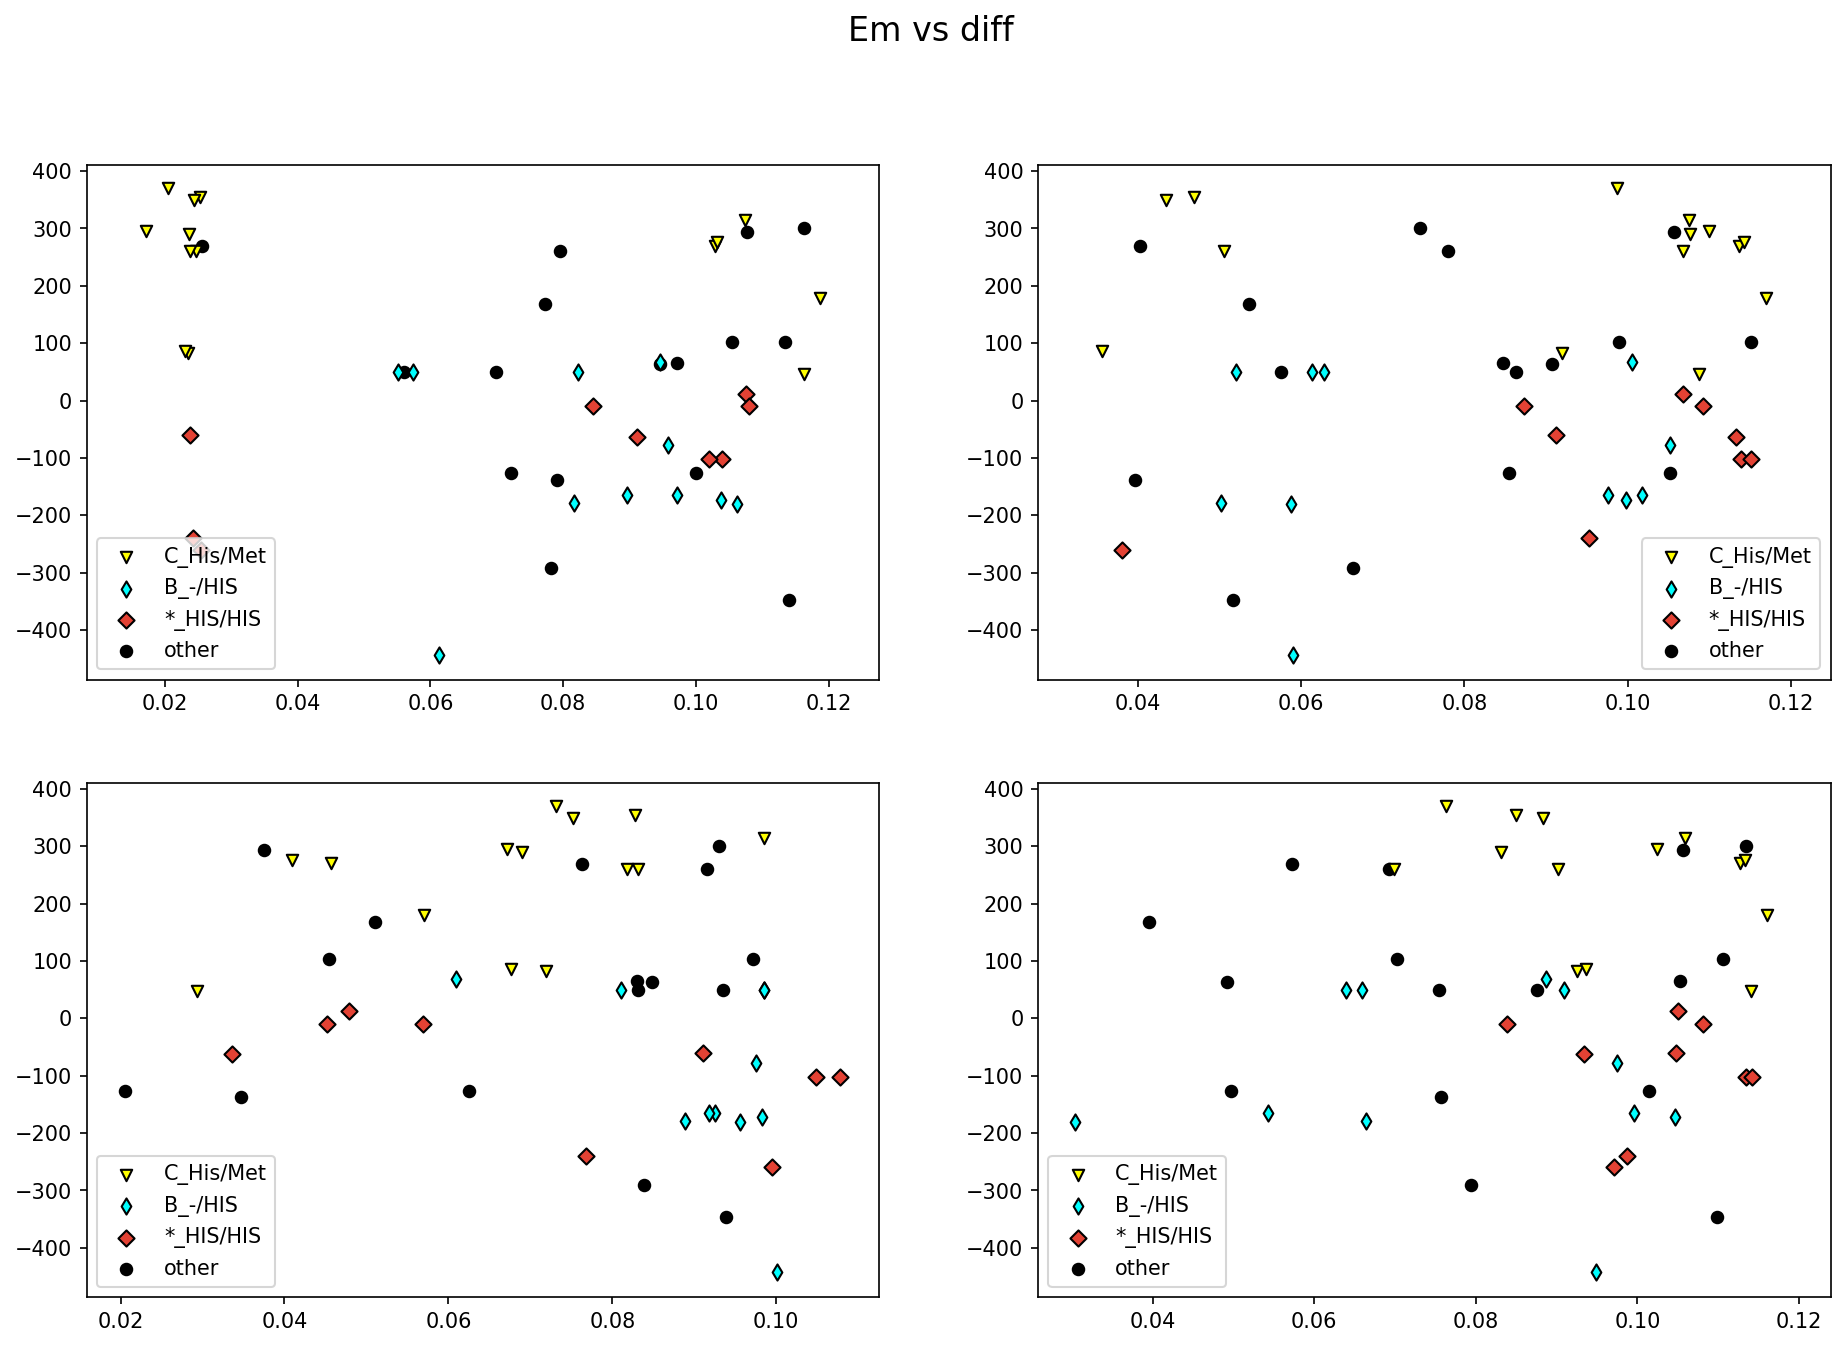

In [106]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(2,2,i)
    scatterkat(df_work2,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
fig.savefig(f"{plots}Em_diff.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

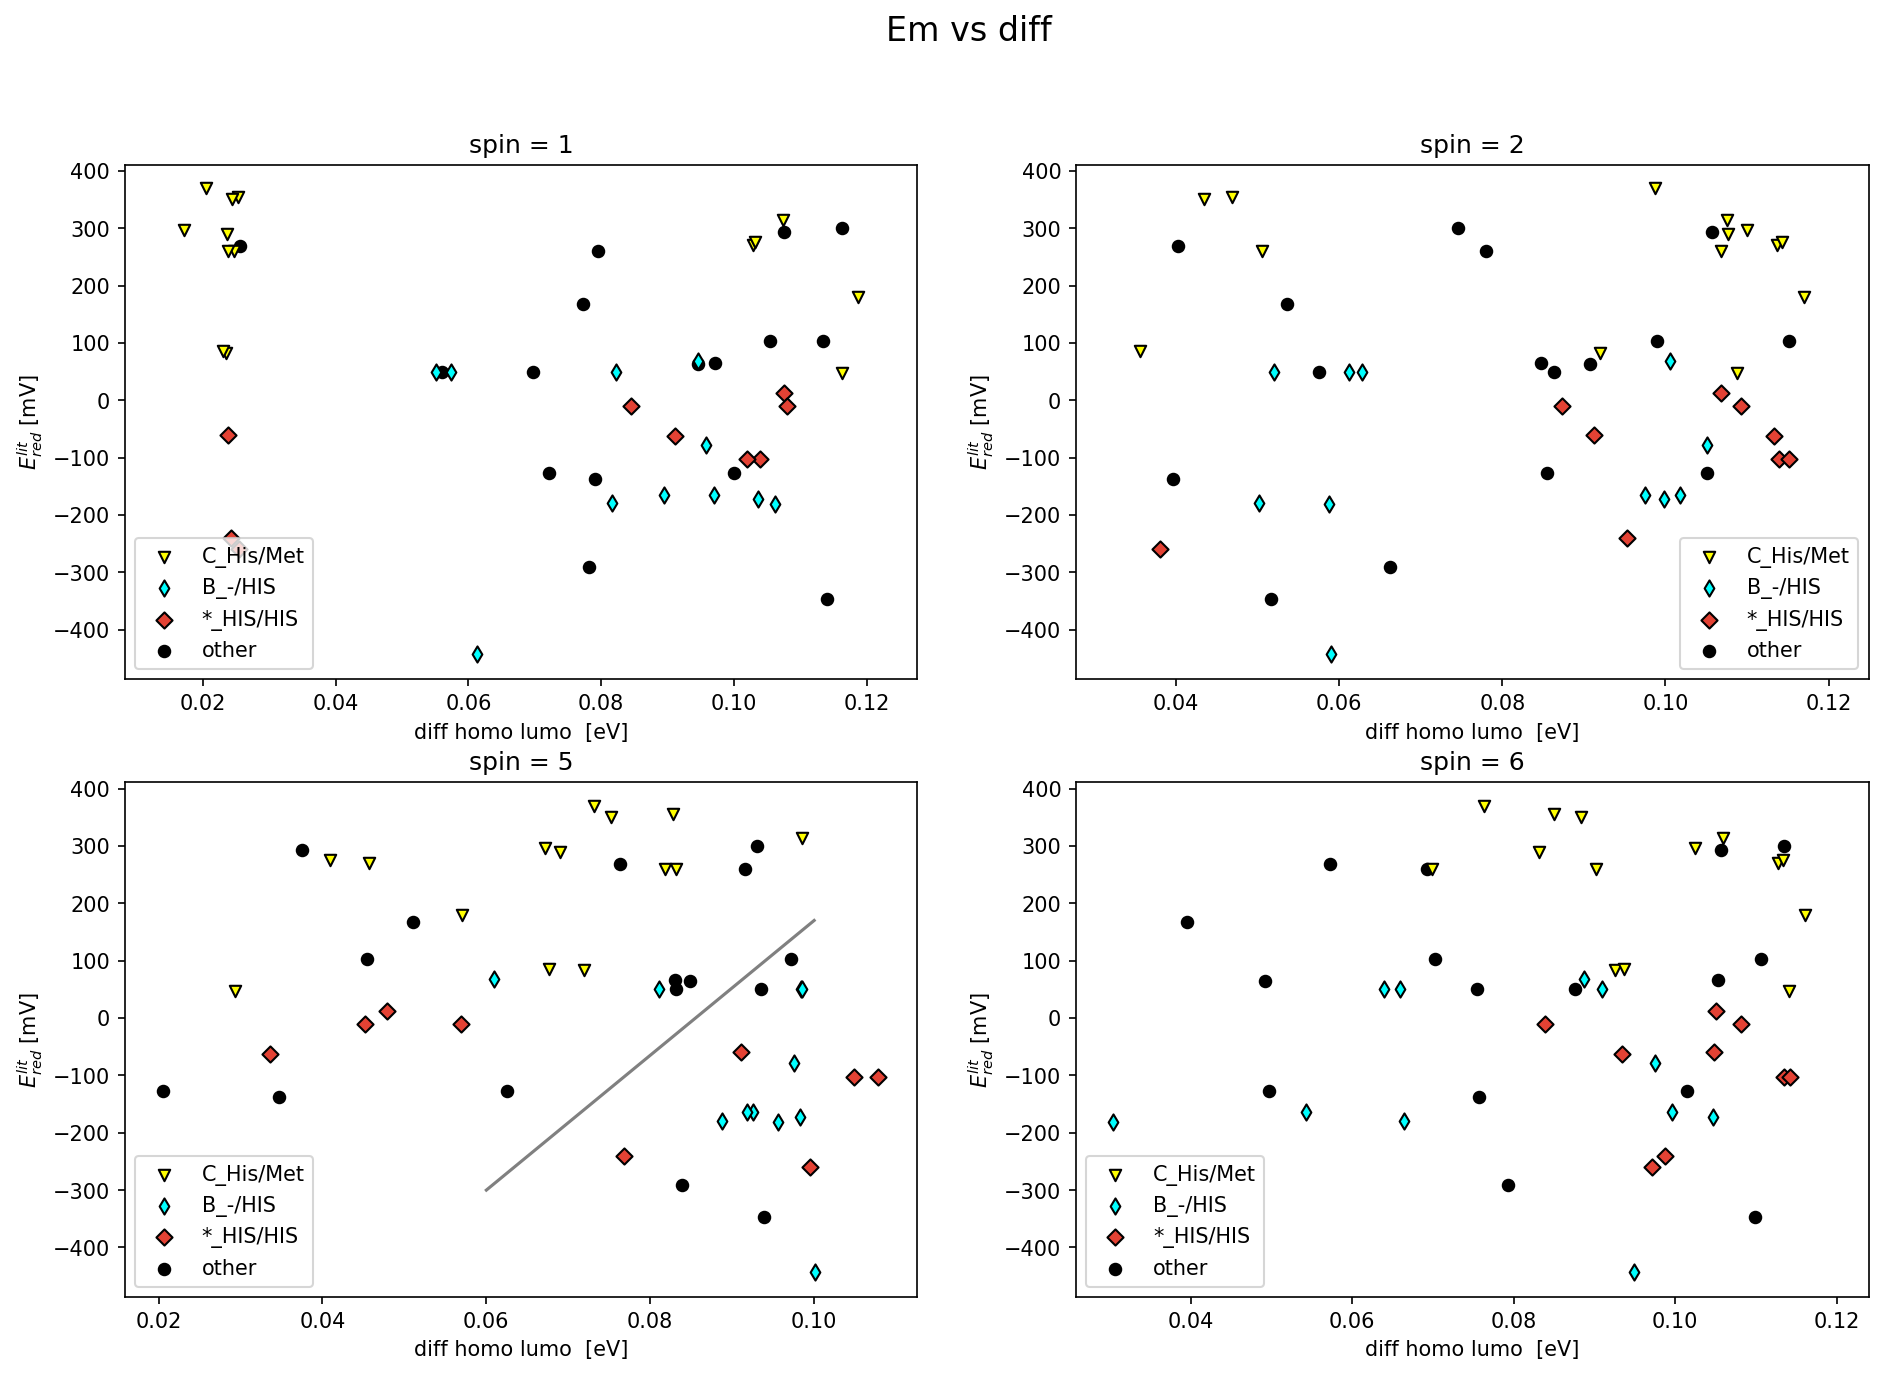

In [107]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    #df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.04]
    df = df_work2
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(2,2,i)
    plt.ylabel(redox)
    plt.title(f"spin = {s}")
    plt.xlabel(f"diff homo lumo {Energie}")    
    scatterkat(df,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
    if s ==5:
        plt.plot([0.06,0.1], [-300,170], c = "grey")
    
fig.savefig(f"{plots}Em_diff.png")        

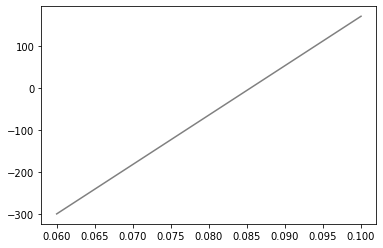

In [108]:
plt.plot([0.06,0.1], [-300,170], c = "grey")

### clusteranalyse fpr diff vs emlit

In [109]:
x = np.array([0.06,0.1]).reshape(-1, 1)
y = np.array([-300,170]).reshape(-1, 1)
model = LinearRegression()
model.fit(x,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

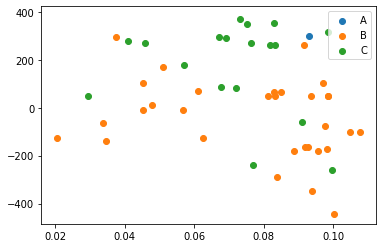

In [110]:
df  = df_work2.copy()
for H  in ["A","B","C"]:
    df  = df_work2.copy()    
    df = df[df["Hemetyp"]==H]
    plt.scatter(df["diff_5_nbo"], df["Em_lit"],label=H)
plt.legend()

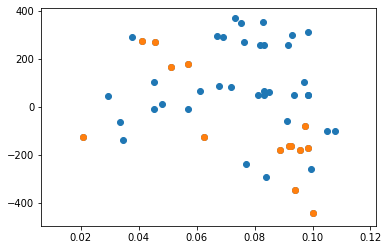

In [111]:
df  = df_work2.copy()
plt.scatter(df["diff_5_nbo"], df["Em_lit"])

df = df[df["ud"]=="uu"]
plt.scatter(df["diff_5_nbo"], df["Em_lit"])


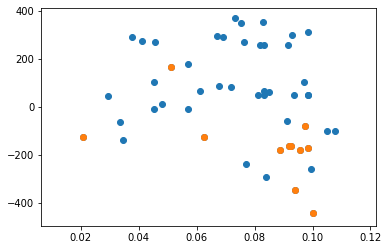

In [112]:
df  = df_work2.copy()
plt.scatter(df["diff_5_nbo"], df["Em_lit"])
df = df[df["Hemetyp"] == "B"]
df = df[df["ud"] =="uu"]
plt.scatter(df["diff_5_nbo"], df["Em_lit"])

df  = df_work2.copy()




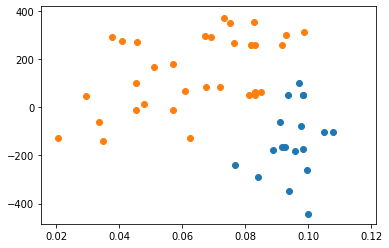

In [113]:
df  = df_work2.copy()

df["cluster"] = [(model.predict([[d]])>e)[0][0] for d,e in zip(df["diff_5_nbo"], df["Em_lit"])]
#plt.scatter(df["diff_5_nbo"], df["Em_lit"])
df1 = df[df["cluster"]]
plt.scatter(df1["diff_5_nbo"], df1["Em_lit"])
df2 = df[df["cluster"]==False]
plt.scatter(df2["diff_5_nbo"], df2["Em_lit"])




In [114]:
df1[["ligup","ligdown","Hemetyp","ud"]]
#df1["ax_qn"].value_counts()

ligup ligdown Hemetyp  ud
pdb                           
1CMQ     -     HIS       B  uu
1GU2   HIS     HIS       C  ud
1JP6   HIS       -       B  ud
1FHF     -     HIS       B  uu
1MZ4   HIS     HIS       C  du
1CCC     -     HIS       B  uu
1CCK     -     HIS       B  uu
1AW3   HIS     HIS       B  du
1EBT   HIS      CN       B  ud
1B5A   HIS     HIS       B  du
1F1C   HIS     HIS       C  du
1NSI   ARG     CYS       B  uu
1JBQ   HIS     CYS       B  dd
3CCX     -     HIS       B  uu
1CMT     -     HIS       B  uu
1A6M   HIS      O2       B  ud
1DJ1     -     HIS       B  uu
1JP9   HIS       -       B  ud

In [115]:
df2[["ligup","ligdown","Hemetyp","ud"]]
#df2["ax_qn"].value_counts()

ligup ligdown Hemetyp  ud
pdb                           
1YCC   MET     HIS       C  du
1CYI   MET     HIS       C  du
1CCG     -     IMD       B  uu
1HRC   MET     HIS       C  du
1CCE     -       -       B  uu
6U97   MET     HIS       C  uu
1MOH   HIS     HSH       B  ud
1A6K   HIS       -       B  ud
1C75   MET     HIS       C  du
1CXC   MET     HIS       C  du
1FJ0   MET     HIS       C  du
1CRY   MET     HIS       C  du
1ES1   HIS     HIS       B  dd
2PCB   MET     HIS       B  du
1A6G   HIS      CO       B  ud
1QPU   MET     HIS       B  uu
1CYO   HIS     HIS       B  dd
2GSM     -     HIS       A  du
1JDL   MET     HIS       B  du
1F1F   MET     HIS       C  du
1CPO   CYS       -       B  du
1V9Z   HIS     MET       B  dd
451C   MET     HIS       C  uu
1VB6   HIS     MET       B  dd
2V07   MET     HIS       C  du
1EHB   HIS     HIS       B  dd
4MU8     -     HIS       C  du
1EUE   HIS     HIS       B  dd
1DRM   HIS       -       B  ud
351C   MET     HIS       C  uu
2CE0   MET     HIS       C  du
1GIW   MET     HIS       C  du

In [116]:
df1["ax_ql"].value_counts()

-/HIS      9
HIS/HIS    5
CYS/HIS    1
HIS/O2     1
CN/HIS     1
ARG/CYS    1
Name: ax_ql, dtype: int64

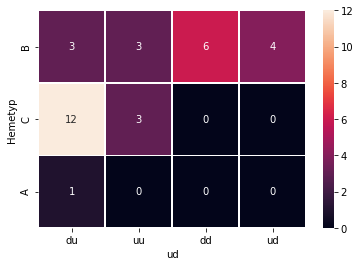

In [117]:
hashmap(df2,"ud","Hemetyp")

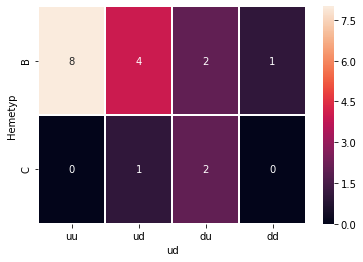

In [118]:
hashmap(df1,"ud","Hemetyp")

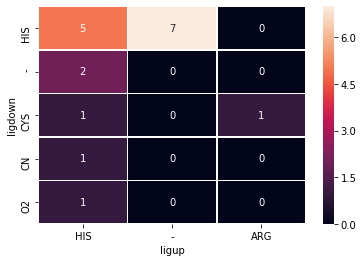

In [119]:
hashmap(df1,"ligup","ligdown")

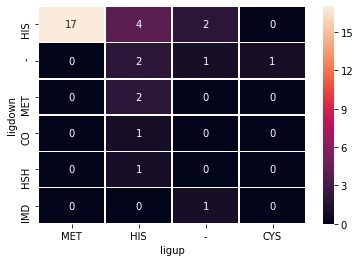

In [120]:
hashmap(df2,"ligup","ligdown")

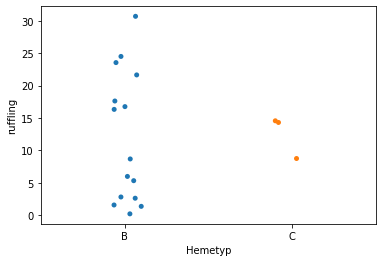

In [121]:
sns.stripplot(data=df1,y = "ruffling",x = "Hemetyp")

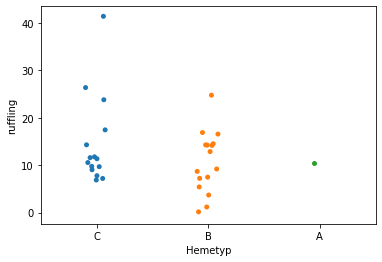

In [122]:
sns.stripplot(data=df2,y = "ruffling",x = "Hemetyp")

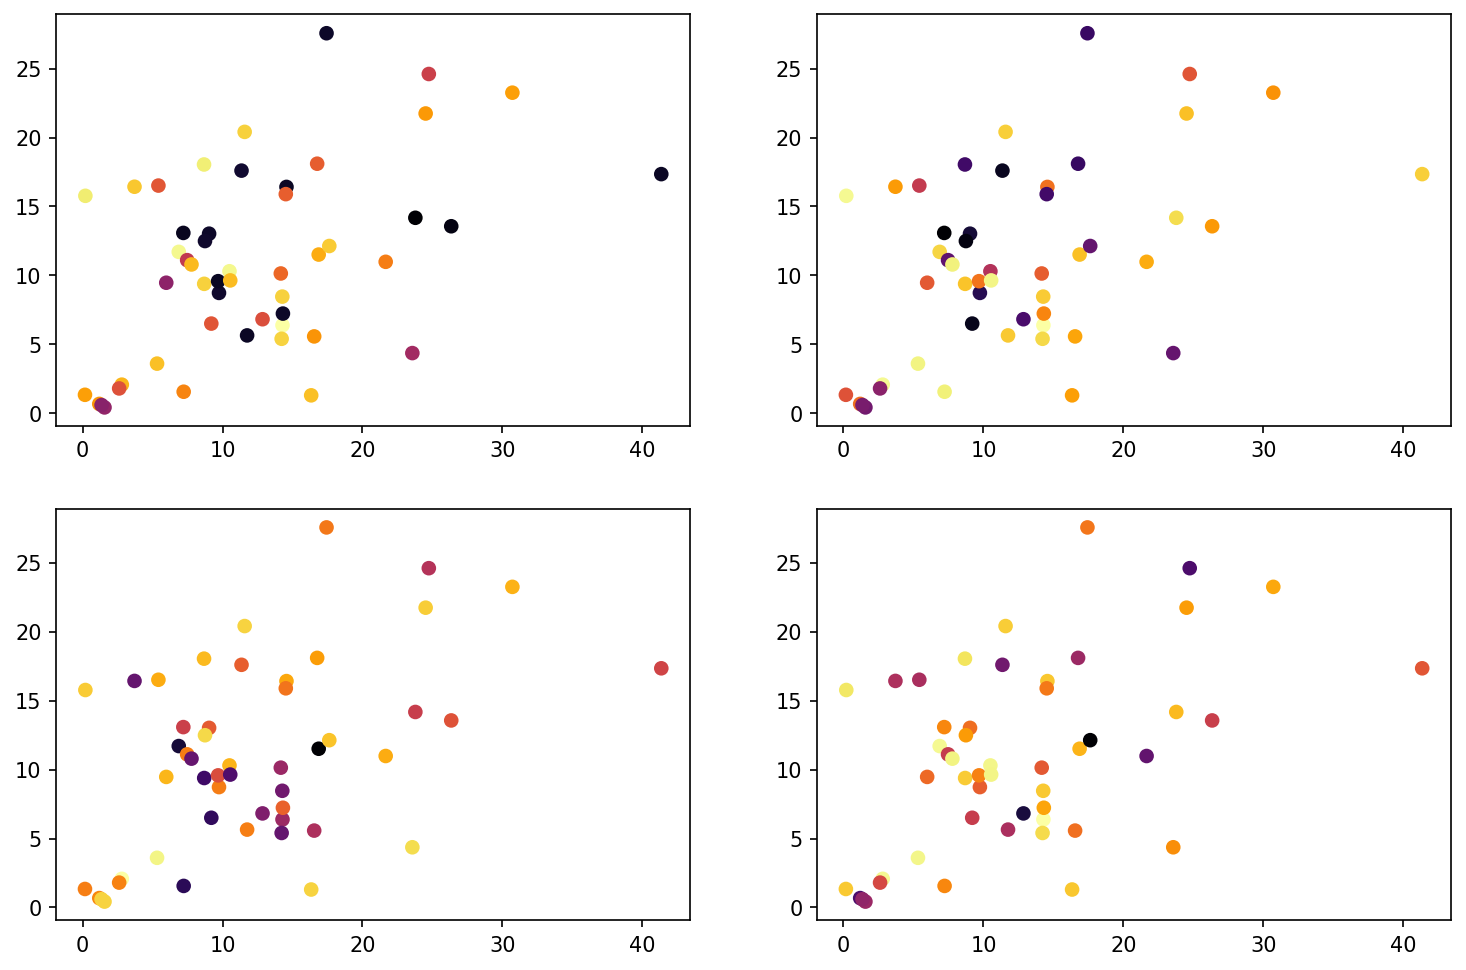

In [123]:
plt.figure(dpi=150, figsize=[12,8])
df = df_work2
for i,s in zip([1,2,3,4],[1,2,5,6]):
    plt.subplot(2,2,i)
    plt.scatter(df["ruffling"], df["saddling"] , c = df[f"diff_{str(s)}_nbo"] ,cmap =cmap1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

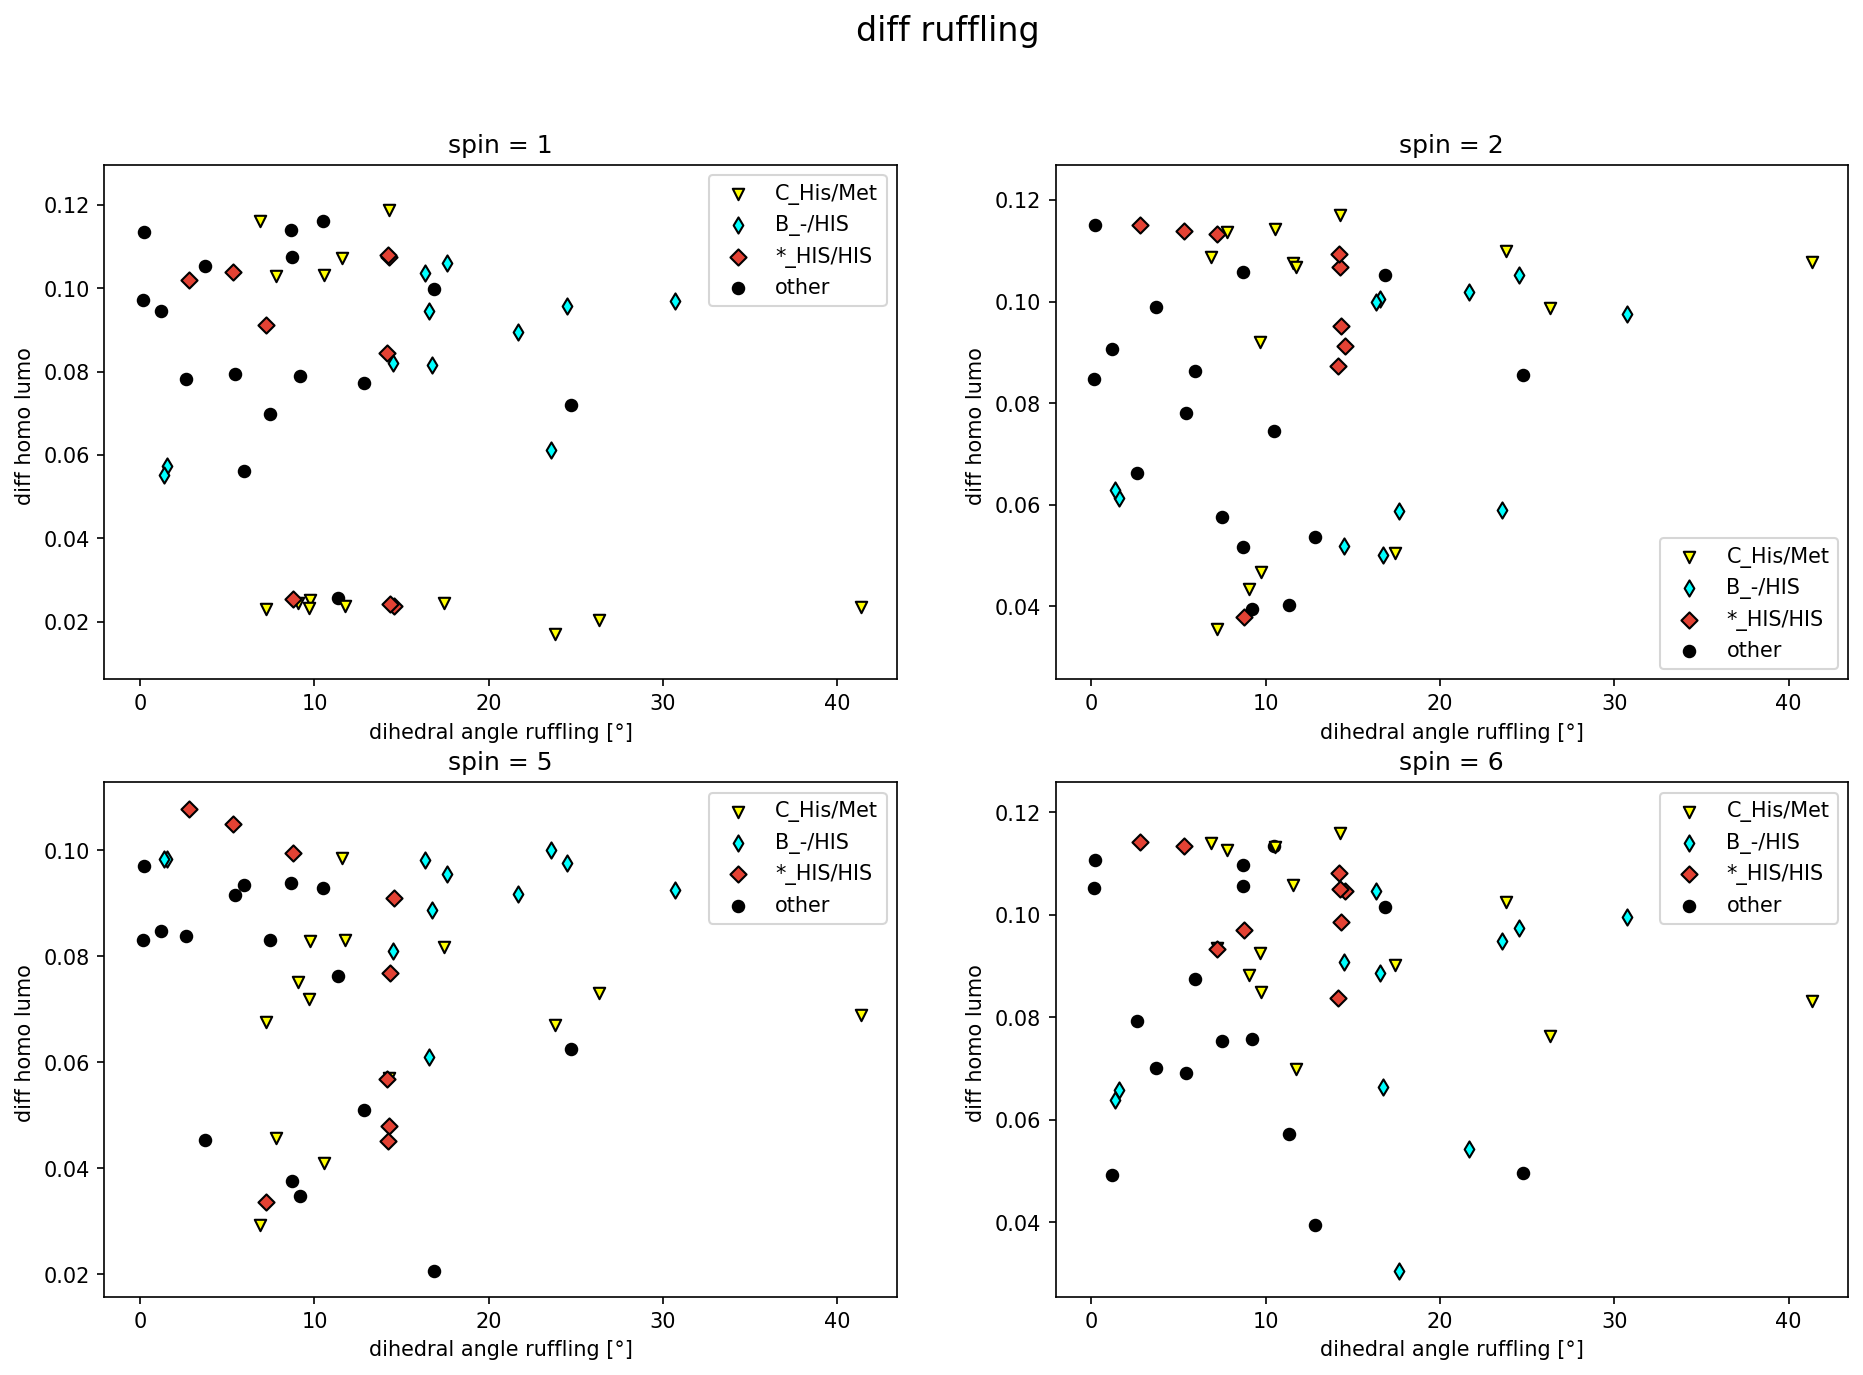

In [124]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.00]
    fig.suptitle('diff ruffling', fontsize=16)

    plt.subplot(2,2,i)
    scatterkat(df, "ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"spin = {s}")

    plt.ylabel("diff homo lumo ")    
    plt.xlabel(dihedruf)
    plt.legend()
fig.savefig(f"{plots}diff_ruffling.png")        

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


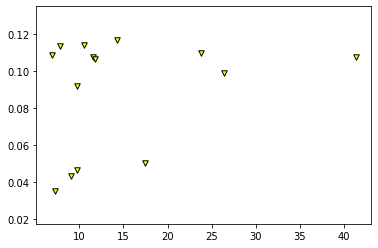

In [125]:
df= df_work2.copy()
df = df[df["Kategorie2"]==CHM]
scatterkat(df,"ruffling","diff_2_nbo",Kategorie)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

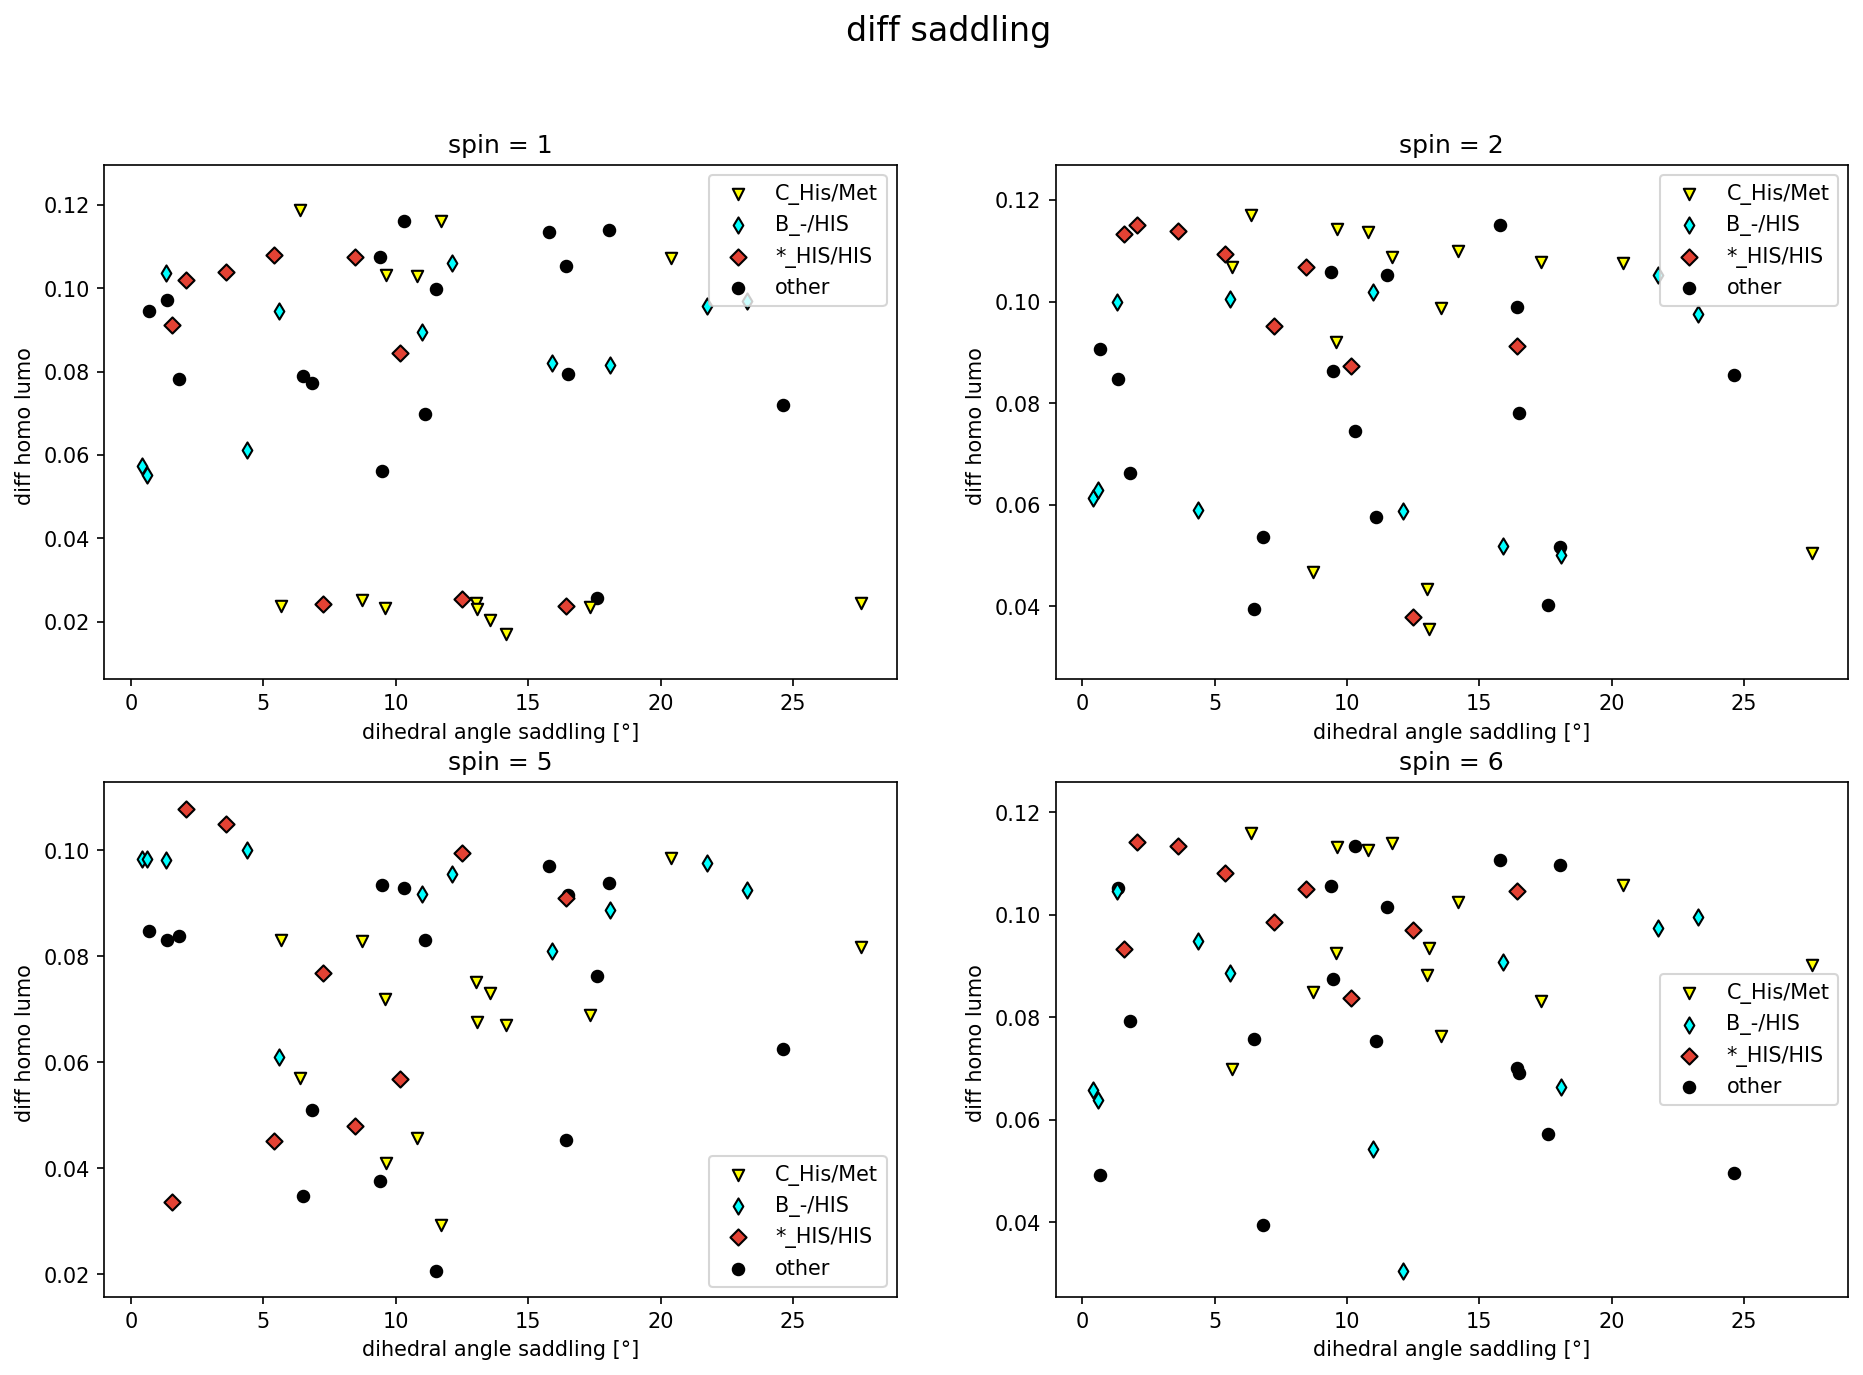

In [126]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    df= df_work2[df_work2[f"diff_{str(s)}_nbo"]>0.00]
    fig.suptitle('diff saddling', fontsize=16)

    plt.subplot(2,2,i)
    scatterkat(df, "saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"spin = {s}")
    plt.legend()
    plt.ylabel("diff homo lumo ")    
    plt.xlabel(dihedsad)
fig.savefig(f"{plots}diff_saddling.png")    

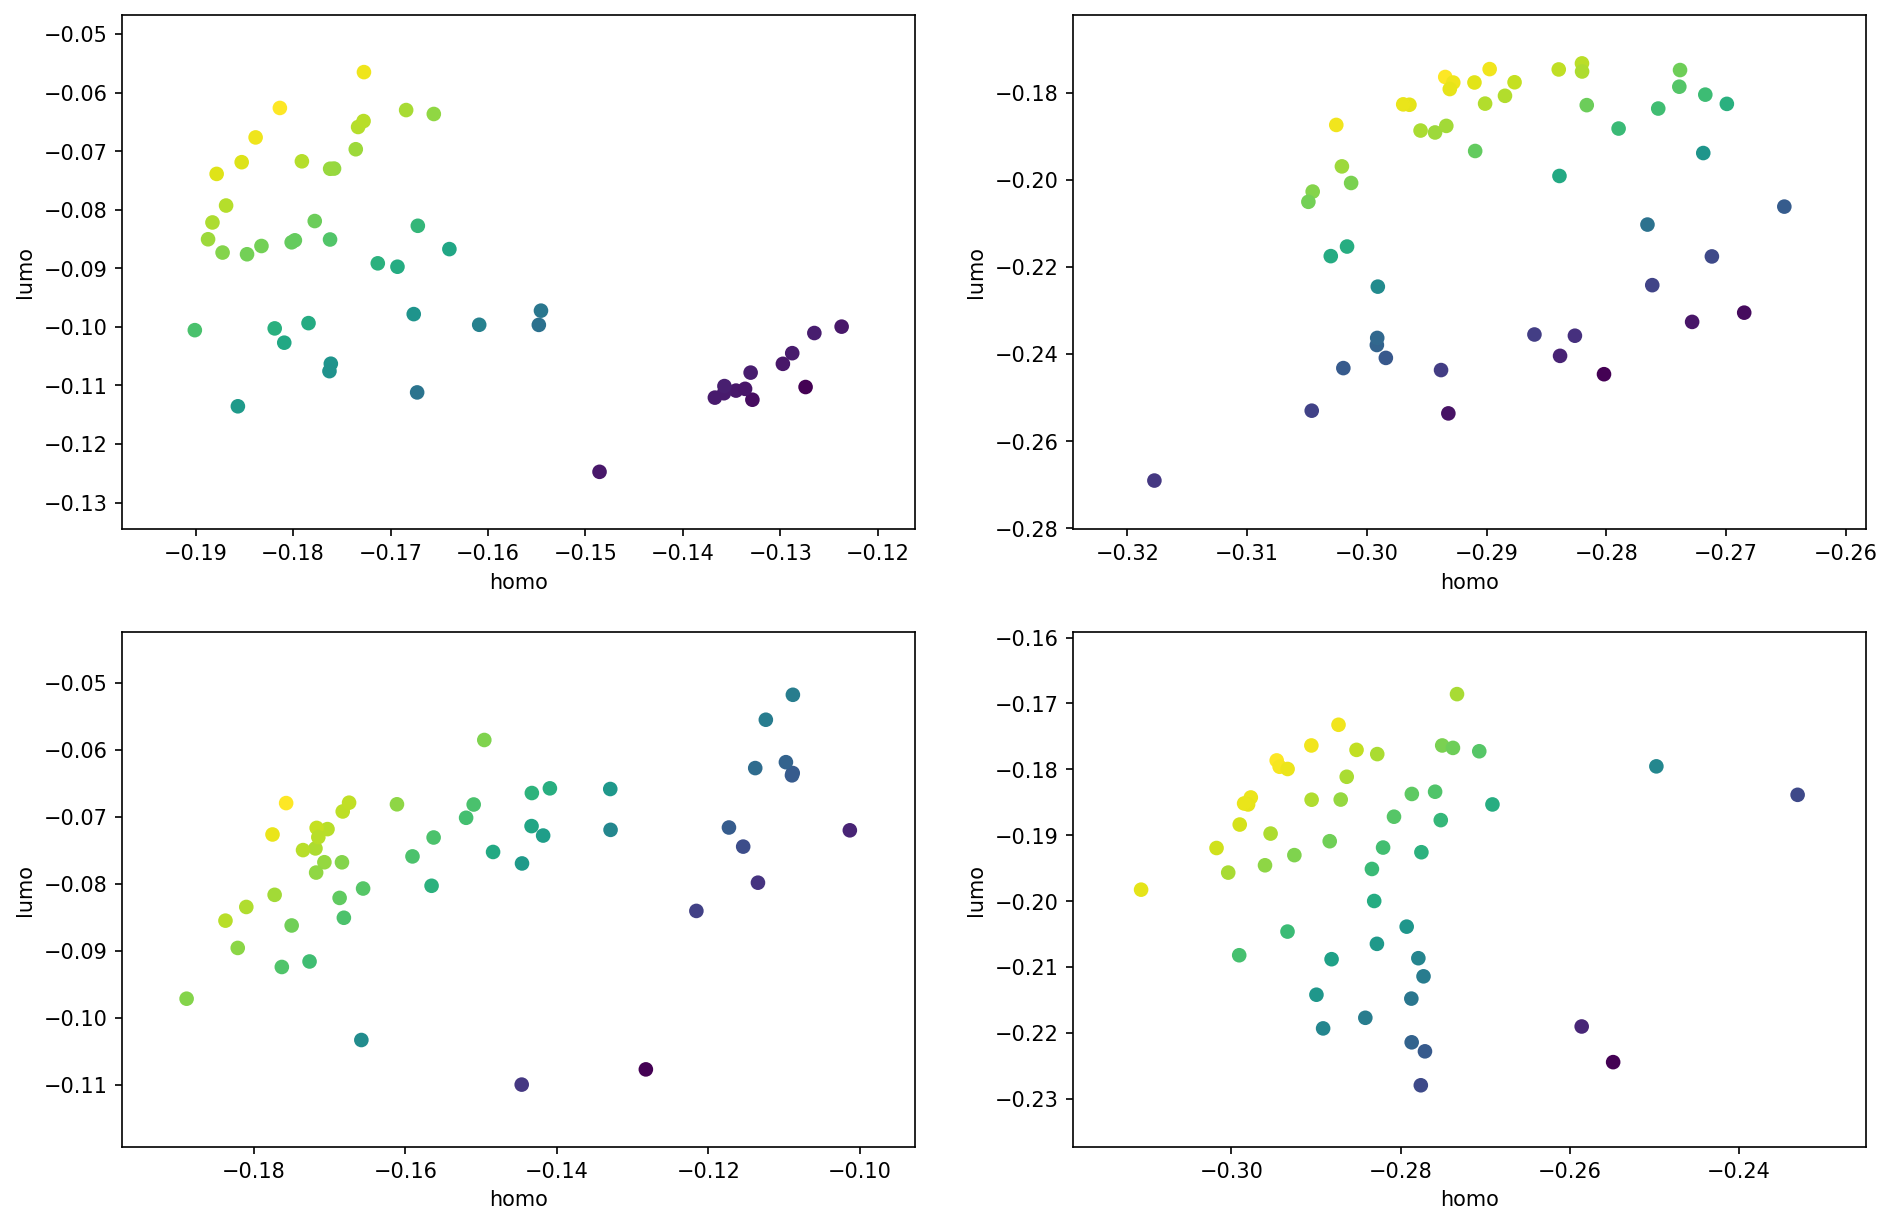

In [127]:
fig = plt.figure(dpi = 150,figsize=(15,10))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    #plt.plot(df_work6[f"diff_{str(s)}_nbo"],"o")
    #plt.scatter()
    plt.subplot(2,2,i)
    plt.xlabel("homo")    
    
    plt.ylabel("lumo")

    
    plt.scatter(df_work6[f"homo_{str(s)}_nbo"], df_work6[f"lumo_{str(s)}_nbo"], c = df_work6[f"diff_{str(s)}_nbo"] )
    #df = df_work6[df_work6["ud"] =="uu"]
    #plt.scatter(df[f"diff_{str(s)}_nbo"],df["Em_lit"])


In [128]:
plots

'/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/'

In [129]:
df_work2["Kategorie2"].value_counts()

other        16
C_His/Met    14
B_-/HIS      11
*_HIS/HIS     9
Name: Kategorie2, dtype: int64

/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hagen/anaconda3/envs/KLeich/lib/python3.7/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previ

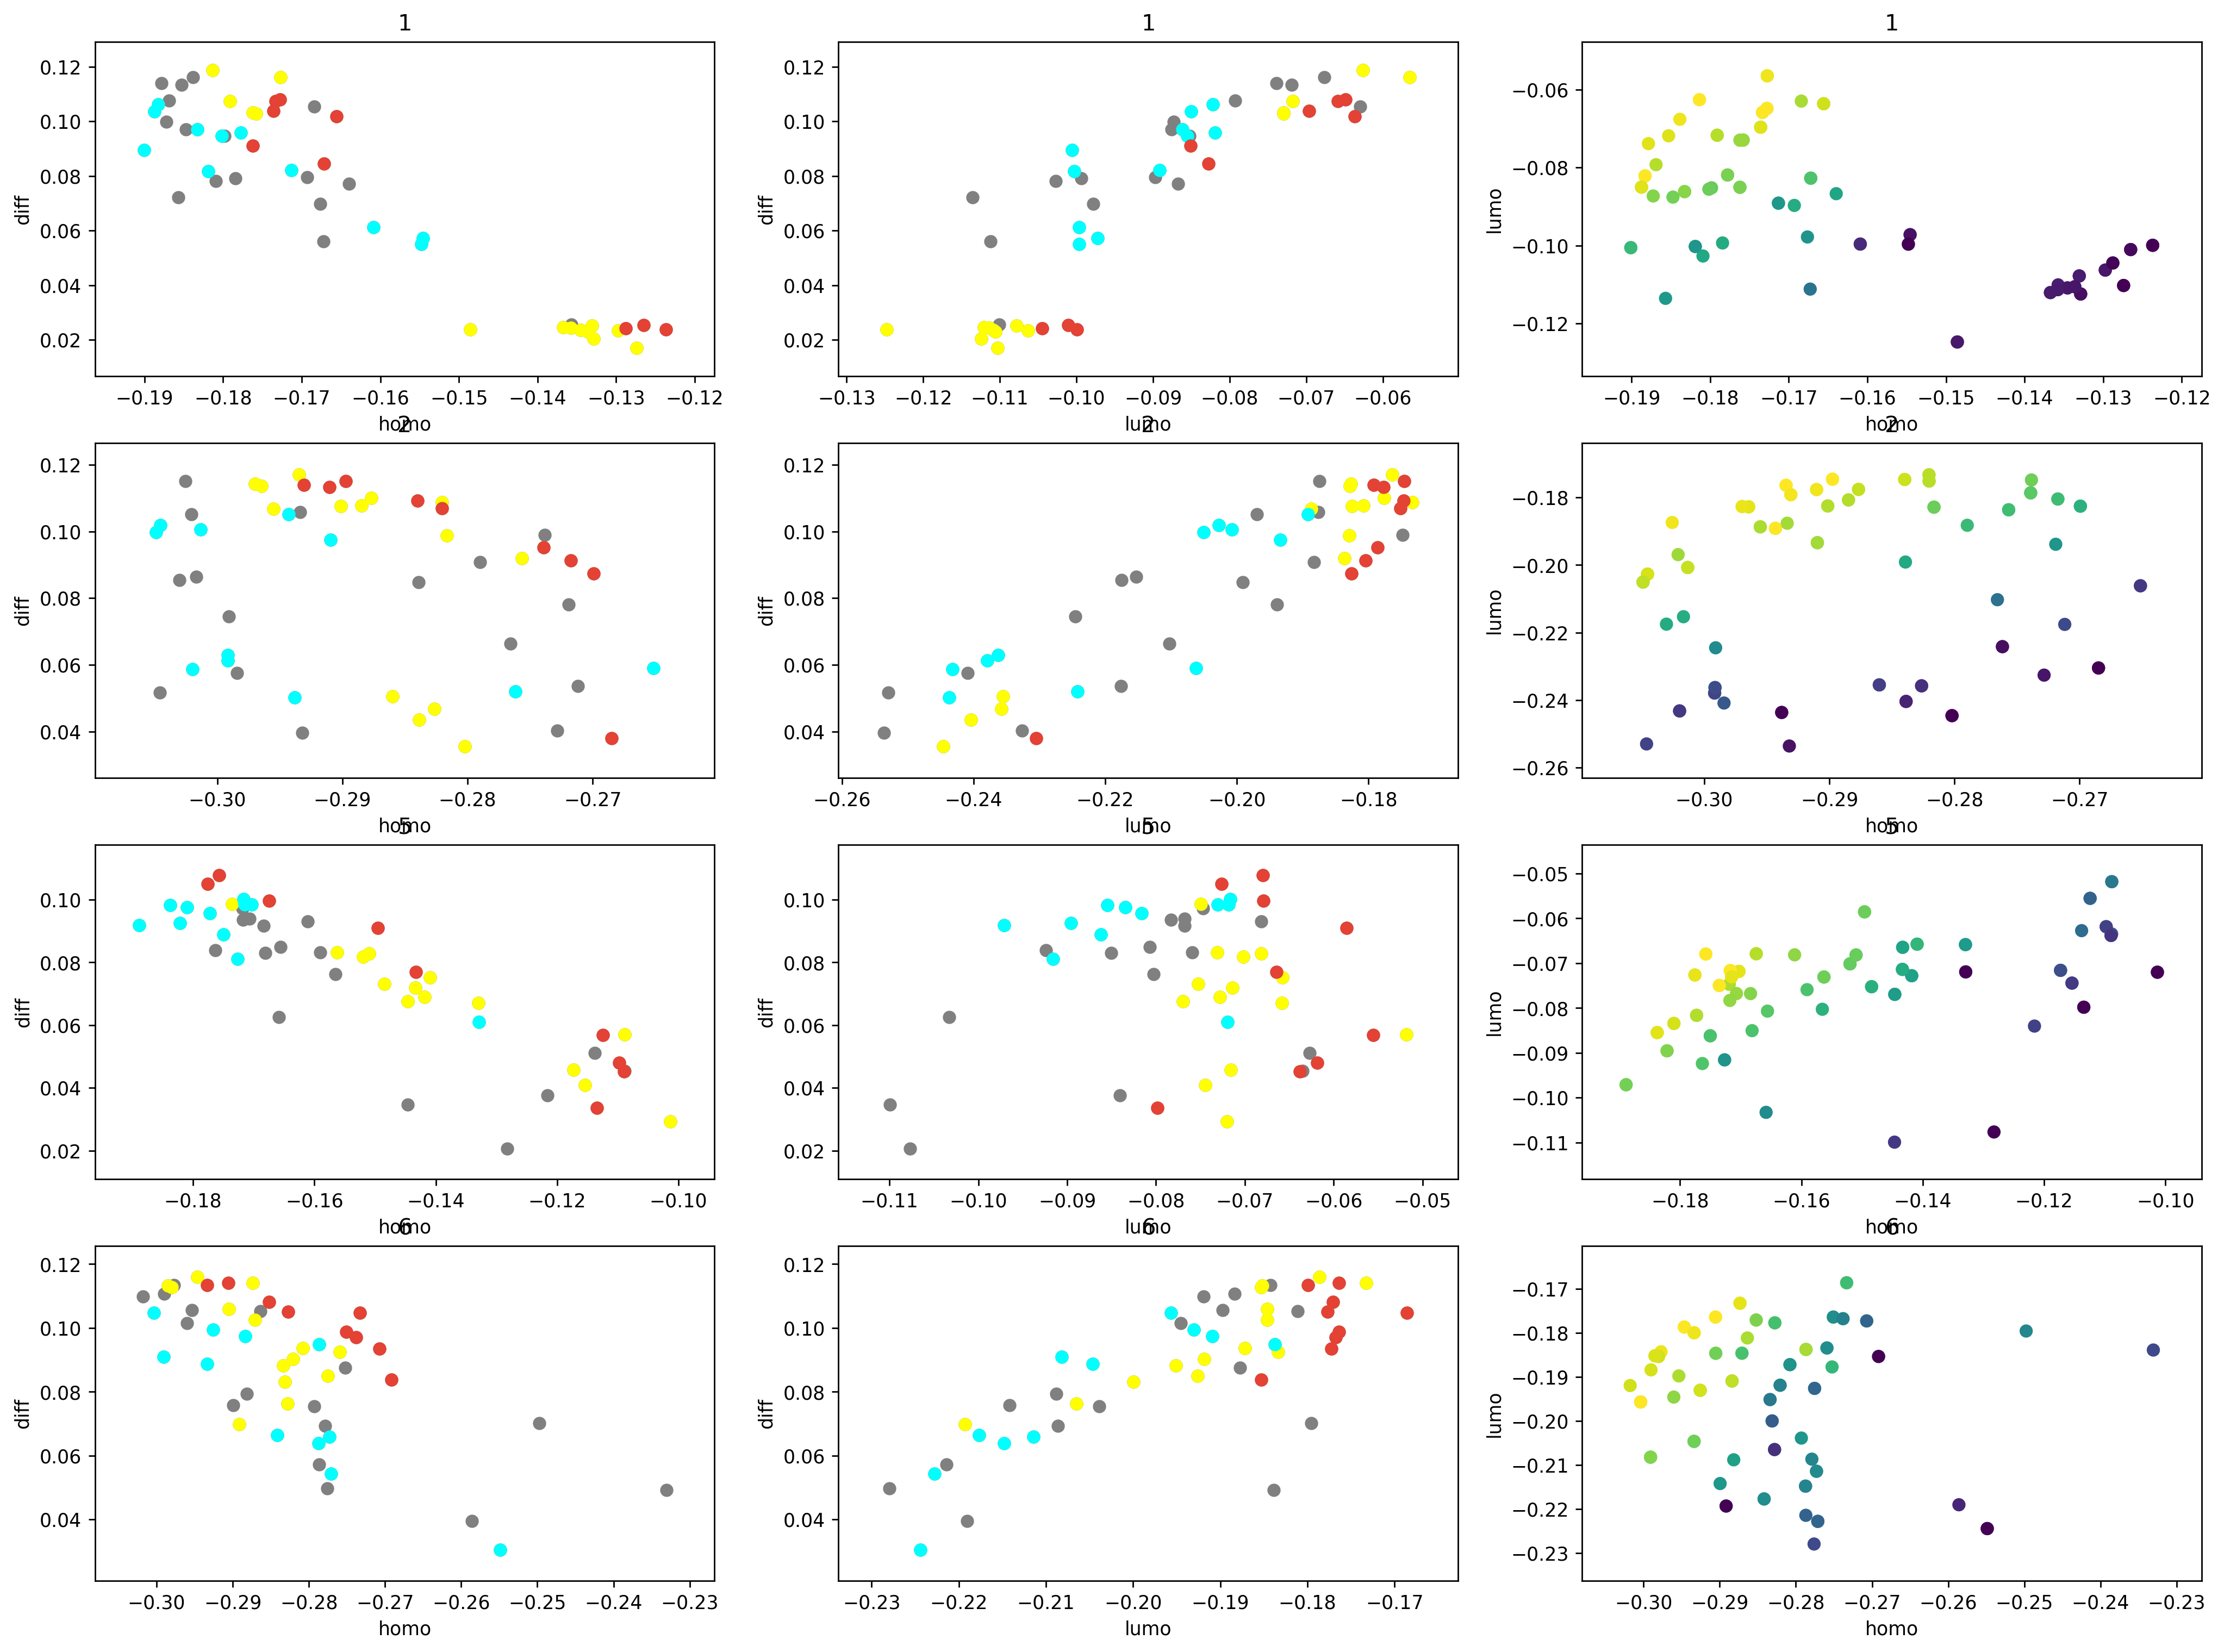

In [130]:
df = df_work2.copy()
plt.figure(dpi=250,figsize=[20,15])





for z,s in zip( [1,4,7,10]  ,[1,2,5,6]):
    plt.subplot(4,3,z+1)
    plt.xlabel("lumo")    
    plt.ylabel("diff")
    plt.title(f"{s}")

    plt.scatter(df[f"lumo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = "grey")

    plt.subplot(4,3,z)
    plt.xlabel("homo")    
    plt.ylabel("diff")
    plt.title(f"{s}")

    plt.scatter(df[f"homo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = "grey")# df["diff_5_nbo"])


    plt.subplot(4,3,z+2)
    plt.xlabel("homo")    
    plt.ylabel("lumo")
    plt.title(f"{s}")

    plt.scatter(df[f"homo_{str(s)}_nbo"],df[f"lumo_{str(s)}_nbo"], c = df[f"diff_{str(s)}_nbo"])# df["diff_5_nbo"])    










for kat in Kategorie:
    df = df_work2.copy()
    
    df = df[df["Kategorie2"] == kat]


    for z,s in zip( [1,4,7,10]  ,[1,2,5,6]):
        plt.subplot(4,3,z+1)
        plt.xlabel("lumo")    
        plt.ylabel("diff")
        plt.title(f"{s}")

        plt.scatter(df[f"lumo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = Colorbar[kat])

        plt.subplot(4,3,z)
        plt.xlabel("homo")    
        plt.ylabel("diff")
        plt.title(f"{s}")

        plt.scatter(df[f"homo_{str(s)}_nbo"], df[f"diff_{str(s)}_nbo"],c = Colorbar[kat])# df["diff_5_nbo"])


        plt.subplot(4,3,z+2)
        plt.xlabel("homo")    
        plt.ylabel("lumo")
        plt.title(f"{s}")

        plt.scatter(df[f"homo_{str(s)}_nbo"],df[f"lumo_{str(s)}_nbo"], c = df[f"diff_{str(s)}_nbo"])# df["diff_5_nbo"])    

#  Modelle

In [131]:
df_work3 = df_work2.copy()
for c in df_liganden.columns:
    df_work3[c] = df_liganden[c]

In [132]:
df = df_work2.copy()
X = df[['e_1_nbo', 'edisp_1_nbo', 'homo_1_nbo', 'lumo_1_nbo', 'chem_pot_1_nbo', 'diff_1_nbo', 'elekphil_1_nbo', 'dipole_1_nbo', "ruffling", "saddling"]]
Y = df[["Em_lit"]]
for i in range(6):
    X_train,X_test,y_train,y_test = train_test_split(X,Y)
    model = LinearRegression()
    model.fit(X,Y)
    y_pred = model.predict(X_test)
    print(model.score(X_test,y_test))

0.38022130092369877
0.5727104979093699
0.46848453769781345
0.6176249180666751
0.5153819364497322
0.4480121693122865


In [133]:
[i for i in df_work2.columns if "_1_nbo" in i]

['e_1_nbo',
 'edisp_1_nbo',
 'homo_1_nbo',
 'lumo_1_nbo',
 'chem_pot_1_nbo',
 'diff_1_nbo',
 'elekphil_1_nbo',
 'dipole_1_nbo',
 'qpole1_1_nbo',
 'qpole2_1_nbo',
 'qpole3_1_nbo',
 'qpole4_1_nbo']

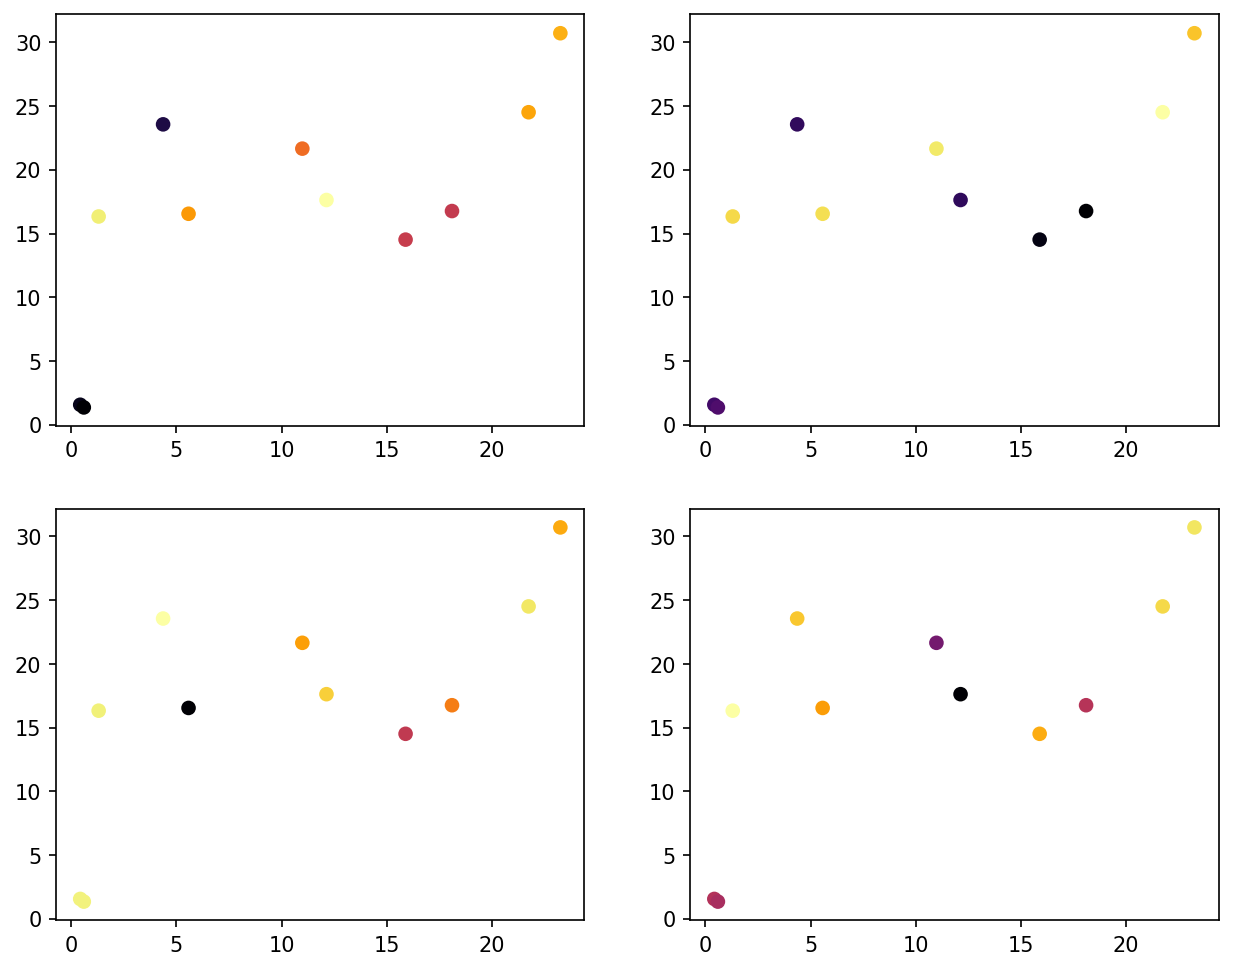

In [134]:
df  = df_work2.copy()
df = df[df[BHIS]==1]
fig = plt.figure(dpi = 150,figsize= [10,8])
for i,s in zip([1,2,3,4],[1,2,5,6]):
    plt.subplot(2,2,i)
    plt.scatter(df["saddling"],df["ruffling"],c = df[f"diff_{str(s)}_nbo"],cmap = cmap1)
    #plt.colorbar()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


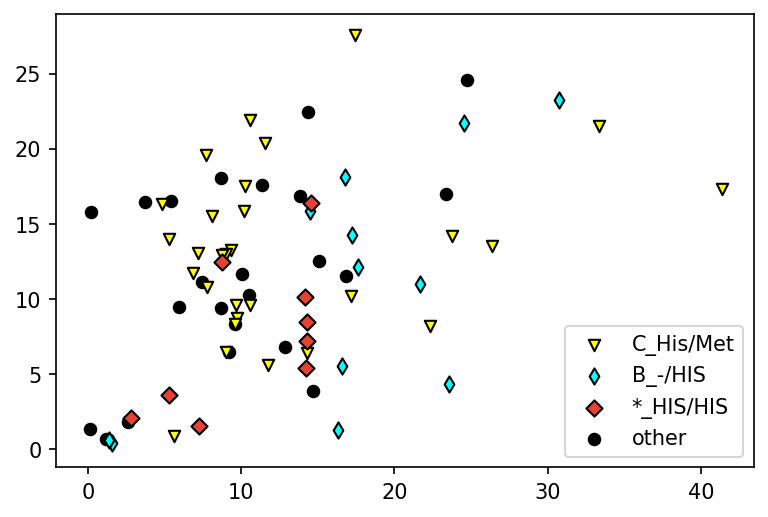

In [135]:
df  = df_work2.copy()
#df = df[df["HH"]==1]
fig = plt.figure(dpi = 150) #,figsize= [10,8])
#for i,s in zip([1,2,3,4],[1,2,5,6]):
 #   plt.subplot(2,2,i)
scatterkat(dflg,"ruffling","saddling",Kategorie)
plt.legend()

## Hauptkomponentenanalyse

### über den gesamten DataFrame

In [97]:

#string1("edisp_5_nbo")


df = pca_show(df_work2)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)

nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"HK{1+i} "] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}123.csv")
df2

noise variance:  0.4328581623827281
number of componentes:  6
[0.24962686 0.13853978 0.11645913 0.07935208 0.06151883 0.05345744]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1    HK1               HK2    HK2                 HK3    HK3   \
0  $edisp_{5}$  0.2375     $qpole3_{1}$  0.3208         $diff_{1}$  0.3037   
1  $edisp_{1}$  0.2375     $qpole3_{5}$  0.3172         $lumo_{1}$  0.2983   
2  $edisp_{2}$  0.2375     $qpole4_{1}$  0.3036     $elekphil_{1}$  0.2934   
3  $edisp_{6}$  0.2375     $qpole4_{5}$  0.2953         $diff_{2}$  0.2555   
4      $e_{2}$  0.2170     $qpole3_{6}$  0.2489         $homo_{1}$  0.2515   

                HK4    HK4                   HK5    HK5                  HK6  \
0      $qpole2_{5}$  0.2809           $homo_{6}$  0.3168        $qpole4_{2}$   
1      $qpole2_{1}$  0.2730       $chem pot_{6}$  0.2797        $qpole1_{2}$   
2      $qpole1_{1}$  0.2715                $ud $  0.2462          $diff_{5}$   
3      $qpole2_{6}$  0.2697         $dipole_{6}$  0.2371          $homo_{5}$   
4      $qpole1_{5}$  0.2693           $lumo_{5}$  0.2356          $ruffling$   

     HK6   
0  0.3161  
1  0.3119  
2  0.2590  
3  0.2363  
4  0.2200

### edisp  raus

In [98]:
df = pca_show(df_work2)
df.shape

noise variance:  0.4328581623827281
number of componentes:  6
[0.24962686 0.13853978 0.11645913 0.07935208 0.06151883 0.05345744]


(6, 64)

In [99]:
len(df)

6

In [100]:
df = df_work2[[c for c in df_work2.columns if True not in df_work2[c].isna().value_counts().index]]
df = df[[c for c in df.columns if df[c].dtypes in [float, int] ]]
dfpca1 = df

In [101]:
dfpca2 = dfpca1[[i for i in dfpca1.columns if "edisp" not in i  and not( "e_"  in i and "dipole" not in i)     ]].copy()
dfpca2["edisp"] = df_work2[[i for i in df_work2.columns if "edisp" in i]].mean(axis=1)
dfpca2["e"]  = df_work2[[i for i in df_work2.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)

df_work4 = df_work2.copy()
df_work4["edisp"] = df_work2[[i for i in df_work2.columns if "edisp" in i]].mean(axis=1)
df_work4["e"]  = df_work2[[i for i in df_work2.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)



In [102]:
df = pca_show(dfpca2, num_comp= 5)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA_generell.csv",index=False)
df2

noise variance:  0.4712149572080718
number of componentes:  5
[0.20159008 0.15016224 0.12354966 0.08684593 0.06677031]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1  0.2016              HK2  0.1502                HK3  0.1235  \
0         $edisp$  0.2366     $qpole3_{1}$  0.3044         $diff_{1}$  0.3343   
1  $chem pot_{1}$  0.2250     $qpole3_{5}$  0.3019     $elekphil_{1}$  0.3248   
2  $chem pot_{2}$  0.2153     $qpole4_{1}$  0.2942         $homo_{1}$  0.3073   
3      $edif-2-5$  0.2150     $qpole4_{5}$  0.2904         $lumo_{1}$  0.2911   
4             $e$  0.2022     $qpole3_{6}$  0.2197         $edif-6-1$  0.2312   

                HK4  0.0868                  HK5  0.0668  
0      $qpole2_{5}$  0.2922           $homo_{6}$  0.3230  
1      $qpole2_{6}$  0.2884         $dipole_{6}$  0.2561  
2      $qpole2_{2}$  0.2864                $ud $  0.2549  
3      $qpole2_{1}$  0.2859       $chem pot_{6}$  0.2528  
4      $qpole1_{6}$  0.2857           $ruffling$  0.2147

In [103]:
dfpca3 = dfpca2[[c for c in dfpca2.columns if not any(i in c for i in ["qpol","dipol","chem_pot","diff","elekphil"])]]


dfpca3.head()

Em_lit  homo_1_nbo  lumo_1_nbo  homo_2_nbo  lumo_2_nbo  homo_5_nbo  \
pdb                                                                        
1FJ0   350.0    -0.13578    -0.11133    -0.28387    -0.24041    -0.14093   
1C75    47.0    -0.17273    -0.05650    -0.28204    -0.17331    -0.10133   
1GU2   -60.0    -0.12370    -0.09996    -0.27174    -0.18048    -0.14959   
1JP6    50.0    -0.15456    -0.09723    -0.29917    -0.23792    -0.17029   
3CCX  -181.1    -0.18828    -0.08217    -0.30197    -0.24322    -0.17727   

      lumo_5_nbo  homo_6_nbo  lumo_6_nbo   ruffling  ...  du   uu   ud   dd   \
pdb                                                  ...                       
1FJ0    -0.06576    -0.28339    -0.19512   9.040234  ...    1    0    0    0   
1C75    -0.07202    -0.28734    -0.17324   6.872086  ...    1    0    0    0   
1GU2    -0.05855    -0.27333    -0.16859  14.568771  ...    0    0    1    0   
1JP6    -0.07184    -0.27729    -0.21141   1.566411  ...    0    0    1    0   
3CCX    -0.08164    -0.25487    -0.22443  17.627942  ...    0    1    0    0   

      edif-2-1  edif-2-5  edif-6-1  edif-6-5      edisp            e  
pdb                                                                   
1FJ0  0.158383  0.179734  0.145610  0.166961 -94.688740 -3880.456342  
1C75  0.208779  0.142012  0.202708  0.135942 -98.072677 -3881.350871  
1GU2  0.103716  0.132084  0.119058  0.147426 -91.195247 -3628.742266  
1JP6  0.144321  0.203422  0.143352  0.202452 -79.663631 -3438.436391  
3CCX  0.196607  0.225644  0.213905  0.242943 -75.521358 -3362.136971  

[5 rows x 24 columns]

In [143]:
df = pca_show(dfpca3, num_comp= 5)
if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)
nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA2.csv",index=False)
df2

noise variance:  0.3889486775173763
number of componentes:  5
[0.2919596  0.15564838 0.10643385 0.07837073 0.06582809]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1   0.292            HK2  0.1556            HK3  0.1064      \
0     $edisp$  0.3413     $lumo_{1}$  0.4238          $CHM$  0.3301       
1         $e$  0.3054     $homo_{1}$  0.3228          $uu $  0.3252       
2  $edif-2-5$  0.2813          $dd $  0.2941     $homo_{6}$  0.3157       
3     $B-HIS$  0.2585          $du $  0.2765       $HisHis$  0.3019       
4  $edif-6-5$  0.2543     $edif-6-1$  0.2650     $homo_{2}$  0.2662       

          HK4  0.0784              HK5  0.0658  
0  $ruffling$  0.4278       $homo_{6}$  0.5188  
1        $Em$  0.3669            $ud $  0.3808  
2  $edif-6-1$  0.3214       $homo_{2}$  0.3220  
3    $HisHis$  0.3014       $ruffling$  0.3015  
4  $edif-6-5$  0.2880       $edif-6-1$  0.2670

In [144]:
f"{plotab}PCA2.csv"

'/home/hagen/Masterarbeit/Arbeit/MasterThesis/img/results/tables/PCA2.csv'

In [145]:
dfpca4 = dfpca3[[c for c in dfpca3.columns if  not any(i in c for i in [HH,BHIS,CHM,"ud ","dd ","du ", "uu"]) ]]
df = pca_show(dfpca4, num_comp= 5)

if "variance_ratio" in df.columns:
    variance_ratio = df["variance_ratio"]
    df = df.drop(["variance_ratio"], axis=1)

nlargest = 5

df2= pd.DataFrame()
for i in df.index:

    asd =df.loc[i].abs().nlargest(nlargest)[:]
    df2[f"HK{1+i}"] = [string1(i) for i in   df.loc[i].abs().nlargest(nlargest).index]
    df2[f"{np.round(variance_ratio.loc[i],4)}"] = [np.round(i,4) for i in list(df.loc[i].abs().nlargest(nlargest))]

    
    if i+1!= len(df.index):
        df2[" "*(i+1)] = [" "]*nlargest
    
    #print(df.loc[i].abs().nlargest(5)) 
    print(type(df.loc[i].abs().nlargest(5)[:]))
df2.to_csv(f"{plotab}PCA3.csv",index=False)
df2

noise variance:  0.3301365796988615
number of componentes:  5
[0.32862786 0.18176291 0.09918944 0.08838336 0.07365961]
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


HK1  0.3286            HK2  0.1818            HK3  0.0992      \
0     $edisp$  0.3767     $lumo_{1}$  0.5188     $homo_{6}$  0.6013       
1  $edif-2-5$  0.3342     $homo_{1}$  0.4277     $ruffling$  0.4245       
2         $e$  0.3316     $edif-6-1$  0.3637     $edif-6-5$  0.3157       
3  $edif-6-5$  0.3086     $edif-2-1$  0.3371     $homo_{2}$  0.3112       
4  $lumo_{5}$  0.2909     $lumo_{2}$  0.2717     $saddling$  0.3004       

          HK4  0.0884              HK5  0.0737  
0  $saddling$  0.4887             $Em$  0.5009  
1        $Em$  0.4412       $ruffling$  0.4467  
2  $edif-6-1$  0.3947       $homo_{2}$  0.3933  
3  $ruffling$  0.3425       $homo_{6}$  0.3048  
4  $lumo_{6}$  0.2480       $lumo_{2}$  0.2591

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


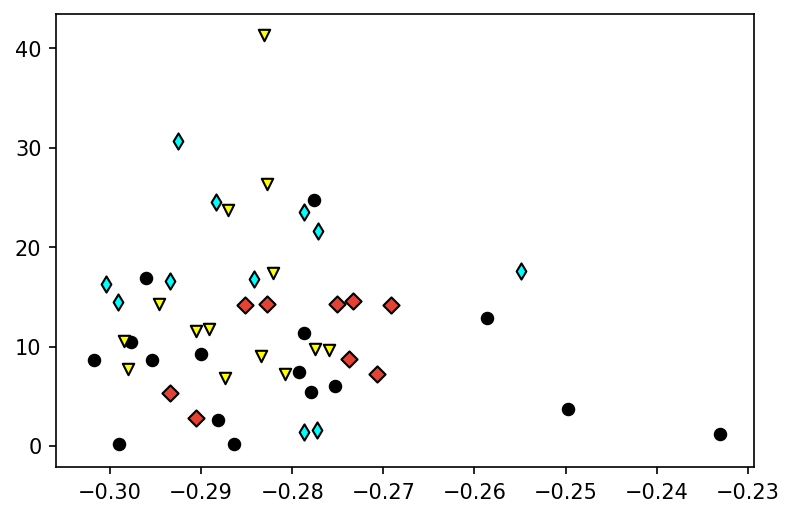

In [146]:
plt.figure(dpi=150)
scatterkat(df_work2,"homo_6_nbo","ruffling",Kategorie)

In [147]:
[ i for i in dfpca2.columns if i not in list(dfpca3.columns) ]

['chem_pot_1_nbo',
 'diff_1_nbo',
 'elekphil_1_nbo',
 'dipole_1_nbo',
 'qpole1_1_nbo',
 'qpole2_1_nbo',
 'qpole3_1_nbo',
 'qpole4_1_nbo',
 'chem_pot_2_nbo',
 'diff_2_nbo',
 'elekphil_2_nbo',
 'dipole_2_nbo',
 'qpole1_2_nbo',
 'qpole2_2_nbo',
 'qpole3_2_nbo',
 'qpole4_2_nbo',
 'chem_pot_5_nbo',
 'diff_5_nbo',
 'elekphil_5_nbo',
 'dipole_5_nbo',
 'qpole1_5_nbo',
 'qpole2_5_nbo',
 'qpole3_5_nbo',
 'qpole4_5_nbo',
 'chem_pot_6_nbo',
 'diff_6_nbo',
 'elekphil_6_nbo',
 'dipole_6_nbo',
 'qpole1_6_nbo',
 'qpole2_6_nbo',
 'qpole3_6_nbo',
 'qpole4_6_nbo']

In [148]:
[ i for i in dfpca3.columns if i not in list(dfpca4.columns) ]

['*_HIS/HIS', 'B_-/HIS', 'C_His/Met', 'du ', 'uu ', 'ud ', 'dd ']

In [149]:
[ i for i in dflg.columns if "nbo" not in i]

['ud',
 'Hemetyp',
 'ligup',
 'ligdown',
 'ax_qn',
 'ax_ql',
 'Em_lit',
 'Elektrode',
 'ax_qn_r',
 'ax_ql_r',
 'ligup_r',
 'ligdown_r',
 'Kategorie',
 'HM',
 '*_HIS/HIS',
 'B_-/HIS',
 'C_His/Met',
 'Kategorie2',
 'du ',
 'uu ',
 'ud ',
 'dd ',
 'ruffling',
 'saddling',
 'axiale Liganden',
 '$E_{red}^{lit}$ [mV]',
 'Kategorie3']

In [150]:
df_work["Kategorie"].value_counts()

[]             17
[C_His/Met]    15
[B_-/HIS]      11
[*_HIS/HIS]     9
Name: Kategorie, dtype: int64

## suche nach ruffling saddlnig Em_lit

In [151]:
dflg

ud Hemetyp ligup ligdown    ax_qn    ax_ql  Em_lit Elektrode  \
pdb                                                                      
1A6G      ud       B   HIS      CO   HIS/CO   CO/HIS    50.0       NHE   
1A6K      ud       B   HIS       -    HIS/-    -/HIS    50.0       NHE   
1A6M      ud       B   HIS      O2   HIS/O2   HIS/O2    50.0       NHE   
1AW3      du       B   HIS     HIS  HIS/HIS  HIS/HIS  -102.0       SHE   
1B5A      du       B   HIS     HIS  HIS/HIS  HIS/HIS  -102.0       SHE   
...       ..     ...   ...     ...      ...      ...     ...       ...   
6U97      uu       C   MET     HIS  MET/HIS  HIS/MET   179.3       NHE   
2C1D_CSS  dd       C   CSS     HIS  CSS/HIS  CSS/HIS  -432.0       NHE   
2C1D_MET  du       C   MET     HIS  MET/HIS  HIS/MET   189.0       NHE   
2GSM      du       A     -     HIS    -/HIS    -/HIS   300.0       NHE   
1V9Z      dd       B   HIS     MET  HIS/MET  HIS/MET    65.5       SHE   

          ax_qn_r  ax_ql_r  ... Kategorie2 du  uu   ud   dd    ruffling  \
pdb                         ...                                           
1A6G        other    other  ...      other   0   0    1    0   7.471468   
1A6K        HIS/-    -/HIS  ...    B_-/HIS   0   0    1    0  14.519887   
1A6M        other    other  ...      other   0   0    1    0   5.978555   
1AW3      HIS/HIS  HIS/HIS  ...  *_HIS/HIS   1   0    0    0   5.321410   
1B5A      HIS/HIS  HIS/HIS  ...  *_HIS/HIS   1   0    0    0   2.802855   
...           ...      ...  ...        ...  ..  ..  ...  ...        ...   
6U97      MET/HIS  HIS/MET  ...  C_His/Met   0   1    0    0  14.284085   
2C1D_CSS    other    other  ...      other   0   0    0    1   9.577443   
2C1D_MET  MET/HIS  HIS/MET  ...  C_His/Met   1   0    0    0   9.577443   
2GSM        -/HIS    -/HIS  ...      other   1   0    0    0  10.496312   
1V9Z        other  HIS/MET  ...      other   0   0    0    1   0.170548   

           saddling axiale Liganden  $E_{red}^{lit}$ [mV]  Kategorie3  
pdb                                                                    
1A6G      11.105041           other                  50.0       other  
1A6K      15.892665           -/HIS                  50.0     B_-/HIS  
1A6M       9.467277           other                  50.0       other  
1AW3       3.600227         HIS/HIS                -102.0   *_HIS/HIS  
1B5A       2.074508         HIS/HIS                -102.0   *_HIS/HIS  
...             ...             ...                   ...         ...  
6U97       6.383501         HIS/MET                 179.3   C_His/Met  
2C1D_CSS   8.328911           other                -432.0       other  
2C1D_MET   8.328911         HIS/MET                 189.0   C_His/Met  
2GSM      10.298891           -/HIS                 300.0       other  
1V9Z       1.339240         HIS/MET                  65.5       other  

[73 rows x 27 columns]

### ruffling

In [152]:
dfbsp  = df_work2.loc[["6U97"]][Kategorie+ud]
dfbsp["..."] =["..."]

dfbsp2 = pd.DataFrame()
for c in dfbsp.columns:
    if c!="...":
    #print(c)
        dfbsp2[string1(c)] = dfbsp[c]
    else:
        dfbsp2[c] = dfbsp[c]
dfbsp2.to_csv(f"{plotab}bsp.csv")
dfbsp2

TypeError: can only concatenate list (not "str") to list

In [ ]:
fig = plt.figure(dpi = 150)
scatterkat(dflg,"saddling","ruffling",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel(dihedruf)
plt.title("saddling vs ruffling")
#fig.savefig(f"{plots}ruffling_vs_saddling.png")

### saddling

### Em_lit

In [ ]:
6.7*10**6/11

In [ ]:
BHIS

In [96]:
df = dfpca4
column ="Em_lit"






dff = pca_col(df,column)

names = []
fig = plt.figure(dpi= 150,figsize=[8,12])

for hk in [0,1]:
    
    HK = (str(dff[hk]["HK"])    )
    
  #  fig = plt.figure(dpi= 150)

    plt.subplot(2,1,hk+1)
    df_p = dff[hk]["df"]
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    plt.title(f"HK {HK} ({variance_ratio})")
    ind1, ind2 = df_p.index
#    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=variance_ratio)
    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=f"{column} ({dff[hk][column]})")
    plt.legend()
    plt.xlabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
    #plt.colorbar()
    cbar =plt.colorbar()#
    cbar.set_label('mV', rotation=0)
    fig.savefig(f"{plots}pca_{column}_{hk}_3D.png")
  #  names.append(f"pca_{column}_{hk}_3D.png")
fig.savefig(f"{plots}pca_{column}_3D.png")
names.append(f"{plots}pca_{column}_3D.png") 
    
fig = plt.figure(dpi=150, figsize=(15,12))    
for hk in [0,1]:
    HK = (str(dff[hk]["HK"])    )
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    
    df_p = dff[hk]["df"]
    ind1, ind2 = df_p.index
    
    plt.subplot(2,2,((hk+1)*1+hk))

    
    plt.title(f"HK {HK} ({variance_ratio})")
   
    
    scatterkat(df_work4,column,ind2,Kategorie,dictionary=scatterdict)
    plt.legend()
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)
    
    plt.ylabel(string1(ind2),fontsize=15)
    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
                
    #names.append(f"pca_{column}_{hk}_1.png")
    
    
    

    plt.subplot(2,2,((hk+1)*2))
    plt.title(f"HK {HK} ({variance_ratio})")
    

    scatterkat(df_work4,column,ind1,Kategorie,dictionary=scatterdict)
    plt.legend()
    
    plt.xlabel(string1(column),fontsize=15)
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)    
    plt.ylabel(string1(ind1),fontsize=15)
    plt.ylabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

   # names.append(f"pca_{column}_{hk}_2.png")

fig.savefig(f"{plots}pca_{column}_2D.png") 
names.append(f"{plots}pca_{column}_2D.png")
for i in names:
    print(i)


NameError: name 'dfpca4' is not defined

In [ ]:
plt.figure(dpi = 150)
y = "Em_lit"
x = "homo_2_nbo"
scatterkat(df_work2,x,y,Kategorie)
plt.xlabel("$homo_2$ [eV]")
plt.ylabel(redox)
plt.title(f"{y} vs {x }")
plt.legend()
plt.savefig(f"{plots}homo2_Em_lit.png")

In [ ]:
X = df[["homo_2_nbo", "Em_lit"]]
x_transformed = scaler.fit_transform(X)


model  =KMeans(n_clusters = 6)
model.fit(x_transformed)


cluster1 = model.cluster_centers_
cluster2 = scaler.inverse_transform(model.cluster_centers_) 



plt.scatter(df["homo_2_nbo"],df["Em_lit"],c=model.labels_,cmap = "jet")

In [ ]:
df = df_work2.copy()
plt.figure(dpi=150,figsize=[12,4])
plt.subplot(121)
y = "Em_lit"
x = "homo_2_nbo"
scatterkat(df_work2,x,y,Kategorie)
plt.xlabel("$homo_2$ [eV]")
plt.ylabel(redox)
plt.title(f"{y} vs {x }")


plt.subplot(122)
X = df[["homo_2_nbo", "Em_lit"]]
x_transformed = scaler.fit_transform(X)


model  =KMeans(n_clusters = 3)
model.fit(x_transformed)


cluster1 = model.cluster_centers_
cluster2 = scaler.inverse_transform(model.cluster_centers_) 



plt.scatter(df["homo_2_nbo"],df["Em_lit"],c=model.labels_,cmap = "jet")

In [ ]:
fig = plt.figure(dpi=150,figsize=[14,8])
for i,kat in enumerate(Kategorie+["other"]):
    df =df_work2.copy()
    df=df[df["Kategorie2"]==kat]
    plt.subplot(2,2,i+1)
    
    if kat == HH:
        dff = df[df["Hemetyp"]=="B"]
        plt.scatter(dff["homo_2_nbo"],dff["Em_lit"],**scatterdict[kat])
        dff = df[df["Hemetyp"]=="C"]
        plt.scatter(dff["homo_2_nbo"],dff["Em_lit"],**scatterdict[kat],c="pink")        
    elif kat == BHIS:
        dff = df[df["ligup"]=="-"]
        plt.scatter(dff["homo_2_nbo"],dff["Em_lit"],**scatterdict[kat])
        dff = df[df["ligup"]=="HIS"]
        plt.scatter(dff["homo_2_nbo"],dff["Em_lit"],**scatterdict[kat],c="blue")
        
        
    else:
        plt.scatter(df["homo_2_nbo"],df["Em_lit"],**scatterdict[kat])

In [ ]:
df = dfpca4
column ="ruffling"






dff = pca_col(df,column)

names = []
fig = plt.figure(dpi= 150,figsize=[8,12])

for hk in [0,1]:
    
    HK = (str(dff[hk]["HK"])    )
    
  #  fig = plt.figure(dpi= 150)

    plt.subplot(2,1,hk+1)
    df_p = dff[hk]["df"]
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    plt.title(f"HK {HK} ({variance_ratio})")
    ind1, ind2 = df_p.index
#    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=variance_ratio)
    plt.scatter(df[ind1], df[ind2], c =df[column],cmap = cmap1,label=f"{column} ({dff[hk][column]})")
    plt.legend()
    plt.xlabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")

    cbar =plt.colorbar()#
    cbar.set_label('mV', rotation=0)
    
    fig.savefig(f"{plots}pca_{column}_{hk}_3D.png")
  #  names.append(f"pca_{column}_{hk}_3D.png")
fig.savefig(f"{plots}pca_{column}_3D.png")
names.append(f"{plots}pca_{column}_3D.png") 
    
fig = plt.figure(dpi=150, figsize=(15,12))    
for hk in [0,1]:
    HK = (str(dff[hk]["HK"])    )
    variance_ratio = np.round(dff[hk]["variance_ratio"],4)
    
    df_p = dff[hk]["df"]
    ind1, ind2 = df_p.index
    
    plt.subplot(2,2,((hk+1)*1+hk))

    
    plt.title(f"HK {HK} ({variance_ratio})")
   
    
    scatterkat(df_work4,column,ind2,Kategorie,dictionary=scatterdict)
    plt.legend()
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)
    
    plt.ylabel(string1(ind2),fontsize=15)
    plt.ylabel(f"{string1(ind2)} ({np.round(df_p.loc[ind2][hk],4)})")
                
    #names.append(f"pca_{column}_{hk}_1.png")
    
    
    

    plt.subplot(2,2,((hk+1)*2))
    plt.title(f"HK {HK} ({variance_ratio})")
    

    scatterkat(df_work4,column,ind1,Kategorie,dictionary=scatterdict)
    plt.legend()
    
    plt.xlabel(string1(column),fontsize=15)
    plt.xlabel(f"{string1(column)} ({dff[hk][column]})",fontsize=15)    
    plt.ylabel(string1(ind1),fontsize=15)
    plt.ylabel(f"{string1(ind1)} ({np.round(df_p.loc[ind1][hk],4)})")

   # names.append(f"pca_{column}_{hk}_2.png")

fig.savefig(f"{plots}pca_{column}_2D.png") 
names.append(f"{plots}pca_{column}_2D.png")
for i in names:
    print(i)


In [ ]:
df = df_work2.copy()
model =LinearRegression()
X= df[["ruffling","homo_1_nbo","edif-6-1","saddling"]].values
#X= df[["ruffling","saddling"]].values
y =df[["Em_lit"]].values
X_train,X_test,y_train,y_test = train_test_split(X,y)
model.fit(X,y)
model.score(X_test,y_test)

In [ ]:
plt.scatter(model.predict(X_test),y_test)

In [ ]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "homo_2_nbo"

for i,kat in enumerate (['C_His/Met', 'B_-/HIS', '*_HIS/HIS']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

In [ ]:
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="HIS/HIS"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])
df = df_work2.copy()
df = df[df["Hemetyp"]=="C"]
df = df[df["ax_qn_r"]=="HIS/HIS"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])

In [ ]:
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="-/HIS"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])
df = df_work2.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn_r"]=="HIS/-"]
plt.scatter(df["homo_2_nbo"],df["Em_lit"])

In [ ]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "edif-6-1"

for i,kat in enumerate (['C_His/Met', 'B_-/HIS', '*_HIS/HIS']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

In [ ]:
df = df_work2.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "ruffling"

for i,kat in enumerate (['C_His/Met', 'B_-/HIS', '*_HIS/HIS']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

In [ ]:
df = dflg.copy()
fig =plt.figure(dpi=150,figsize=[15,10])

em = "Em_lit"
gr = "ruffling"

for i,kat in enumerate (['C_His/Met', 'B_-/HIS', '*_HIS/HIS']+["other"]):
    fig.suptitle(f"{gr} vs {em}",fontsize =16)
    plt.subplot(2,2,i+1)
    df = df_work2.copy()
    df = df[df["Kategorie2"]==kat]
    plt.scatter(df[gr],df[em],**scatterdict[kat])
    plt.xlabel(gr)
    plt.ylabel(em)
    plt.title(kat)

In [ ]:
df = dflg.copy()
df = df[df["Kategorie2"]==HH]
df=  df[df["Hemetyp"]=="B"]
plt.scatter(df["ruffling"],df["Em_lit"])

In [ ]:
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
df=  df[df["ligup"]=="-"]
plt.scatter(df["ruffling"],df["Em_lit"])
df = dflg.copy()
df = df[df["Kategorie2"]==BHIS]
df=  df[df["ligdown"]=="-"]
plt.scatter(df["ruffling"],df["Em_lit"])

In [ ]:

plt.scatter(dfpca2["lumo_1_nbo"], dfpca2["diff_1_nbo"], c = dfpca2["Em_lit"])

In [ ]:
df = dfpca2[dfpca2["ruffling"]<20]
pca_col(df, "ruffling", 0.01)

In [ ]:
plt.scatter(df["qpole3_2_nbo"], df["dipole_2_nbo"], c = df["ruffling"])

In [ ]:
pca_col(dfpca2, "saddling", 0.01, num_comp = 6)

In [ ]:
plt.scatter(dfpca2["elekphil_1_nbo"], dfpca2["homo_6_nbo"], c = dfpca2["saddling"])

In [ ]:
df_workp1 = df_work4[[i for i in df_work4.columns if "edisp" not in i  and not( "e_"  in i and "dipole" not in i)     ]].copy()


df_workp1 = df_work4[[i for i in df_work4.columns if "pole" not in i]]
df_workp1 = df_workp1[[i for i in df_workp1.columns if not "e_" in i]]
df_workp1["edisp"] = df_work4[[i for i in df_work4.columns if "edisp" in i]].mean(axis=1)
df_workp1["e"]  = df_work4[[i for i in df_work4.columns if "e_" in i and "dipole" not in i]].mean(axis= 1)

In [ ]:
X = df_workp1[[i for i in df_workp1.columns if not ( "dipole" in i or "edisp" in i)]].values
s = StandardScaler()
X = s.fit_transform(X)
p = PCA(n_components = 4)
p.fit(X)
X_transformed = p.transform(X)
X_transformed_filtered = X_transformed
print("noise variance: ",p.noise_variance_)
dfp = pd.DataFrame(p.components_,columns = [i for i in df_workp1.columns if not ( "dipole" in i or "edisp" in i)])

In [ ]:
dfp

In [ ]:
dfpa = dfp.abs()
dfpa.loc[0].nlargest(5)

In [ ]:
plt.scatter(df_work3["chem_pot_2_nbo"],df_work3["chem_pot_5_nbo"])

In [ ]:
[i  for i in df_work3.columns if i not in df_work2.columns]

In [ ]:
"""
df_work  alle spalten/Zeilen

df_work2 Arbeitsdict ohne gefailte spalten
df_work6 ohne fail bei s = 6 also nur 49


df_work3 edisp, e zusammengefasst
df_pca1
df_work7 nur nums auf basis von 3
df_work4 nur nums auf basis von 2
df_work5 ohne gefailte Zeilen



df temporäres arbeits dataframe
dfp temporäres arbeitsdataframe nach pca
"""

In [ ]:
df_workp1

In [ ]:
df_work.loc["1V9Z"]

In [ ]:
df_work2.shape

In [153]:
df = dflg.loc[[i for i in dflg.index if i not in df_work2.index]]
df  = df[df["Kategorie2"] !="other"]
df = df.loc[[i for i in df.index if not "_"in i]]


In [154]:
df[[i == "B-HIS" or i =="HH" for i in df["Kategorie2"]]].index

Index([], dtype='object', name='pdb')

In [155]:
df[[i == "C-HM" for i in df["Kategorie2"]]].index

Index([], dtype='object', name='pdb')

In [156]:
df = dflg.loc[[i for i in dflg.index if i not in df_work2.index]]
df  = df[df["Kategorie2"] =="other"]
df.index

Index(['1EWH', '1HJT', '2OYY', '1IQC_HIS', '2HPD', '4K8F', '2C1D_CSS'], dtype='object', name='pdb')

In [157]:
df_work2.shape

(50, 77)

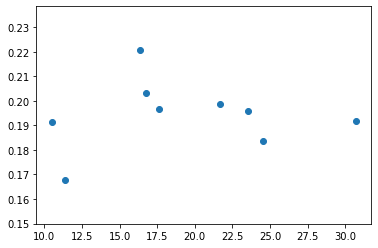

In [158]:
df = df_work2.copy()
df = df[df["ax_qn"]=="-/HIS"]
#df = df[df["ax_qn"]=="HIS/-"]

plt.scatter(df["ruffling"],df["edif-2-1"])

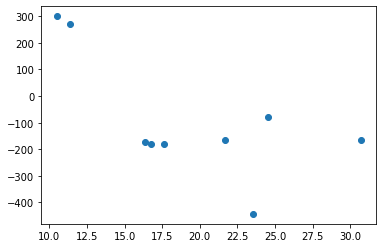

In [159]:
plt.scatter(df["ruffling"],df["Em_lit"])

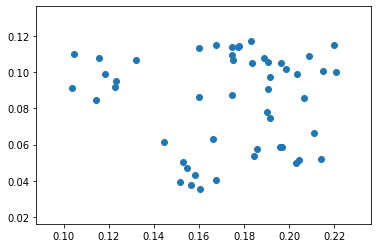

In [160]:
df = df_work2.copy()
edif = "edif-2-1"
diff = "diff_2_nbo"
df = df[df[edif]>-0.5]
plt.scatter(df[edif],df[diff])

In [161]:
df_work2.shape

(50, 77)

In [162]:
df = df_work2.copy()
df = df[df["Kategorie2"]!="other"]

In [163]:
df["edif-2-1"]

pdb
1CMQ    0.191690
1YCC    0.115760
1CYI    0.118487
1GU2    0.103716
1JP6    0.144321
1HRC    0.152950
6U97    0.183124
1FHF    0.195988
1A6K    0.214139
1C75    0.208779
1MZ4    0.123074
1CXC    0.154761
1CCC    0.183527
1CCK    0.203028
1FJ0    0.158383
1CRY    0.104858
1AW3    0.174495
1ES1    0.175008
1B5A    0.167389
1F1C    0.156362
1CYO    0.174545
1F1F    0.188692
451C    0.177527
3CCX    0.196607
1CMT    0.198690
2V07    0.122992
1EHB    0.174813
1EUE    0.160025
1DRM    0.214847
351C    0.177959
1DJ1    0.220645
2CE0    0.160511
1GIW    0.132180
1JP9    0.166082
Name: edif-2-1, dtype: float64

In [164]:
df["edif-6-1"]

pdb
1CMQ    0.185174
1YCC    0.147271
1CYI    0.143665
1GU2    0.119058
1JP6    0.143352
1HRC    0.142395
6U97    0.194546
1FHF    0.147094
1A6K    0.187681
1C75    0.202708
1MZ4    0.135973
1CXC    0.155247
1CCC    0.189548
1CCK    0.177506
1FJ0    0.145610
1CRY    0.122251
1AW3    0.180812
1ES1    0.185444
1B5A    0.189216
1F1C    0.117515
1CYO    0.194812
1F1F    0.199655
451C    0.191223
3CCX    0.213905
1CMT    0.209645
2V07    0.133013
1EHB    0.190349
1EUE    0.175662
1DRM    0.181412
351C    0.189529
1DJ1    0.196823
2CE0    0.138412
1GIW    0.152567
1JP9    0.155088
Name: edif-6-1, dtype: float64

In [165]:
df["edif-6-5"]

pdb
1CMQ    0.185639
1YCC    0.183139
1CYI    0.176477
1GU2    0.147426
1JP6    0.202452
1HRC    0.180184
6U97    0.079470
1FHF    0.180132
1A6K    0.197602
1C75    0.135942
1MZ4    0.140166
1CXC    0.184167
1CCC    0.179787
1CCK    0.182437
1FJ0    0.166961
1CRY    0.167586
1AW3    0.164535
1ES1    0.151008
1B5A    0.158529
1F1C    0.161669
1CYO    0.175985
1F1F    0.180651
451C    0.153218
3CCX    0.242943
1CMT    0.218542
2V07    0.166912
1EHB    0.148057
1EUE    0.148870
1DRM    0.186697
351C    0.150753
1DJ1    0.201388
2CE0    0.156683
1GIW    0.183792
1JP9    0.203244
Name: edif-6-5, dtype: float64

In [166]:
df["edif-2-5"]

pdb
1CMQ    0.192156
1YCC    0.151629
1CYI    0.151300
1GU2    0.132084
1JP6    0.203422
1HRC    0.190739
6U97    0.068047
1FHF    0.229026
1A6K    0.224061
1C75    0.142012
1MZ4    0.127267
1CXC    0.183681
1CCC    0.173766
1CCK    0.207959
1FJ0    0.179734
1CRY    0.150193
1AW3    0.158217
1ES1    0.140571
1B5A    0.136701
1F1C    0.200516
1CYO    0.155717
1F1F    0.169689
451C    0.139522
3CCX    0.225644
1CMT    0.207587
2V07    0.156891
1EHB    0.132521
1EUE    0.133234
1DRM    0.220132
351C    0.139183
1DJ1    0.225211
2CE0    0.178782
1GIW    0.163405
1JP9    0.214238
Name: edif-2-5, dtype: float64

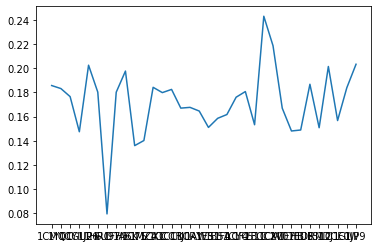

In [167]:
plt.plot(df["edif-6-5"])

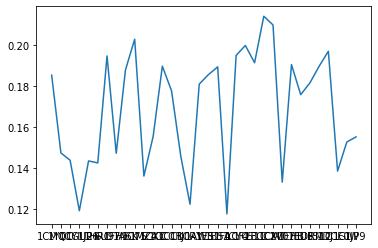

In [168]:
plt.plot(df["edif-6-1"])

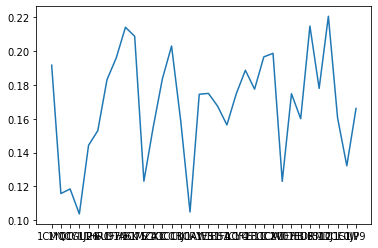

In [169]:
plt.plot(df["edif-2-1"])

In [170]:
for edif in ["edif-2-1","edif-2-5","edif-6-1","edif-6-5"]:
    df = df_work2.copy()
    df = df[df[edif]<0]
    print(df.index, edif)

Index([], dtype='object', name='pdb') edif-2-1
Index([], dtype='object', name='pdb') edif-2-5
Index([], dtype='object', name='pdb') edif-6-1
Index([], dtype='object', name='pdb') edif-6-5


In [171]:
df_work2.loc["1CTJ"]["Kategorie2"]

KeyError: '1CTJ'

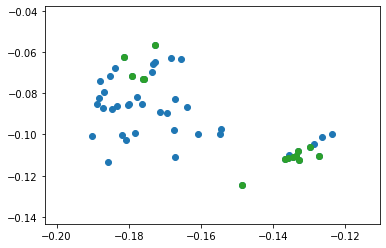

In [172]:
df = df_work2.copy()
plt.scatter(df["homo_1_nbo"],df["lumo_1_nbo"])
df = df[df[edif]<0]
edif = "edif-2-1"
plt.scatter(df["homo_1_nbo"],df["lumo_1_nbo"])
df = df_work2.copy()

df = df[df["Kategorie2"] =="C_His/Met"]
plt.scatter(df["homo_1_nbo"],df["lumo_1_nbo"])

In [173]:
df_work2["Kategorie2"].value_counts()

other        16
C_His/Met    14
B_-/HIS      11
*_HIS/HIS     9
Name: Kategorie2, dtype: int64

In [174]:
df["e_6_nbo"] - df["e_1_nbo"]

pdb
1YCC    0.147271
1CYI    0.143665
1HRC    0.142395
6U97    0.194546
1C75    0.202708
1CXC    0.155247
1FJ0    0.145610
1CRY    0.122251
1F1F    0.199655
451C    0.191223
2V07    0.133013
351C    0.189529
2CE0    0.138412
1GIW    0.152567
dtype: float64

In [175]:
df = df_work2.copy()


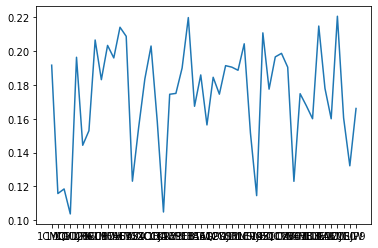

In [176]:
plt.plot(df["edif-2-1"])

In [177]:
plt.table([[2,4],[4,7]],cellText= "abc")

TypeError: table() got multiple values for argument 'cellText'

In [178]:
df  = df_work2.copy()
df["edif"]

KeyError: 'edif'

In [179]:
df = pd.DataFrame({"A":[1,2,3],"B":[4,5,6]})

In [180]:
df

A  B
0  1  4
1  2  5
2  3  6

In [181]:
df_work2.to_csv("df2.csv")

In [182]:
dflg.to_csv("df1.csv")

In [183]:
df = df_work2.copy()
df = df[df[edif]<0]

In [184]:
df[["ruffling", "saddling"]]

Empty DataFrame
Columns: [ruffling, saddling]
Index: []

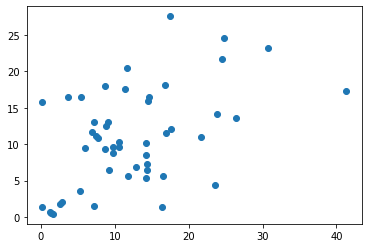

In [185]:
plt.scatter(df_work2["ruffling"], df_work2["saddling"])
plt.scatter(df["ruffling"], df["saddling"])

In [186]:
df_work2

Em_lit Elektrode      e_1_nbo  edisp_1_nbo  homo_1_nbo  lumo_1_nbo  \
pdb                                                                        
1CMQ  -164.5       SHE -3438.599903   -78.789345    -0.18325    -0.08619   
1YCC   290.0       SHE -3880.479559   -93.566521    -0.13454    -0.11088   
1CYI   370.0       SHE -3880.272923   -93.832416    -0.13286    -0.11244   
1GU2   -60.0       NHE -3628.790867   -91.195247    -0.12370    -0.09996   
1CCG  -127.0       SHE -3399.314142   -76.541442    -0.18724    -0.08731   
1JP6    50.0       NHE -3438.493534   -79.663631    -0.15456    -0.09723   
1HRC   260.0       SHE -3880.497119   -94.333475    -0.13671    -0.11208   
1CCE  -127.0       SHE -3249.207355   -69.369748    -0.18567    -0.11356   
6U97   179.3       NHE -3879.046546   -94.103004    -0.18136    -0.06262   
1MOH   103.0       NHE -3761.338506   -83.676388    -0.16840    -0.06298   
1FHF  -443.0       SHE -3455.422494   -78.685821    -0.16090    -0.09964   
1A6K    50.0       NHE -3438.491317   -80.082741    -0.17131    -0.08915   
1C75    47.0       SHE -3881.470435   -98.072677    -0.17273    -0.05650   
1MZ4  -240.0       NHE -3628.786210   -91.379202    -0.12877    -0.10449   
1CXC   355.0       NHE -3880.535155   -94.388609    -0.13304    -0.10781   
1CCC   -78.0       SHE -3438.598198   -78.358857    -0.17778    -0.08193   
1CCK  -178.7       SHE -3438.463256   -78.528211    -0.18189    -0.10026   
1FJ0   350.0       NHE -3880.527002   -94.688740    -0.13578    -0.11133   
1CRY   296.0       SHE -3880.460234   -93.946589    -0.12740    -0.11027   
1AW3  -102.0       SHE -3627.679748   -89.614957    -0.17357    -0.06967   
1ES1    12.0       SHE -3627.495832   -90.676104    -0.17333    -0.06587   
2PCB   260.0       SHE -3879.323670   -93.504648    -0.16929    -0.08973   
1EBT   103.0       NHE -3455.601733   -85.158902    -0.18528    -0.07188   
1B5A  -102.0       SHE -3627.085342   -91.992502    -0.16556    -0.06365   
1A6G    50.0       NHE -3475.471726   -81.291268    -0.16762    -0.09782   
1F1C  -260.0       NHE -3628.770956   -90.087653    -0.12650    -0.10105   
1QPU   168.0       SHE -3879.195683   -94.642601    -0.16396    -0.08672   
1CYO   -10.0       SHE -3627.540067   -91.312372    -0.16720    -0.08274   
2GSM   300.0       NHE -3364.750853   -78.052156    -0.18385    -0.06765   
1JDL   293.0       NHE -3879.405445   -93.347480    -0.18688    -0.07928   
1F1F   314.0       SHE -3881.438683   -95.645001    -0.17910    -0.07173   
1NSI  -347.0       NHE -3535.484611   -74.100257    -0.18785    -0.07388   
1CPO  -138.0       NHE -3535.310170   -72.595725    -0.17842    -0.09936   
1V9Z    65.5       SHE -3879.306538   -91.397713    -0.18473    -0.08760   
1JBQ  -291.0       NHE -3800.487464   -86.095424    -0.18091    -0.10270   
451C   270.0       SCE -3879.341966   -94.260879    -0.17580    -0.07297   
3CCX  -181.1       SHE -3362.232339   -75.521358    -0.18828    -0.08217   
1CMT  -164.5       SHE -3438.540003   -78.789680    -0.19009    -0.10056   
1VB6    63.9       SHE -3879.329348   -92.483620    -0.17982    -0.08522   
2V07    83.0       SHE -3880.516378   -95.070135    -0.12973    -0.10631   
1EHB   -10.0       SHE -3627.653637   -90.664835    -0.17277    -0.06486   
4MU8   269.0       SHE -3439.662879   -81.381414    -0.13573    -0.11011   
1EUE   -63.0       SHE -3627.485173   -89.075294    -0.17621    -0.08508   
1DRM    68.0       NHE -3361.976059   -77.036514    -0.18015    -0.08556   
351C   276.0       SCE -3879.353630   -94.171333    -0.17620    -0.07300   
1A6M    50.0       NHE -3512.449877   -80.498063    -0.16727    -0.11119   
1DJ1  -172.6       SHE -3438.603819   -78.632527    -0.18873    -0.08504   
2CE0    86.0       SHE -3880.517776   -94.899433    -0.13361    -0.11058   
1GIW   260.0       SHE -3880.509679   -93.623754    -0.14855    -0.12475   
1JP9    50.0       NHE -3438.491798   -80.459073    -0.15478    -0.09966   

      chem_pot_1_nbo  diff_1_nbo  elekphil_1_nbo  dip

In [187]:
df =pd.read_csv("/home/hagen/anaconda3/bin/HEM_B.csv")

In [188]:
df.drop_duplicates("# PDB")["ligand"].value_counts()

CYS        987
HIS-HOH    687
HIS        508
HIS-HIS    351
CYS-HOH    304
          ... 
CYS-X6S      1
CYS-26N      1
CYS-9KE      1
CYS-DEV      1
CYS-D1G      1
Name: ligand, Length: 430, dtype: int64

In [189]:
dfc =pd.read_csv("/home/hagen/anaconda3/bin/HEM_C.csv")
dfc["ligand"].value_counts()


HIS-HIS    2016
HIS-MET    1093
HIS         161
HIS-HOH     118
HIS-TYR      79
LYS-HOH      57
CYS-HIS      25
HIS-CSS      21
HIS-LYS      19
LYS-NO2      18
LYS-SO3      18
CYS          17
NO           14
HIS-NO       13
HIS-CMO      13
LYS-SO4      10
HIS-IMD       8
HIS-HOA       8
ASP-MET       6
CYS-HOH       5
HIS-DAH       4
HIS-CYN       4
ASN-HIS       4
LYS-PO4       3
CYS-O4W       3
CYS-O4T       3
LYS           3
HIS-HYP       2
CMO-HOH       2
HIS-CSD       2
LYS-CYN       2
HIS-SER       2
HIS-NH3       2
GLU-HIS       2
HIS-AZI       2
HIS-NBN       2
TYR           2
HIS-OXY       2
MET           2
HOH           2
HIS-PO4       2
None          1
HIS-SO3       1
LYS-SCN       1
HIS-CA1       1
HIS-THR       1
CYS-EDO       1
HIS-H2S       1
LYS-HOA       1
HIS-SX        1
HIS-PHZ       1
AZI-HOH       1
HIS-HZN       1
LYS-AZI       1
HOH-SMA       1
HIS-PHE       1
Name: ligand, dtype: int64

In [190]:
dfc.drop_duplicates("# PDB")["ligand"].value_counts()

HIS-MET    396
HIS-HIS    204
HIS         76
HIS-HOH     43
LYS-HOH     21
NO          13
CYS-HIS     11
HIS-CMO     11
HIS-TYR     10
LYS-NO2     10
LYS-SO3      9
CYS          8
HIS-NO       7
HIS-IMD      6
CYS-HOH      4
HIS-LYS      4
HIS-CSS      4
LYS-SO4      3
CMO-HOH      2
HIS-CYN      2
HIS-NH3      2
LYS-PO4      2
HIS-PO4      2
HIS-CSD      1
HIS-CA1      1
HIS-DAH      1
CYS-O4W      1
HIS-HYP      1
HIS-H2S      1
TYR          1
AZI-HOH      1
GLU-HIS      1
HIS-HOA      1
HIS-AZI      1
CYS-O4T      1
HIS-THR      1
CYS-EDO      1
ASN-HIS      1
LYS-HOA      1
LYS-CYN      1
HIS-OXY      1
HIS-SER      1
HIS-NBN      1
Name: ligand, dtype: int64

In [191]:
df =dflg.copy()
df = df[df["Hemetyp"]=="B"]
df = df[df["ax_qn"]=="HIS/HIS"]
X=df[["ruffling"]].values
y=df[["Em_lit"]].values
X_train,X_test,y_train,y_test=train_test_split(X,y)
model = LinearRegression()
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8574223590972436

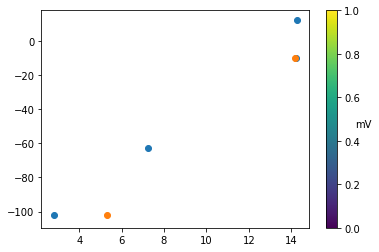

In [192]:
plt.scatter(X_train,y_train)
plt.scatter(X_test,y_test)
cbar =plt.colorbar()#
cbar.set_label('mV', rotation=0)

In [193]:
[i for i in df_work2.columns if "_nbo" not in i]

['Em_lit',
 'Elektrode',
 'ruffling',
 'saddling',
 'ud',
 'Hemetyp',
 'ligup',
 'ligdown',
 'ax_qn',
 'ax_ql',
 'ax_qn_r',
 'ax_ql_r',
 'ligup_r',
 'ligdown_r',
 'Kategorie',
 'HM',
 '*_HIS/HIS',
 'B_-/HIS',
 'C_His/Met',
 'Kategorie2',
 'du ',
 'uu ',
 'ud ',
 'dd ',
 'edif-2-1',
 'edif-2-5',
 'edif-6-1',
 'edif-6-5',
 'Kategorie3']

In [194]:
for ud in df_work2["ud"].value_counts().index:
 #   print(ud)
    print([1 if i==ud else 0 for i in df_work2["ud"]])

[0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]
[1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [195]:
pd.DataFrame(np.array([[1 if i==ud else 0 for i in df_work2["ud"]] for ud in df_work2["ud"].value_counts().index])).sum(axis=0)

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
30    1
31    1
32    1
33    1
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    1
42    1
43    1
44    1
45    1
46    1
47    1
48    1
49    1
dtype: int64

In [196]:
dflg.loc[["2YCC"]]["Em_lit"]

KeyError: "None of [Index(['2YCC'], dtype='object', name='pdb')] are in the [index]"

In [197]:
#for l,h in zip(df["e_1_nbo"],df["e_5_nbo"]):
 #   print(np.array([l,h]).min())
for l,h in zip(df["e_2_nbo"],df["e_6_nbo"]):
    print(np.array([l,h]).min())


KeyError: 'e_2_nbo'

In [198]:
df = df_work2.copy()
df_work3 =df.copy()
#for l3,h3,l2,h2 in zip(df["e_2_nbo"],df["e_6_nbo"],df["e_1_nbo"],df["e_5_nbo"]):
 #   print(np.array([l3,h3]).min()-np.array([l2,h2]).min())
df_work3["edif"] = [np.array([l3,h3]).min()-np.array([l2,h2]).min()  for l3,h3,l2,h2 in zip(df["e_2_nbo"],df["e_6_nbo"],df["e_1_nbo"],df["e_5_nbo"])]


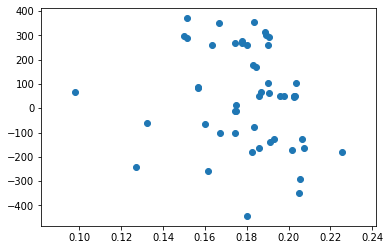

In [199]:
df = df_work3.copy()
plt.scatter(df["edif"],df["Em_lit"])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


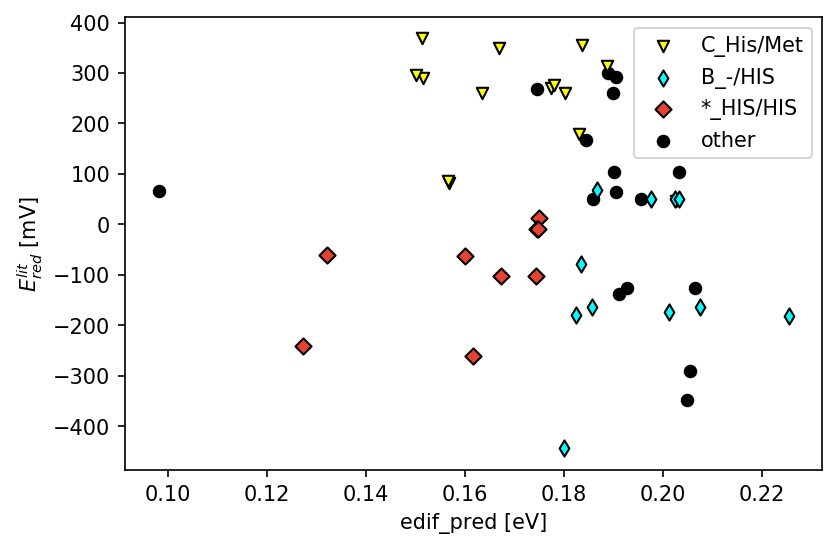

In [222]:
plt.figure(dpi=150)
plt.xlabel("edif_pred [eV]")
plt.ylabel(redox)
scatterkat(df,"edif","Em_lit",Kategorie)
plt.legend()

plt.savefig(f"{plots}edif_pred_Em_lit.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


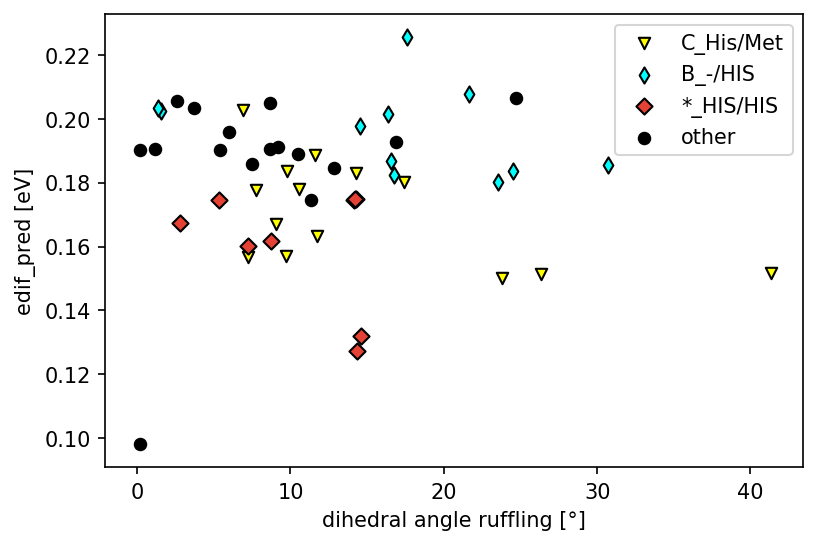

In [221]:
plt.figure(dpi=150)
plt.ylabel("edif_pred [eV]")
plt.xlabel(dihedruf)

scatterkat(df,"ruffling","edif",Kategorie)

plt.legend()

plt.savefig(f"{plots}edif_pred_ruffling.png")

No handles with labels found to put in legend.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


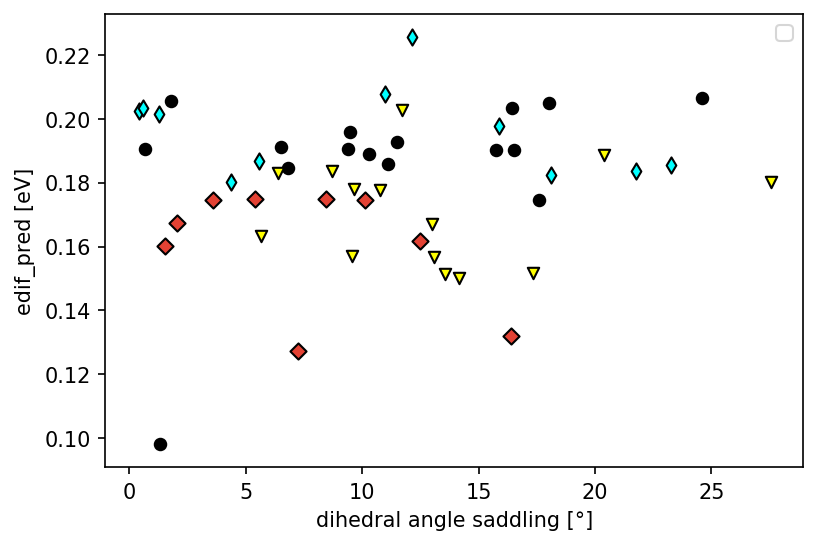

In [220]:
plt.figure(dpi=150)
plt.ylabel("edif_pred [eV]")
plt.xlabel(dihedsad)
plt.legend()
scatterkat(df,"saddling","edif",Kategorie)
plt.savefig(f"{plots}edif_pred_saddling.png")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif_calc')

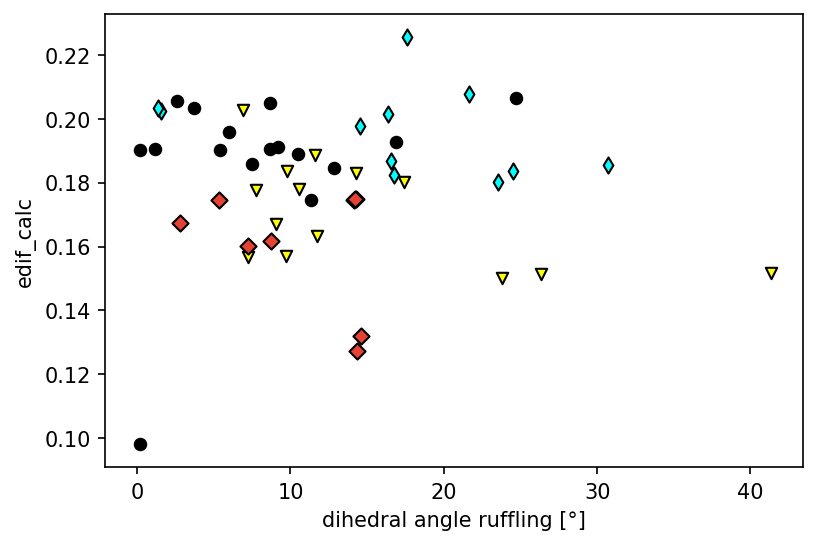

In [203]:
plt.figure(dpi=150)
scatterkat(df,"ruffling","edif",Kategorie)
plt.xlabel(dihedruf)
plt.ylabel("edif_calc")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif_calc')

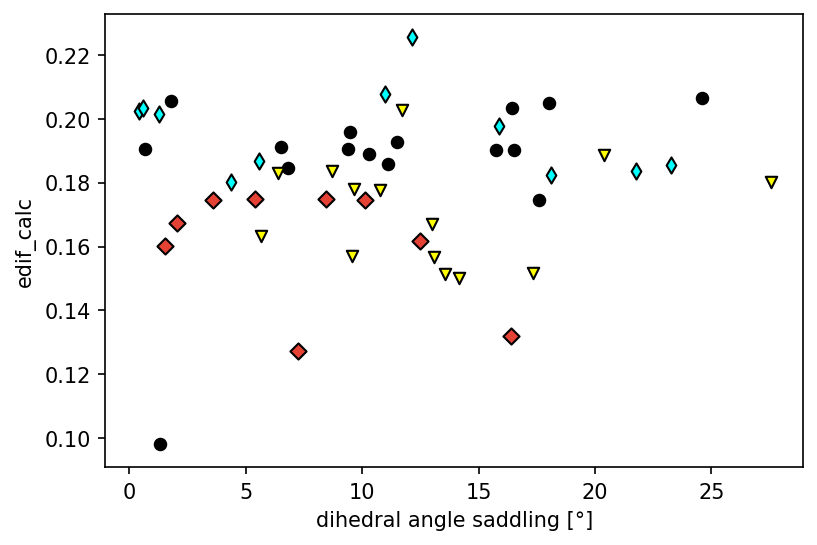

In [204]:
plt.figure(dpi=150)
scatterkat(df,"saddling","edif",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel("edif_calc")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0, 0.5, 'edif-2-1')

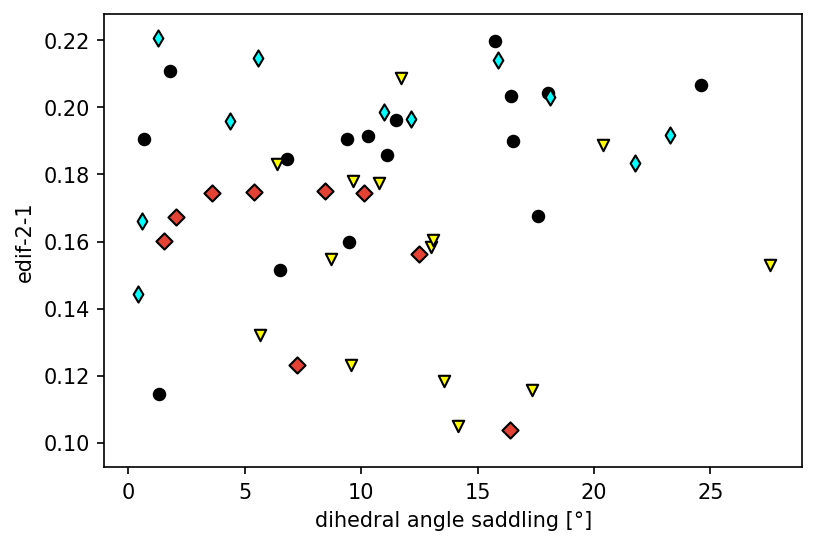

In [205]:
plt.figure(dpi=150)
scatterkat(df,"saddling","edif-2-1",Kategorie)
plt.xlabel(dihedsad)
plt.ylabel("edif-2-1")

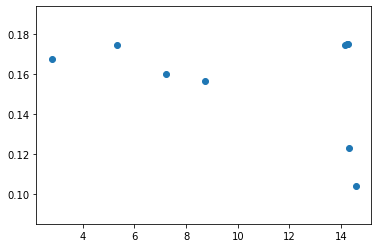

In [206]:
df = df_work3.copy()
df  = df[df["Kategorie2"]==HH]                   
plt.scatter(df["ruffling"],df["edif-2-1"])

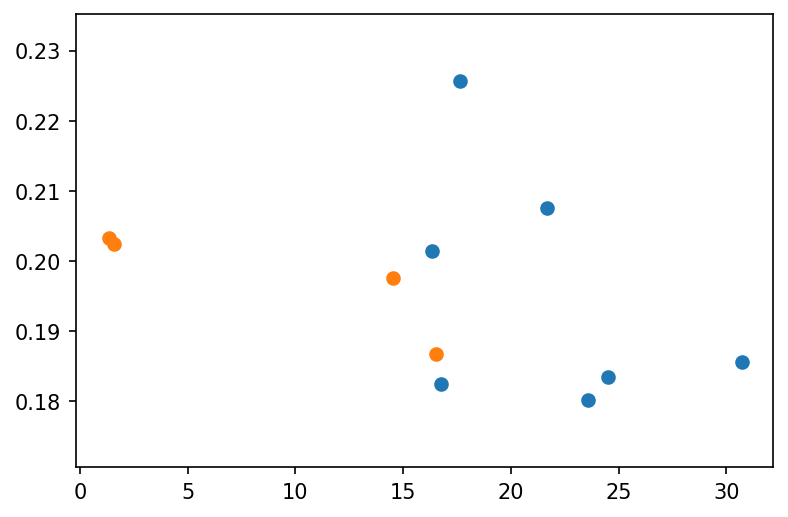

In [207]:
plt.figure(dpi=150)
df = df_work3.copy()
df3 = df[df["Kategorie2"]==BHIS]
df3=df3[df3["ligup"]=="-"]
plt.scatter(df3["ruffling"],df3["edif"])
df = df_work3.copy()
df3 = df[df["Kategorie2"]==BHIS]
df3=df3[df3["ligdown"]=="-"]
plt.scatter(df3["ruffling"],df3["edif"])


#scatterkat(df3,"saddling","edif",Kategorie)

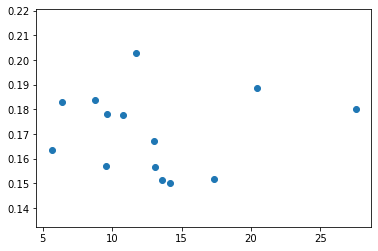

In [208]:
df = df_work3.copy()
df  = df[df["Kategorie2"]==CHM]                   
plt.scatter(df["saddling"],df["edif"])

In [209]:
df = dflg.copy()
df = df[df["Kategorie2"]==CHM]

In [210]:
len(df["ruffling"][np.array(df["ruffling"])<15])

22

In [211]:
len(df["ruffling"][np.array(df["ruffling"])>15])

7

In [212]:
len(df["ruffling"][np.array(df["ruffling"])<15])/(len(df["ruffling"][np.array(df["ruffling"])<15])+len(df["ruffling"][np.array(df["ruffling"])>15]))

0.7586206896551724

In [213]:
df = df_work3.copy()

In [214]:
df_work3["homo_fe2"] = [np.array([h,l]).min() for h,l in zip(df["homo_1_nbo"],df["homo_5_nbo"])]
df_work3["homo_fe3"] = [np.array([h,l]).min() for h,l in zip(df["homo_2_nbo"],df["homo_6_nbo"])]
df_work3["lumo_fe2"] = [np.array([h,l]).min() for h,l in zip(df["lumo_1_nbo"],df["lumo_5_nbo"])]
df_work3["lumo_fe3"] = [np.array([h,l]).min() for h,l in zip(df["lumo_2_nbo"],df["lumo_6_nbo"])]
df_work3["diff_fe2"] = df_work3["lumo_fe2"]-df_work3["homo_fe2"]
df_work3["diff_fe3"] = df_work3["lumo_fe3"]-df_work3["homo_fe3"]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


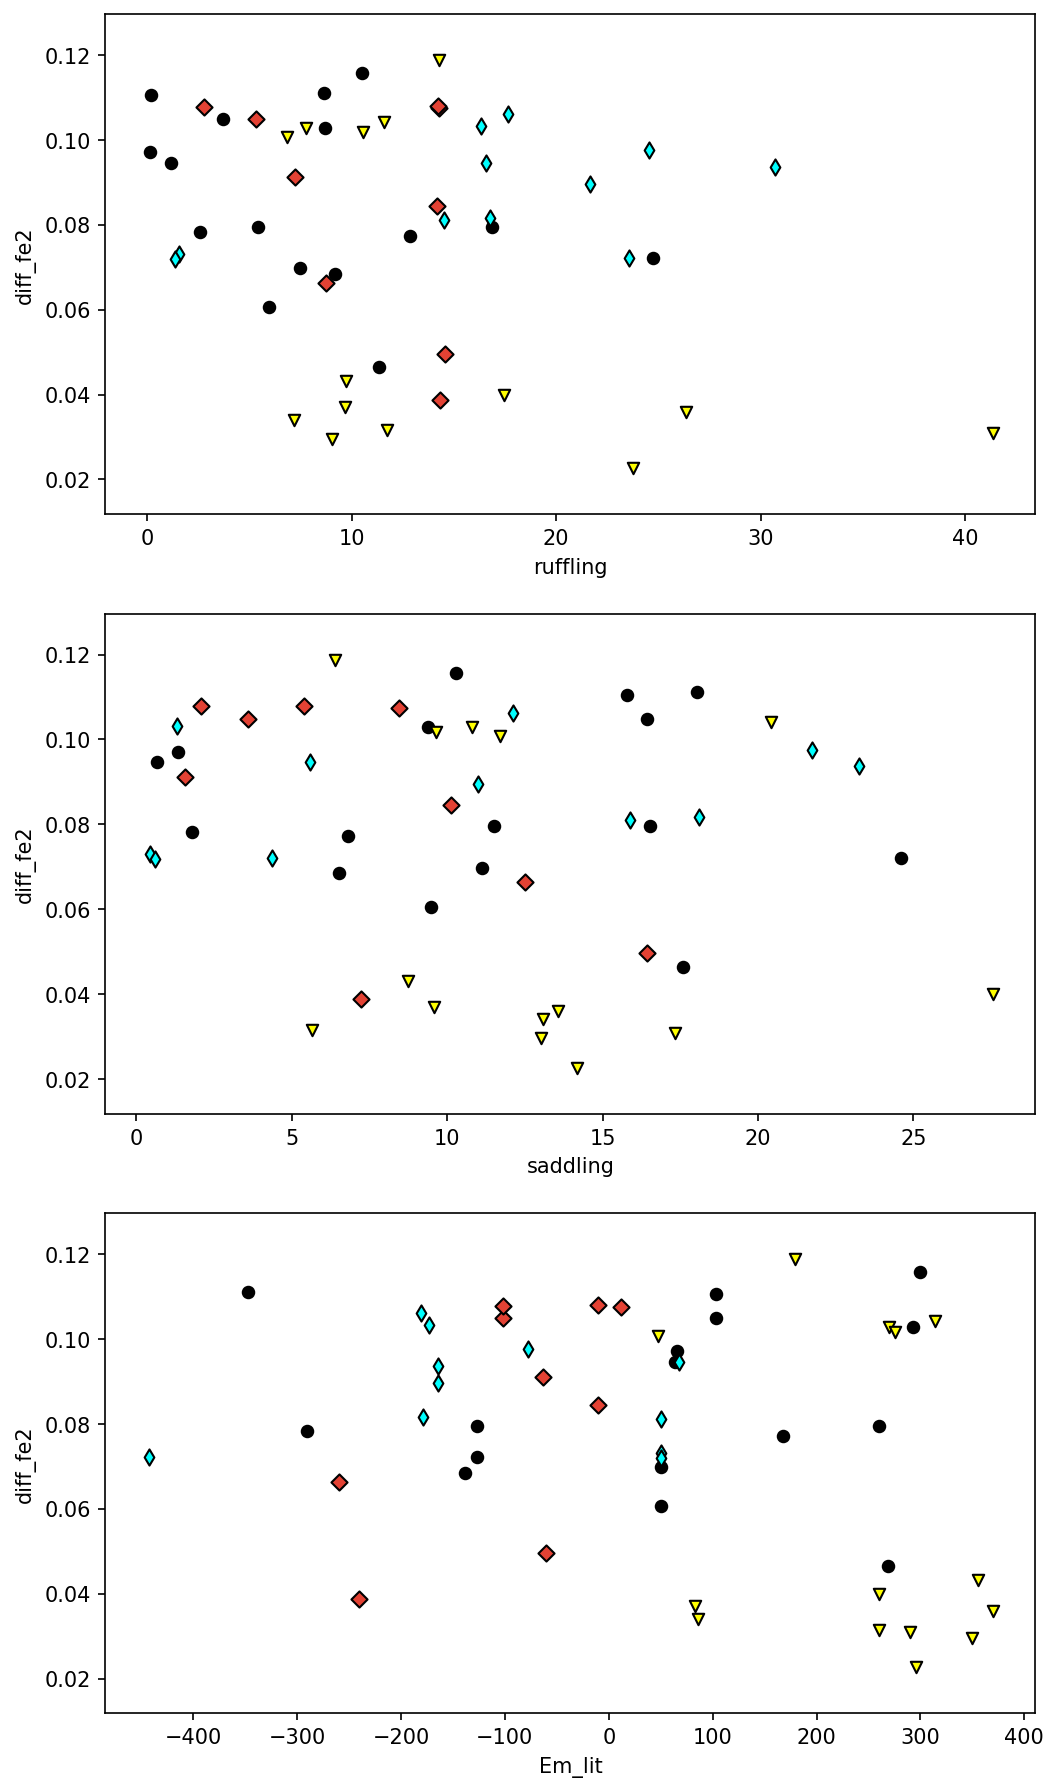

In [215]:
df = df_work3.copy()
plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([1,2,3],["ruffling","saddling","Em_lit"]):
    plt.subplot(3,1,a)
    scatterkat(df,b,"diff_fe2",Kategorie)
    plt.xlabel(b)
    plt.ylabel("diff_fe2")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


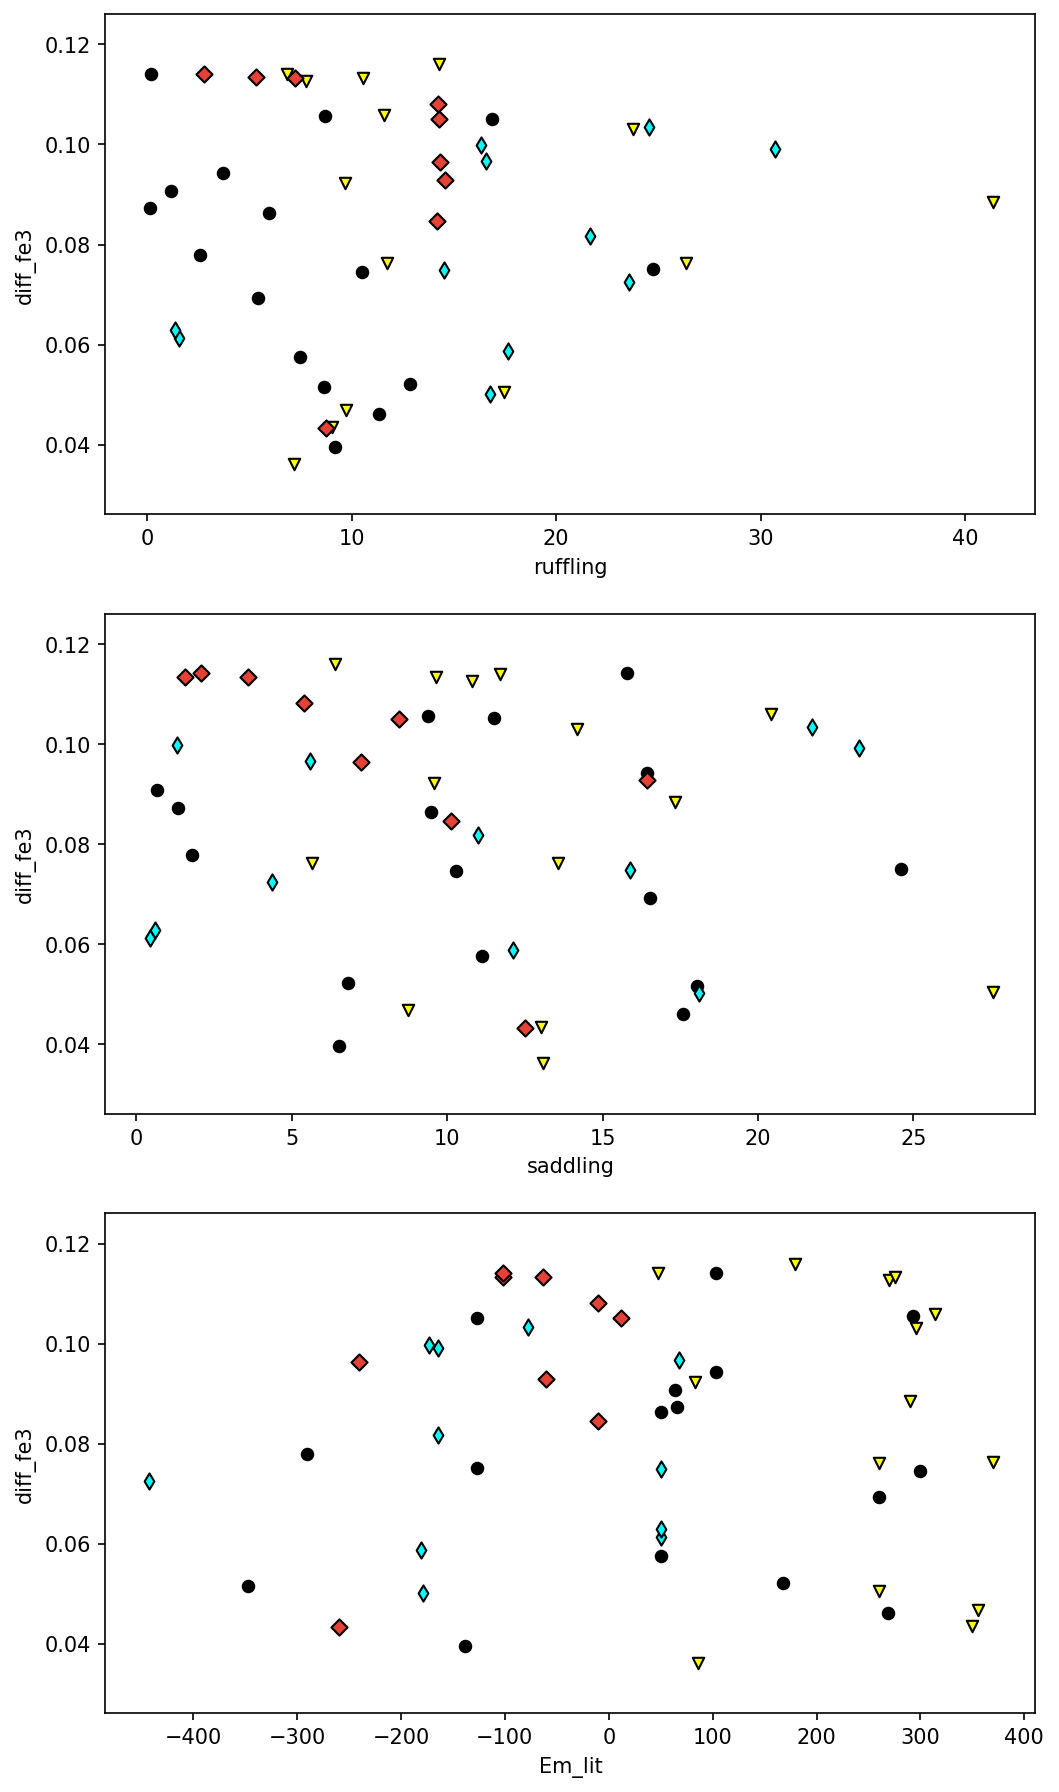

In [216]:
df = df_work3.copy()
plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([1,2,3],["ruffling","saddling","Em_lit"]):
    plt.subplot(3,1,a)
    scatterkat(df,b,"diff_fe3",Kategorie)
    plt.xlabel(b)
    plt.ylabel("diff_fe3")

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

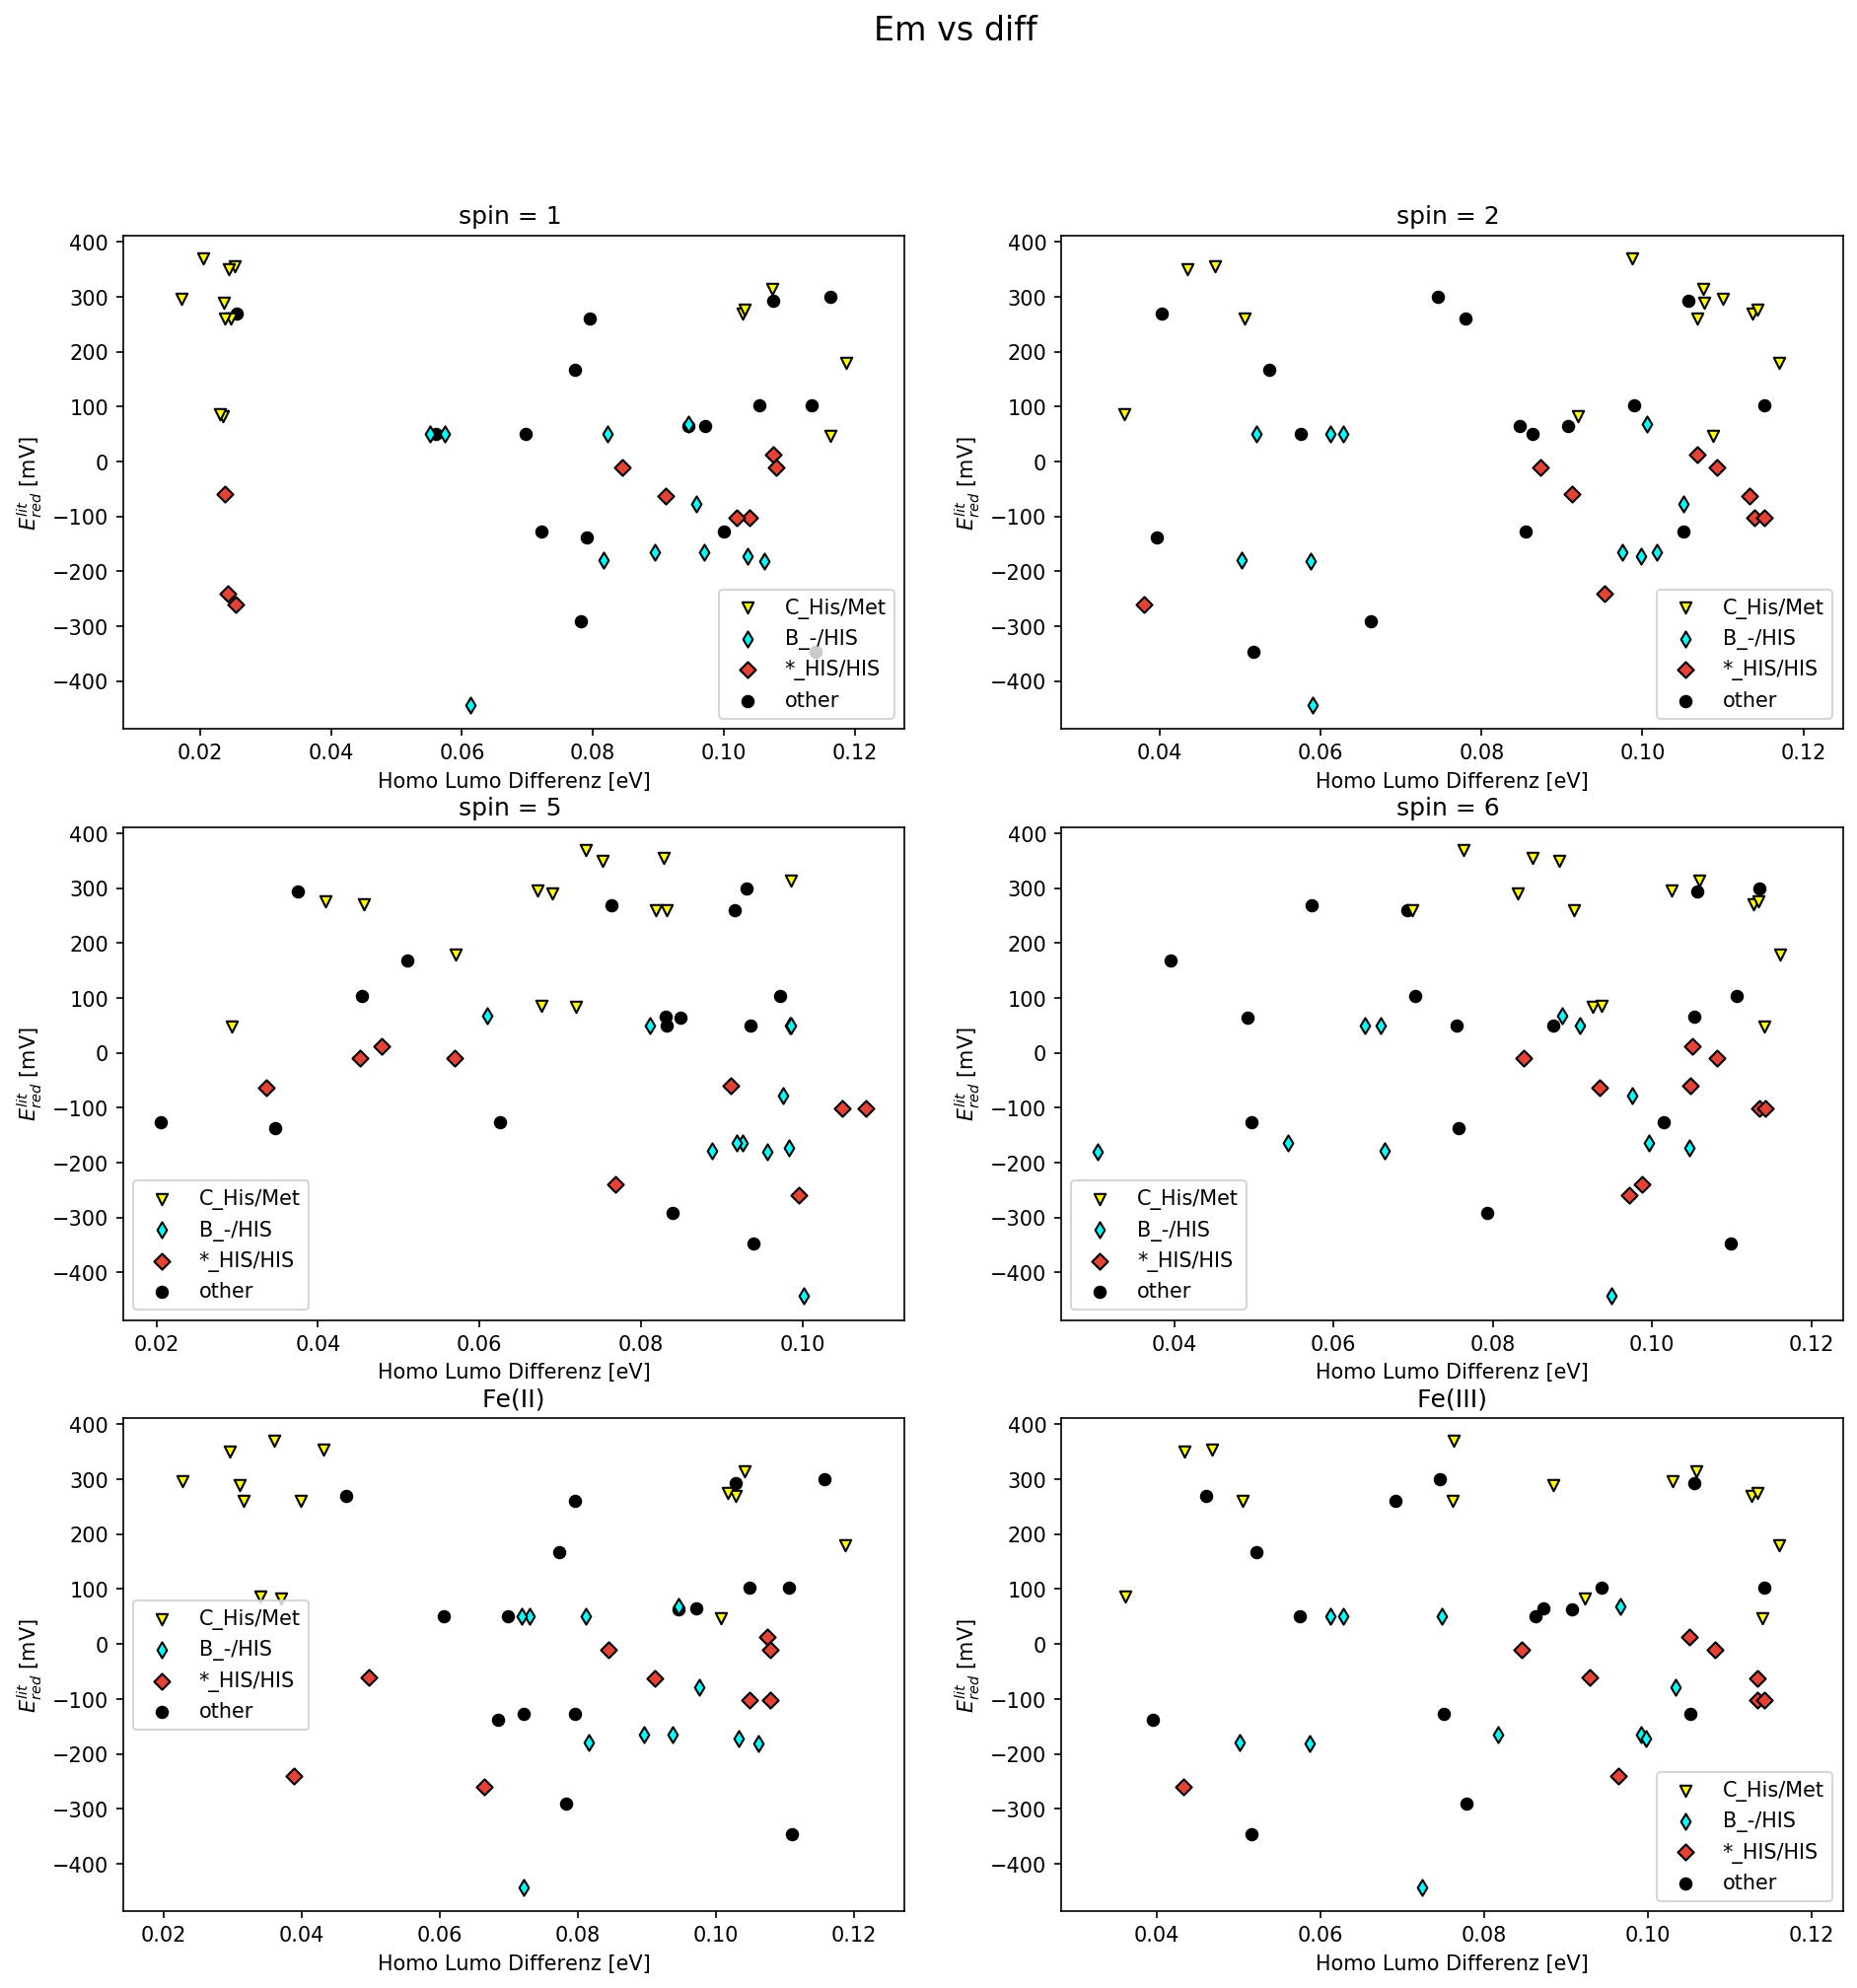

In [217]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('Em vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.xlabel("Homo Lumo Differenz [eV]")
    plt.ylabel(redox)
    scatterkat(df_work2,f"diff_{str(s)}_nbo","Em_lit",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df,b,"Em_lit",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.xlabel("Homo Lumo Differenz [eV]")
    plt.ylabel(redox)   
    plt.legend()

fig.savefig(f"{plots}Em_diff.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

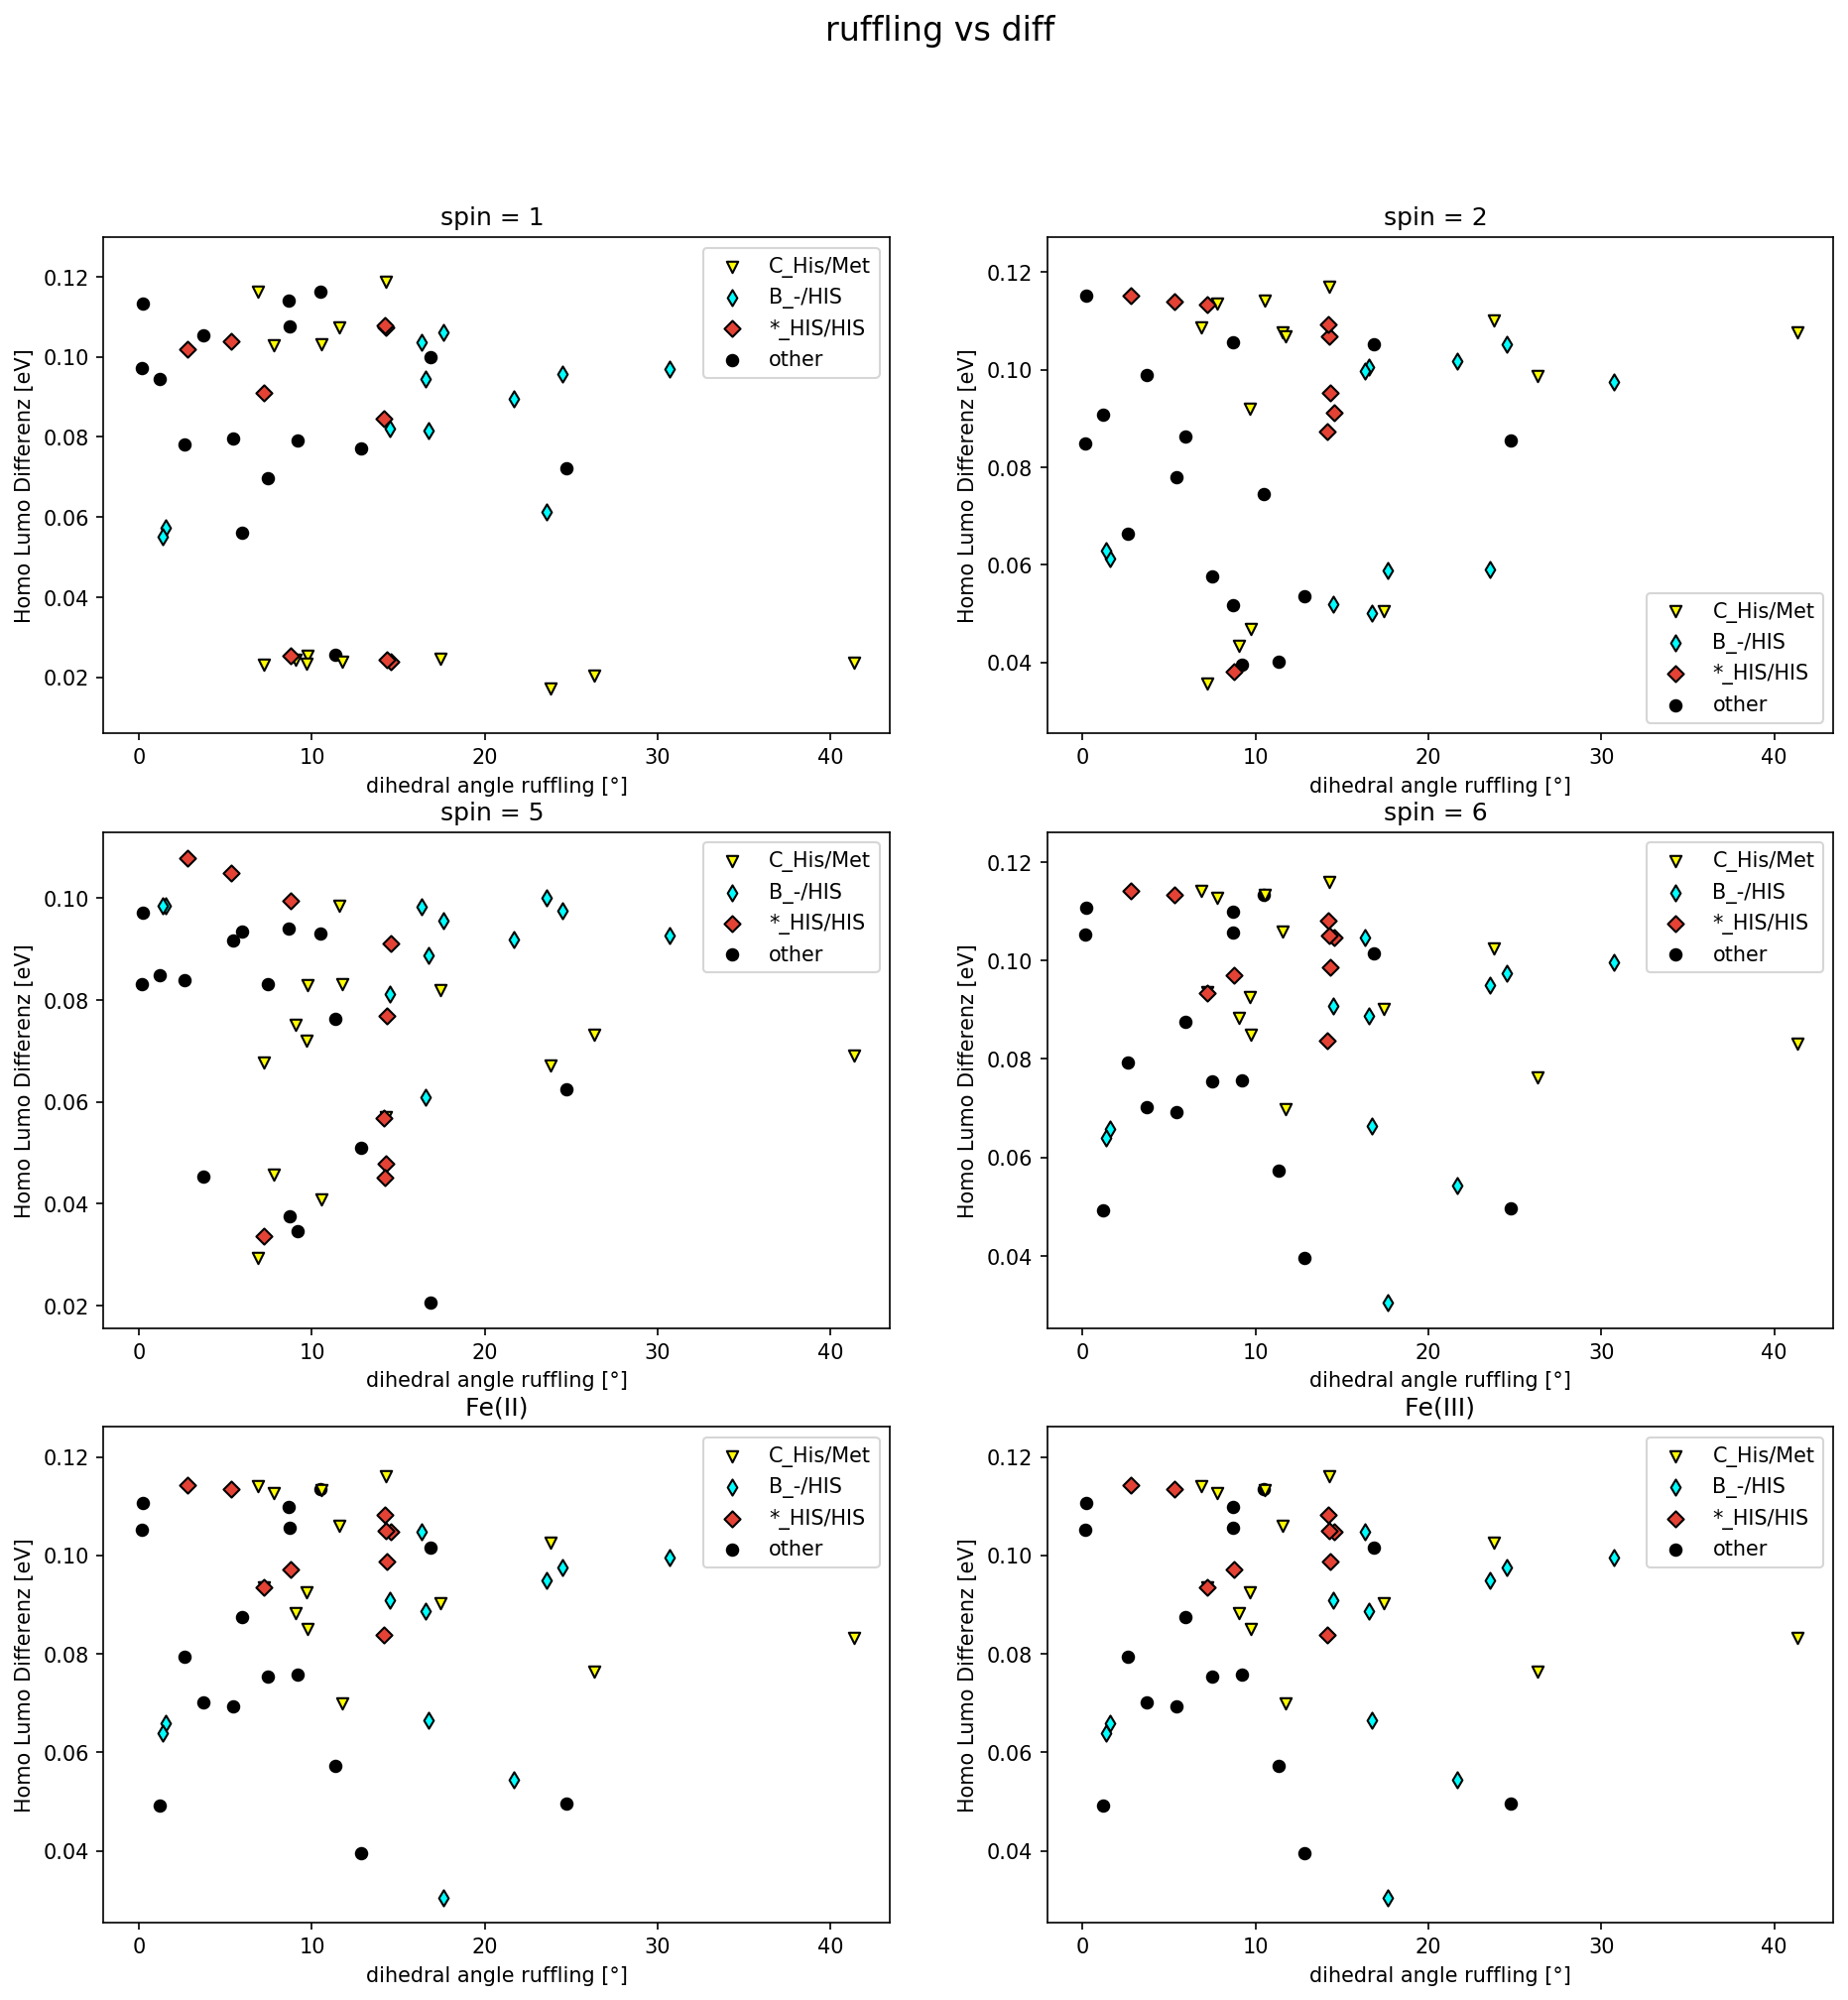

In [218]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('ruffling vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedruf)
    scatterkat(df_work2,"ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df_work2,"ruffling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedruf   )
    plt.legend()

fig.savefig(f"{plots}diff_saddling.png")            

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

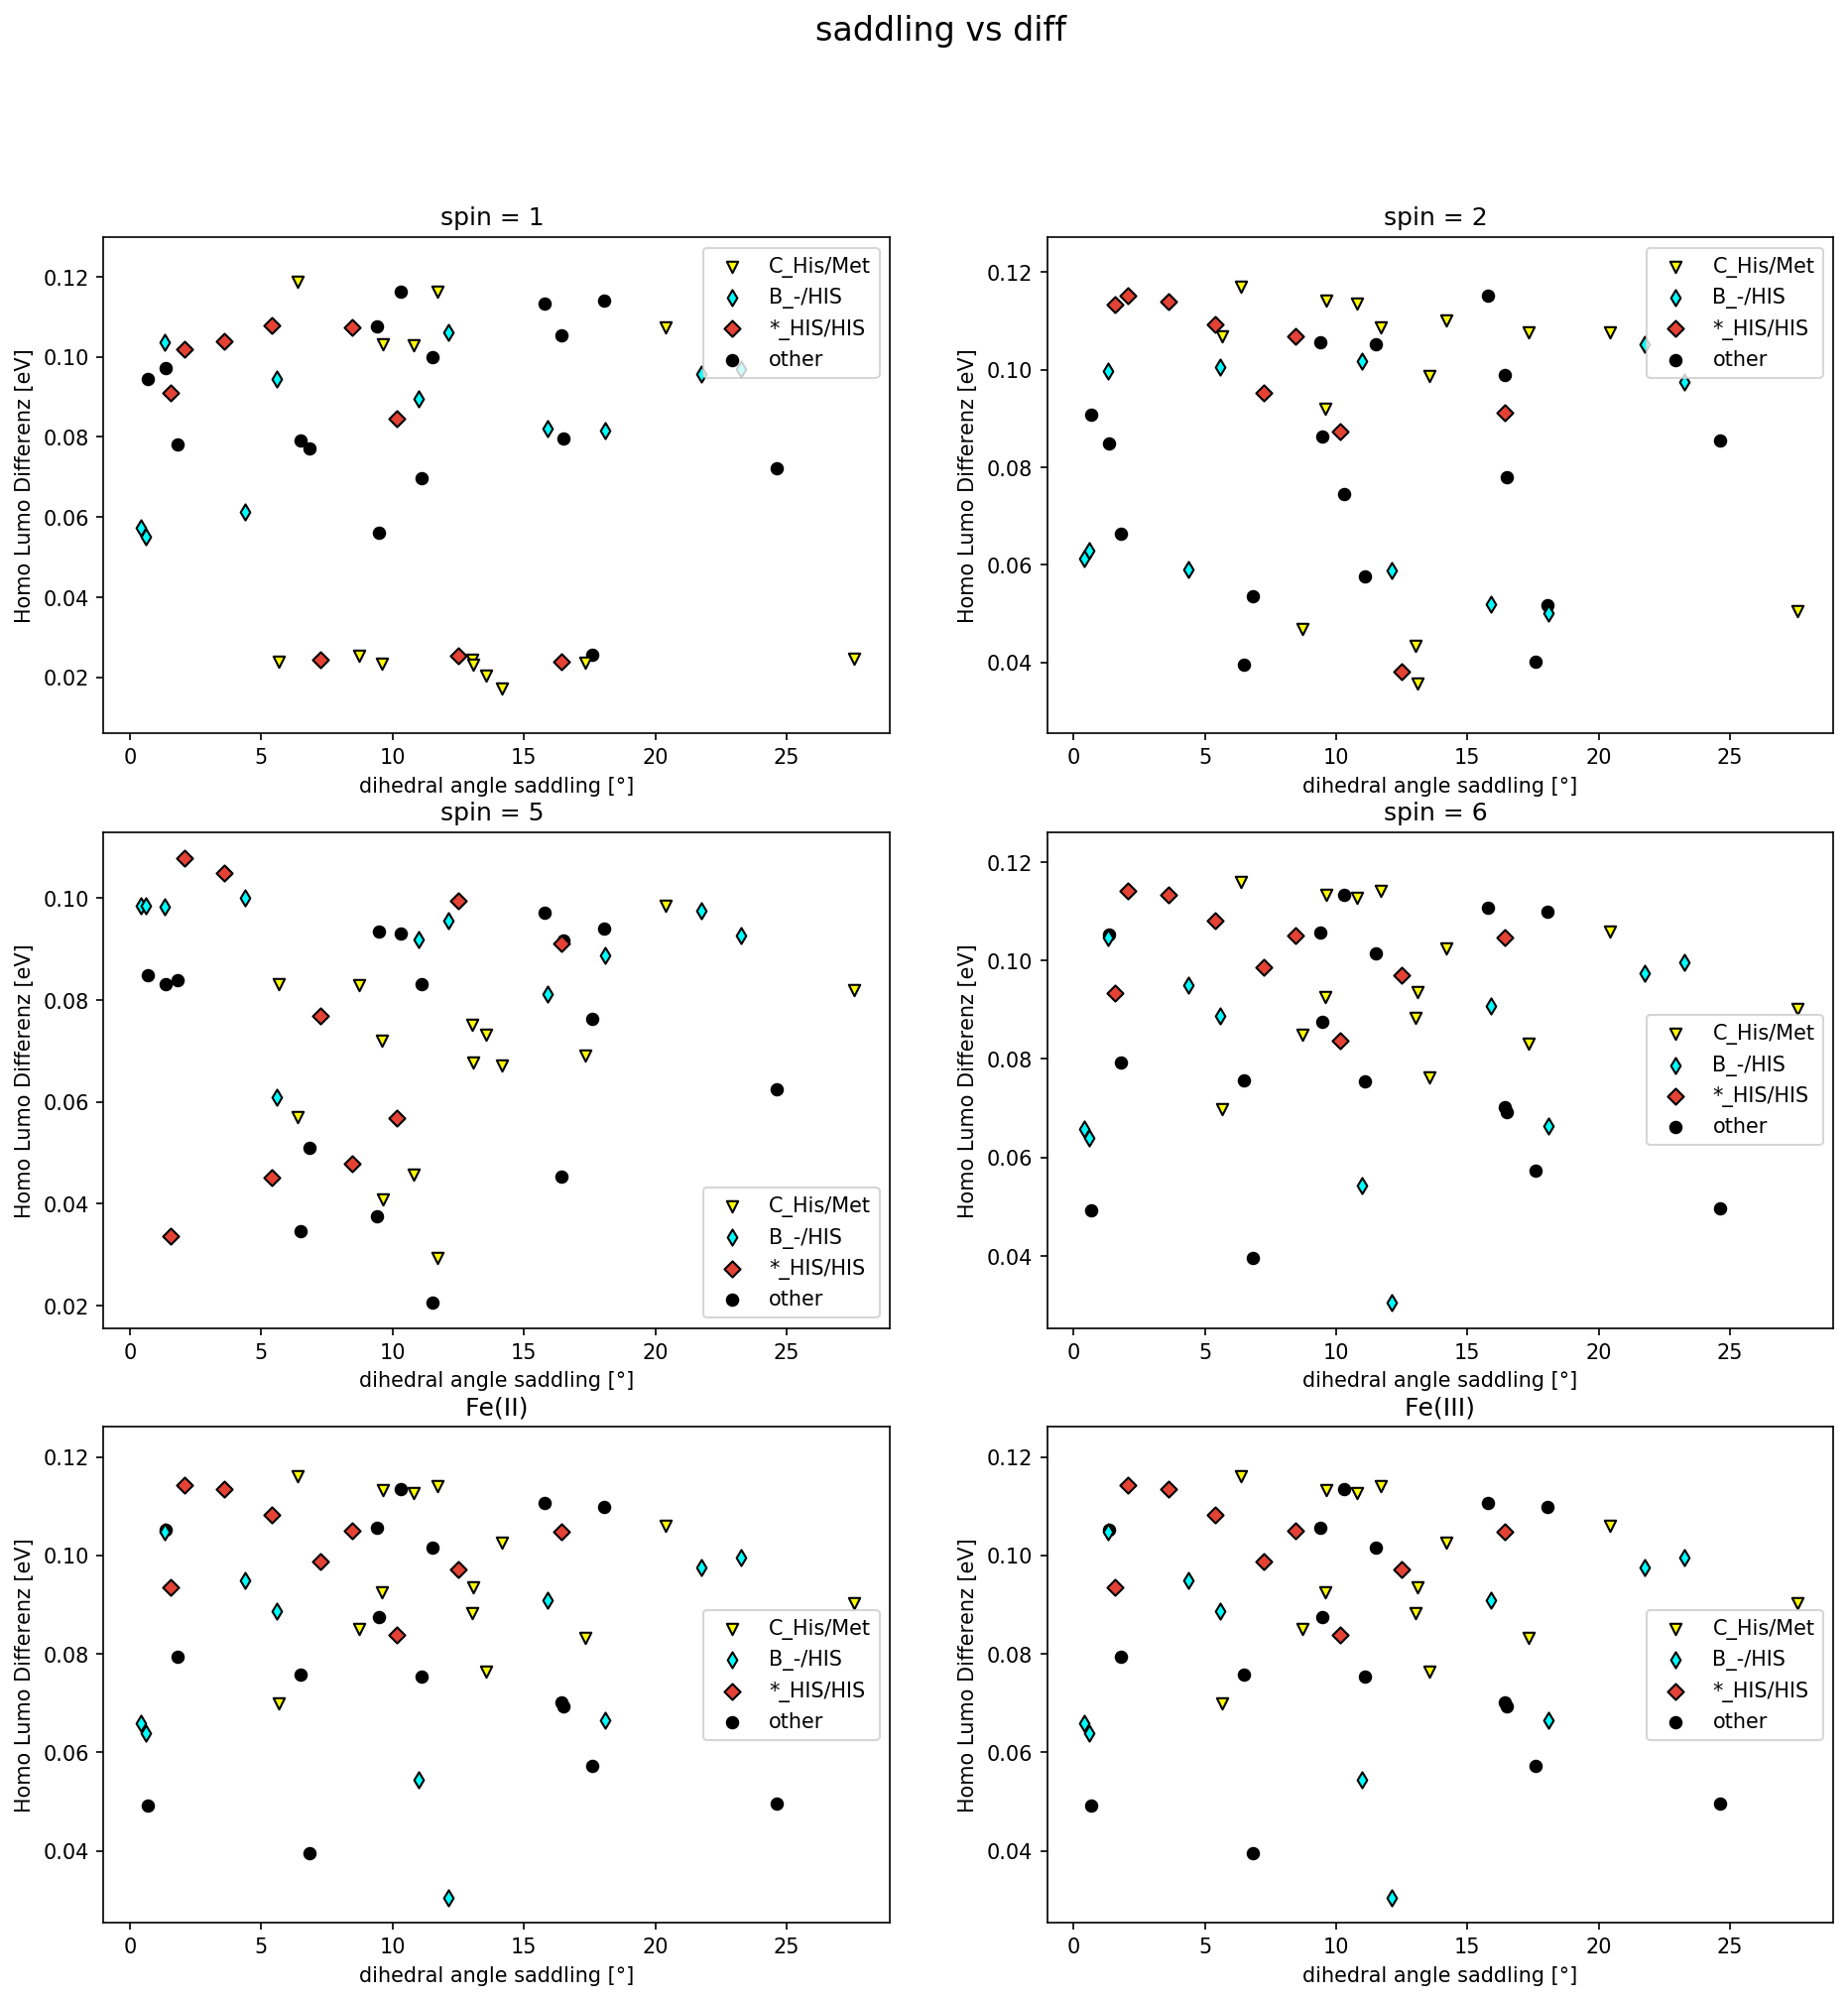

In [219]:
fig = plt.figure(dpi = 150,figsize=(15,15))
for i,s in zip([1,2,3,4],[1,2,5,6]):
    fig.suptitle('saddling vs diff', fontsize=16)
    plt.subplot(3,2,i)
    plt.title(f"spin = {s} ")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedsad)
    scatterkat(df_work2,"saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.legend()
df = df_work3.copy()
#plt.figure(dpi=150,figsize=[8,15])
for a,b in zip([5,6],["diff_fe2","diff_fe3"]):
    plt.subplot(3,2,a)
    scatterkat(df_work2,"saddling",f"diff_{str(s)}_nbo",Kategorie)
    plt.title(f"Fe({'I'*(a-3)})")
    plt.ylabel("Homo Lumo Differenz [eV]")
    plt.xlabel(dihedsad   )
    plt.legend()

fig.savefig(f"{plots}diff_ruffling.png")            

In [104]:
df = dfpca2.copy()

In [105]:
[i for i in df.columns if "_nbo" not in i]

['Em_lit',
 'ruffling',
 'saddling',
 '*_HIS/HIS',
 'B_-/HIS',
 'C_His/Met',
 'du ',
 'uu ',
 'ud ',
 'dd ',
 'edif-2-1',
 'edif-2-5',
 'edif-6-1',
 'edif-6-5',
 'edisp',
 'e']

In [106]:
[i for i in df.columns if "1_nbo" in i]

['homo_1_nbo',
 'lumo_1_nbo',
 'chem_pot_1_nbo',
 'diff_1_nbo',
 'elekphil_1_nbo',
 'dipole_1_nbo',
 'qpole1_1_nbo',
 'qpole2_1_nbo',
 'qpole3_1_nbo',
 'qpole4_1_nbo']